In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (195520, 2) (49772, 2)
train/valid # (195520, 2) (49772, 2)


rand split across time
train has 195520 records out of 372221 records
valid has 49772 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1527
0
26 18 (1, 18)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1527 [..............................] - ETA: 40:30 - loss: 7.4479 - total_loss: 7.4479 - reg_loss: 7.4479

   6/1527 [..............................] - ETA: 6:58 - loss: 2.6199 - total_loss: 2.6199 - reg_loss: 2.6199 

  11/1527 [..............................] - ETA: 3:54 - loss: 1.8950 - total_loss: 1.8950 - reg_loss: 1.8950

  16/1527 [..............................] - ETA: 2:45 - loss: 1.5141 - total_loss: 1.5141 - reg_loss: 1.5141

  21/1527 [..............................] - ETA: 2:09 - loss: 1.2935 - total_loss: 1.2935 - reg_loss: 1.2935

  26/1527 [..............................] - ETA: 1:47 - loss: 1.1476 - total_loss: 1.1476 - reg_loss: 1.1476

  31/1527 [..............................] - ETA: 1:32 - loss: 1.0354 - total_loss: 1.0354 - reg_loss: 1.0354

  36/1527 [..............................] - ETA: 1:21 - loss: 0.9578 - total_loss: 0.9578 - reg_loss: 0.9578

  42/1527 [..............................] - ETA: 1:11 - loss: 0.8859 - total_loss: 0.8859 - reg_loss: 0.8859

  48/1527 [..............................] - ETA: 1:04 - loss: 0.8301 - total_loss: 0.8301 - reg_loss: 0.8301

  53/1527 [>.............................] - ETA: 59s - loss: 0.7857 - total_loss: 0.7857 - reg_loss: 0.7857 

  59/1527 [>.............................] - ETA: 54s - loss: 0.7414 - total_loss: 0.7414 - reg_loss: 0.7414

  64/1527 [>.............................] - ETA: 51s - loss: 0.7098 - total_loss: 0.7098 - reg_loss: 0.7098

  69/1527 [>.............................] - ETA: 48s - loss: 0.6841 - total_loss: 0.6841 - reg_loss: 0.6841

  74/1527 [>.............................] - ETA: 46s - loss: 0.6628 - total_loss: 0.6628 - reg_loss: 0.6628

  79/1527 [>.............................] - ETA: 44s - loss: 0.6438 - total_loss: 0.6438 - reg_loss: 0.6438

  85/1527 [>.............................] - ETA: 41s - loss: 0.6206 - total_loss: 0.6206 - reg_loss: 0.6206

  90/1527 [>.............................] - ETA: 40s - loss: 0.6084 - total_loss: 0.6084 - reg_loss: 0.6084

  95/1527 [>.............................] - ETA: 38s - loss: 0.5942 - total_loss: 0.5942 - reg_loss: 0.5942

 100/1527 [>.............................] - ETA: 37s - loss: 0.5828 - total_loss: 0.5828 - reg_loss: 0.5828

 106/1527 [=>............................] - ETA: 35s - loss: 0.5681 - total_loss: 0.5681 - reg_loss: 0.5681

 112/1527 [=>............................] - ETA: 34s - loss: 0.5541 - total_loss: 0.5541 - reg_loss: 0.5541

 117/1527 [=>............................] - ETA: 33s - loss: 0.5446 - total_loss: 0.5446 - reg_loss: 0.5446

 122/1527 [=>............................] - ETA: 32s - loss: 0.5366 - total_loss: 0.5366 - reg_loss: 0.5366

 128/1527 [=>............................] - ETA: 31s - loss: 0.5263 - total_loss: 0.5263 - reg_loss: 0.5263

 133/1527 [=>............................] - ETA: 30s - loss: 0.5185 - total_loss: 0.5185 - reg_loss: 0.5185

 138/1527 [=>............................] - ETA: 30s - loss: 0.5114 - total_loss: 0.5114 - reg_loss: 0.5114

 144/1527 [=>............................] - ETA: 29s - loss: 0.5037 - total_loss: 0.5037 - reg_loss: 0.5037

 150/1527 [=>............................] - ETA: 28s - loss: 0.4972 - total_loss: 0.4972 - reg_loss: 0.4972

 156/1527 [==>...........................] - ETA: 27s - loss: 0.4913 - total_loss: 0.4913 - reg_loss: 0.4913

 161/1527 [==>...........................] - ETA: 27s - loss: 0.4853 - total_loss: 0.4853 - reg_loss: 0.4853

 167/1527 [==>...........................] - ETA: 26s - loss: 0.4795 - total_loss: 0.4795 - reg_loss: 0.4795

 172/1527 [==>...........................] - ETA: 26s - loss: 0.4748 - total_loss: 0.4748 - reg_loss: 0.4748

 177/1527 [==>...........................] - ETA: 25s - loss: 0.4694 - total_loss: 0.4694 - reg_loss: 0.4694

 182/1527 [==>...........................] - ETA: 25s - loss: 0.4647 - total_loss: 0.4647 - reg_loss: 0.4647

 187/1527 [==>...........................] - ETA: 25s - loss: 0.4605 - total_loss: 0.4605 - reg_loss: 0.4605

 192/1527 [==>...........................] - ETA: 24s - loss: 0.4563 - total_loss: 0.4563 - reg_loss: 0.4563

 198/1527 [==>...........................] - ETA: 24s - loss: 0.4516 - total_loss: 0.4516 - reg_loss: 0.4516

 203/1527 [==>...........................] - ETA: 23s - loss: 0.4484 - total_loss: 0.4484 - reg_loss: 0.4484

 208/1527 [===>..........................] - ETA: 23s - loss: 0.4446 - total_loss: 0.4446 - reg_loss: 0.4446

 213/1527 [===>..........................] - ETA: 23s - loss: 0.4420 - total_loss: 0.4420 - reg_loss: 0.4420

 218/1527 [===>..........................] - ETA: 22s - loss: 0.4390 - total_loss: 0.4390 - reg_loss: 0.4390

 223/1527 [===>..........................] - ETA: 22s - loss: 0.4369 - total_loss: 0.4369 - reg_loss: 0.4369

 228/1527 [===>..........................] - ETA: 22s - loss: 0.4341 - total_loss: 0.4341 - reg_loss: 0.4341

 233/1527 [===>..........................] - ETA: 22s - loss: 0.4316 - total_loss: 0.4316 - reg_loss: 0.4316

 238/1527 [===>..........................] - ETA: 21s - loss: 0.4286 - total_loss: 0.4286 - reg_loss: 0.4286

 243/1527 [===>..........................] - ETA: 21s - loss: 0.4251 - total_loss: 0.4251 - reg_loss: 0.4251

 248/1527 [===>..........................] - ETA: 21s - loss: 0.4229 - total_loss: 0.4229 - reg_loss: 0.4229

 253/1527 [===>..........................] - ETA: 21s - loss: 0.4212 - total_loss: 0.4212 - reg_loss: 0.4212

 258/1527 [====>.........................] - ETA: 20s - loss: 0.4191 - total_loss: 0.4191 - reg_loss: 0.4191

 264/1527 [====>.........................] - ETA: 20s - loss: 0.4166 - total_loss: 0.4166 - reg_loss: 0.4166

 269/1527 [====>.........................] - ETA: 20s - loss: 0.4144 - total_loss: 0.4144 - reg_loss: 0.4144

 274/1527 [====>.........................] - ETA: 20s - loss: 0.4129 - total_loss: 0.4129 - reg_loss: 0.4129

 279/1527 [====>.........................] - ETA: 19s - loss: 0.4109 - total_loss: 0.4109 - reg_loss: 0.4109

 284/1527 [====>.........................] - ETA: 19s - loss: 0.4097 - total_loss: 0.4097 - reg_loss: 0.4097

 289/1527 [====>.........................] - ETA: 19s - loss: 0.4084 - total_loss: 0.4084 - reg_loss: 0.4084

 294/1527 [====>.........................] - ETA: 19s - loss: 0.4067 - total_loss: 0.4067 - reg_loss: 0.4067

 299/1527 [====>.........................] - ETA: 19s - loss: 0.4051 - total_loss: 0.4051 - reg_loss: 0.4051

 304/1527 [====>.........................] - ETA: 18s - loss: 0.4028 - total_loss: 0.4028 - reg_loss: 0.4028

 310/1527 [=====>........................] - ETA: 18s - loss: 0.4003 - total_loss: 0.4003 - reg_loss: 0.4003

 315/1527 [=====>........................] - ETA: 18s - loss: 0.3994 - total_loss: 0.3994 - reg_loss: 0.3994

 320/1527 [=====>........................] - ETA: 18s - loss: 0.3981 - total_loss: 0.3981 - reg_loss: 0.3981

 325/1527 [=====>........................] - ETA: 18s - loss: 0.3966 - total_loss: 0.3966 - reg_loss: 0.3966

 330/1527 [=====>........................] - ETA: 18s - loss: 0.3948 - total_loss: 0.3948 - reg_loss: 0.3948

 335/1527 [=====>........................] - ETA: 17s - loss: 0.3932 - total_loss: 0.3932 - reg_loss: 0.3932

 340/1527 [=====>........................] - ETA: 17s - loss: 0.3919 - total_loss: 0.3919 - reg_loss: 0.3919

 345/1527 [=====>........................] - ETA: 17s - loss: 0.3911 - total_loss: 0.3911 - reg_loss: 0.3911

 350/1527 [=====>........................] - ETA: 17s - loss: 0.3893 - total_loss: 0.3893 - reg_loss: 0.3893

 355/1527 [=====>........................] - ETA: 17s - loss: 0.3880 - total_loss: 0.3880 - reg_loss: 0.3880

 360/1527 [======>.......................] - ETA: 17s - loss: 0.3871 - total_loss: 0.3871 - reg_loss: 0.3871

 365/1527 [======>.......................] - ETA: 17s - loss: 0.3858 - total_loss: 0.3858 - reg_loss: 0.3858

 370/1527 [======>.......................] - ETA: 16s - loss: 0.3850 - total_loss: 0.3850 - reg_loss: 0.3850

 375/1527 [======>.......................] - ETA: 16s - loss: 0.3838 - total_loss: 0.3838 - reg_loss: 0.3838

 380/1527 [======>.......................] - ETA: 16s - loss: 0.3824 - total_loss: 0.3824 - reg_loss: 0.3824

 385/1527 [======>.......................] - ETA: 16s - loss: 0.3807 - total_loss: 0.3807 - reg_loss: 0.3807

 390/1527 [======>.......................] - ETA: 16s - loss: 0.3803 - total_loss: 0.3803 - reg_loss: 0.3803

 396/1527 [======>.......................] - ETA: 16s - loss: 0.3797 - total_loss: 0.3797 - reg_loss: 0.3797

 401/1527 [======>.......................] - ETA: 16s - loss: 0.3788 - total_loss: 0.3788 - reg_loss: 0.3788

 406/1527 [======>.......................] - ETA: 15s - loss: 0.3779 - total_loss: 0.3779 - reg_loss: 0.3779

 412/1527 [=======>......................] - ETA: 15s - loss: 0.3769 - total_loss: 0.3769 - reg_loss: 0.3769

 417/1527 [=======>......................] - ETA: 15s - loss: 0.3761 - total_loss: 0.3761 - reg_loss: 0.3761

 423/1527 [=======>......................] - ETA: 15s - loss: 0.3753 - total_loss: 0.3753 - reg_loss: 0.3753

 428/1527 [=======>......................] - ETA: 15s - loss: 0.3741 - total_loss: 0.3741 - reg_loss: 0.3741

 433/1527 [=======>......................] - ETA: 15s - loss: 0.3726 - total_loss: 0.3726 - reg_loss: 0.3726

 438/1527 [=======>......................] - ETA: 15s - loss: 0.3720 - total_loss: 0.3720 - reg_loss: 0.3720

 443/1527 [=======>......................] - ETA: 15s - loss: 0.3712 - total_loss: 0.3712 - reg_loss: 0.3712

 448/1527 [=======>......................] - ETA: 14s - loss: 0.3705 - total_loss: 0.3705 - reg_loss: 0.3705

 453/1527 [=======>......................] - ETA: 14s - loss: 0.3698 - total_loss: 0.3698 - reg_loss: 0.3698

 458/1527 [=======>......................] - ETA: 14s - loss: 0.3693 - total_loss: 0.3693 - reg_loss: 0.3693

 464/1527 [========>.....................] - ETA: 14s - loss: 0.3679 - total_loss: 0.3679 - reg_loss: 0.3679

 469/1527 [========>.....................] - ETA: 14s - loss: 0.3668 - total_loss: 0.3668 - reg_loss: 0.3668

 474/1527 [========>.....................] - ETA: 14s - loss: 0.3659 - total_loss: 0.3659 - reg_loss: 0.3659

 479/1527 [========>.....................] - ETA: 14s - loss: 0.3647 - total_loss: 0.3647 - reg_loss: 0.3647

 484/1527 [========>.....................] - ETA: 14s - loss: 0.3639 - total_loss: 0.3639 - reg_loss: 0.3639

 489/1527 [========>.....................] - ETA: 14s - loss: 0.3631 - total_loss: 0.3631 - reg_loss: 0.3631

 494/1527 [========>.....................] - ETA: 13s - loss: 0.3620 - total_loss: 0.3620 - reg_loss: 0.3620

 499/1527 [========>.....................] - ETA: 13s - loss: 0.3614 - total_loss: 0.3614 - reg_loss: 0.3614

 504/1527 [========>.....................] - ETA: 13s - loss: 0.3608 - total_loss: 0.3608 - reg_loss: 0.3608

 509/1527 [=========>....................] - ETA: 13s - loss: 0.3602 - total_loss: 0.3602 - reg_loss: 0.3602

 514/1527 [=========>....................] - ETA: 13s - loss: 0.3596 - total_loss: 0.3596 - reg_loss: 0.3596

 519/1527 [=========>....................] - ETA: 13s - loss: 0.3590 - total_loss: 0.3590 - reg_loss: 0.3590

 524/1527 [=========>....................] - ETA: 13s - loss: 0.3582 - total_loss: 0.3582 - reg_loss: 0.3582

 529/1527 [=========>....................] - ETA: 13s - loss: 0.3575 - total_loss: 0.3575 - reg_loss: 0.3575

 534/1527 [=========>....................] - ETA: 13s - loss: 0.3568 - total_loss: 0.3568 - reg_loss: 0.3568

 539/1527 [=========>....................] - ETA: 13s - loss: 0.3562 - total_loss: 0.3562 - reg_loss: 0.3562

 545/1527 [=========>....................] - ETA: 12s - loss: 0.3555 - total_loss: 0.3555 - reg_loss: 0.3555

 550/1527 [=========>....................] - ETA: 12s - loss: 0.3551 - total_loss: 0.3551 - reg_loss: 0.3551

 555/1527 [=========>....................] - ETA: 12s - loss: 0.3546 - total_loss: 0.3546 - reg_loss: 0.3546

 560/1527 [==========>...................] - ETA: 12s - loss: 0.3544 - total_loss: 0.3544 - reg_loss: 0.3544

 565/1527 [==========>...................] - ETA: 12s - loss: 0.3543 - total_loss: 0.3543 - reg_loss: 0.3543

 570/1527 [==========>...................] - ETA: 12s - loss: 0.3541 - total_loss: 0.3541 - reg_loss: 0.3541

 575/1527 [==========>...................] - ETA: 12s - loss: 0.3543 - total_loss: 0.3543 - reg_loss: 0.3543

 580/1527 [==========>...................] - ETA: 12s - loss: 0.3541 - total_loss: 0.3541 - reg_loss: 0.3541

 585/1527 [==========>...................] - ETA: 12s - loss: 0.3537 - total_loss: 0.3537 - reg_loss: 0.3537

 590/1527 [==========>...................] - ETA: 12s - loss: 0.3532 - total_loss: 0.3532 - reg_loss: 0.3532

 595/1527 [==========>...................] - ETA: 12s - loss: 0.3526 - total_loss: 0.3526 - reg_loss: 0.3526

 601/1527 [==========>...................] - ETA: 11s - loss: 0.3520 - total_loss: 0.3520 - reg_loss: 0.3520

 606/1527 [==========>...................] - ETA: 11s - loss: 0.3518 - total_loss: 0.3518 - reg_loss: 0.3518

 611/1527 [===========>..................] - ETA: 11s - loss: 0.3514 - total_loss: 0.3514 - reg_loss: 0.3514

 616/1527 [===========>..................] - ETA: 11s - loss: 0.3511 - total_loss: 0.3511 - reg_loss: 0.3511

 622/1527 [===========>..................] - ETA: 11s - loss: 0.3502 - total_loss: 0.3502 - reg_loss: 0.3502

 628/1527 [===========>..................] - ETA: 11s - loss: 0.3493 - total_loss: 0.3493 - reg_loss: 0.3493

 633/1527 [===========>..................] - ETA: 11s - loss: 0.3488 - total_loss: 0.3488 - reg_loss: 0.3488

 638/1527 [===========>..................] - ETA: 11s - loss: 0.3485 - total_loss: 0.3485 - reg_loss: 0.3485

 643/1527 [===========>..................] - ETA: 11s - loss: 0.3477 - total_loss: 0.3477 - reg_loss: 0.3477

 648/1527 [===========>..................] - ETA: 11s - loss: 0.3475 - total_loss: 0.3475 - reg_loss: 0.3475

 653/1527 [===========>..................] - ETA: 11s - loss: 0.3472 - total_loss: 0.3472 - reg_loss: 0.3472

 659/1527 [===========>..................] - ETA: 11s - loss: 0.3467 - total_loss: 0.3467 - reg_loss: 0.3467

 664/1527 [============>.................] - ETA: 10s - loss: 0.3463 - total_loss: 0.3463 - reg_loss: 0.3463

 669/1527 [============>.................] - ETA: 10s - loss: 0.3460 - total_loss: 0.3460 - reg_loss: 0.3460

 674/1527 [============>.................] - ETA: 10s - loss: 0.3457 - total_loss: 0.3457 - reg_loss: 0.3457

 679/1527 [============>.................] - ETA: 10s - loss: 0.3452 - total_loss: 0.3452 - reg_loss: 0.3452

 685/1527 [============>.................] - ETA: 10s - loss: 0.3447 - total_loss: 0.3447 - reg_loss: 0.3447

 691/1527 [============>.................] - ETA: 10s - loss: 0.3438 - total_loss: 0.3438 - reg_loss: 0.3438

 696/1527 [============>.................] - ETA: 10s - loss: 0.3436 - total_loss: 0.3436 - reg_loss: 0.3436

 702/1527 [============>.................] - ETA: 10s - loss: 0.3431 - total_loss: 0.3431 - reg_loss: 0.3431

 707/1527 [============>.................] - ETA: 10s - loss: 0.3428 - total_loss: 0.3428 - reg_loss: 0.3428

 712/1527 [============>.................] - ETA: 10s - loss: 0.3429 - total_loss: 0.3429 - reg_loss: 0.3429

 717/1527 [=============>................] - ETA: 10s - loss: 0.3429 - total_loss: 0.3429 - reg_loss: 0.3429

 722/1527 [=============>................] - ETA: 10s - loss: 0.3424 - total_loss: 0.3424 - reg_loss: 0.3424

 728/1527 [=============>................] - ETA: 9s - loss: 0.3418 - total_loss: 0.3418 - reg_loss: 0.3418 

 733/1527 [=============>................] - ETA: 9s - loss: 0.3414 - total_loss: 0.3414 - reg_loss: 0.3414

 738/1527 [=============>................] - ETA: 9s - loss: 0.3412 - total_loss: 0.3412 - reg_loss: 0.3412

 743/1527 [=============>................] - ETA: 9s - loss: 0.3410 - total_loss: 0.3410 - reg_loss: 0.3410

 748/1527 [=============>................] - ETA: 9s - loss: 0.3406 - total_loss: 0.3406 - reg_loss: 0.3406

 753/1527 [=============>................] - ETA: 9s - loss: 0.3402 - total_loss: 0.3402 - reg_loss: 0.3402

 758/1527 [=============>................] - ETA: 9s - loss: 0.3401 - total_loss: 0.3401 - reg_loss: 0.3401

 763/1527 [=============>................] - ETA: 9s - loss: 0.3397 - total_loss: 0.3397 - reg_loss: 0.3397

 768/1527 [==============>...............] - ETA: 9s - loss: 0.3396 - total_loss: 0.3396 - reg_loss: 0.3396

 773/1527 [==============>...............] - ETA: 9s - loss: 0.3391 - total_loss: 0.3391 - reg_loss: 0.3391

 778/1527 [==============>...............] - ETA: 9s - loss: 0.3391 - total_loss: 0.3391 - reg_loss: 0.3391

 783/1527 [==============>...............] - ETA: 9s - loss: 0.3387 - total_loss: 0.3387 - reg_loss: 0.3387

 788/1527 [==============>...............] - ETA: 9s - loss: 0.3384 - total_loss: 0.3384 - reg_loss: 0.3384

 793/1527 [==============>...............] - ETA: 9s - loss: 0.3382 - total_loss: 0.3382 - reg_loss: 0.3382

 798/1527 [==============>...............] - ETA: 8s - loss: 0.3380 - total_loss: 0.3380 - reg_loss: 0.3380

 804/1527 [==============>...............] - ETA: 8s - loss: 0.3378 - total_loss: 0.3378 - reg_loss: 0.3378

 809/1527 [==============>...............] - ETA: 8s - loss: 0.3375 - total_loss: 0.3375 - reg_loss: 0.3375

 814/1527 [==============>...............] - ETA: 8s - loss: 0.3376 - total_loss: 0.3376 - reg_loss: 0.3376

 819/1527 [===============>..............] - ETA: 8s - loss: 0.3374 - total_loss: 0.3374 - reg_loss: 0.3374

 825/1527 [===============>..............] - ETA: 8s - loss: 0.3368 - total_loss: 0.3368 - reg_loss: 0.3368

 830/1527 [===============>..............] - ETA: 8s - loss: 0.3367 - total_loss: 0.3367 - reg_loss: 0.3367

 835/1527 [===============>..............] - ETA: 8s - loss: 0.3366 - total_loss: 0.3366 - reg_loss: 0.3366

 841/1527 [===============>..............] - ETA: 8s - loss: 0.3362 - total_loss: 0.3362 - reg_loss: 0.3362

 846/1527 [===============>..............] - ETA: 8s - loss: 0.3360 - total_loss: 0.3360 - reg_loss: 0.3360

 851/1527 [===============>..............] - ETA: 8s - loss: 0.3355 - total_loss: 0.3355 - reg_loss: 0.3355

 856/1527 [===============>..............] - ETA: 8s - loss: 0.3353 - total_loss: 0.3353 - reg_loss: 0.3353

 861/1527 [===============>..............] - ETA: 8s - loss: 0.3353 - total_loss: 0.3353 - reg_loss: 0.3353

 867/1527 [================>.............] - ETA: 7s - loss: 0.3348 - total_loss: 0.3348 - reg_loss: 0.3348

 873/1527 [================>.............] - ETA: 7s - loss: 0.3346 - total_loss: 0.3346 - reg_loss: 0.3346

 878/1527 [================>.............] - ETA: 7s - loss: 0.3341 - total_loss: 0.3341 - reg_loss: 0.3341

 883/1527 [================>.............] - ETA: 7s - loss: 0.3338 - total_loss: 0.3338 - reg_loss: 0.3338

 888/1527 [================>.............] - ETA: 7s - loss: 0.3336 - total_loss: 0.3336 - reg_loss: 0.3336

 893/1527 [================>.............] - ETA: 7s - loss: 0.3334 - total_loss: 0.3334 - reg_loss: 0.3334

 898/1527 [================>.............] - ETA: 7s - loss: 0.3332 - total_loss: 0.3332 - reg_loss: 0.3332

 903/1527 [================>.............] - ETA: 7s - loss: 0.3328 - total_loss: 0.3328 - reg_loss: 0.3328

 908/1527 [================>.............] - ETA: 7s - loss: 0.3326 - total_loss: 0.3326 - reg_loss: 0.3326

 913/1527 [================>.............] - ETA: 7s - loss: 0.3322 - total_loss: 0.3322 - reg_loss: 0.3322

 918/1527 [=================>............] - ETA: 7s - loss: 0.3320 - total_loss: 0.3320 - reg_loss: 0.3320

 923/1527 [=================>............] - ETA: 7s - loss: 0.3320 - total_loss: 0.3320 - reg_loss: 0.3320

 928/1527 [=================>............] - ETA: 7s - loss: 0.3318 - total_loss: 0.3318 - reg_loss: 0.3318

 933/1527 [=================>............] - ETA: 7s - loss: 0.3316 - total_loss: 0.3316 - reg_loss: 0.3316

 938/1527 [=================>............] - ETA: 7s - loss: 0.3313 - total_loss: 0.3313 - reg_loss: 0.3313

 943/1527 [=================>............] - ETA: 6s - loss: 0.3310 - total_loss: 0.3310 - reg_loss: 0.3310

 948/1527 [=================>............] - ETA: 6s - loss: 0.3309 - total_loss: 0.3309 - reg_loss: 0.3309

 954/1527 [=================>............] - ETA: 6s - loss: 0.3306 - total_loss: 0.3306 - reg_loss: 0.3306

 959/1527 [=================>............] - ETA: 6s - loss: 0.3302 - total_loss: 0.3302 - reg_loss: 0.3302

 964/1527 [=================>............] - ETA: 6s - loss: 0.3300 - total_loss: 0.3300 - reg_loss: 0.3300

 969/1527 [==================>...........] - ETA: 6s - loss: 0.3298 - total_loss: 0.3298 - reg_loss: 0.3298

 974/1527 [==================>...........] - ETA: 6s - loss: 0.3297 - total_loss: 0.3297 - reg_loss: 0.3297

 979/1527 [==================>...........] - ETA: 6s - loss: 0.3298 - total_loss: 0.3298 - reg_loss: 0.3298

 984/1527 [==================>...........] - ETA: 6s - loss: 0.3297 - total_loss: 0.3297 - reg_loss: 0.3297

 989/1527 [==================>...........] - ETA: 6s - loss: 0.3295 - total_loss: 0.3295 - reg_loss: 0.3295

 994/1527 [==================>...........] - ETA: 6s - loss: 0.3291 - total_loss: 0.3291 - reg_loss: 0.3291

 999/1527 [==================>...........] - ETA: 6s - loss: 0.3290 - total_loss: 0.3290 - reg_loss: 0.3290

1005/1527 [==================>...........] - ETA: 6s - loss: 0.3285 - total_loss: 0.3285 - reg_loss: 0.3285

1010/1527 [==================>...........] - ETA: 6s - loss: 0.3283 - total_loss: 0.3283 - reg_loss: 0.3283

1015/1527 [==================>...........] - ETA: 6s - loss: 0.3281 - total_loss: 0.3281 - reg_loss: 0.3281

1020/1527 [===================>..........] - ETA: 5s - loss: 0.3280 - total_loss: 0.3280 - reg_loss: 0.3280

1025/1527 [===================>..........] - ETA: 5s - loss: 0.3279 - total_loss: 0.3279 - reg_loss: 0.3279

1031/1527 [===================>..........] - ETA: 5s - loss: 0.3280 - total_loss: 0.3280 - reg_loss: 0.3280

1037/1527 [===================>..........] - ETA: 5s - loss: 0.3276 - total_loss: 0.3276 - reg_loss: 0.3276

1042/1527 [===================>..........] - ETA: 5s - loss: 0.3272 - total_loss: 0.3272 - reg_loss: 0.3272

1047/1527 [===================>..........] - ETA: 5s - loss: 0.3269 - total_loss: 0.3269 - reg_loss: 0.3269

1052/1527 [===================>..........] - ETA: 5s - loss: 0.3269 - total_loss: 0.3269 - reg_loss: 0.3269

1057/1527 [===================>..........] - ETA: 5s - loss: 0.3268 - total_loss: 0.3268 - reg_loss: 0.3268

1062/1527 [===================>..........] - ETA: 5s - loss: 0.3266 - total_loss: 0.3266 - reg_loss: 0.3266

1067/1527 [===================>..........] - ETA: 5s - loss: 0.3266 - total_loss: 0.3266 - reg_loss: 0.3266

1072/1527 [====================>.........] - ETA: 5s - loss: 0.3264 - total_loss: 0.3264 - reg_loss: 0.3264

1077/1527 [====================>.........] - ETA: 5s - loss: 0.3262 - total_loss: 0.3262 - reg_loss: 0.3262

1082/1527 [====================>.........] - ETA: 5s - loss: 0.3260 - total_loss: 0.3260 - reg_loss: 0.3260

1087/1527 [====================>.........] - ETA: 5s - loss: 0.3258 - total_loss: 0.3258 - reg_loss: 0.3258

1092/1527 [====================>.........] - ETA: 5s - loss: 0.3256 - total_loss: 0.3256 - reg_loss: 0.3256

1097/1527 [====================>.........] - ETA: 5s - loss: 0.3252 - total_loss: 0.3252 - reg_loss: 0.3252

1102/1527 [====================>.........] - ETA: 4s - loss: 0.3251 - total_loss: 0.3251 - reg_loss: 0.3251

1107/1527 [====================>.........] - ETA: 4s - loss: 0.3249 - total_loss: 0.3249 - reg_loss: 0.3249

1112/1527 [====================>.........] - ETA: 4s - loss: 0.3247 - total_loss: 0.3247 - reg_loss: 0.3247

1118/1527 [====================>.........] - ETA: 4s - loss: 0.3245 - total_loss: 0.3245 - reg_loss: 0.3245

1123/1527 [=====================>........] - ETA: 4s - loss: 0.3242 - total_loss: 0.3242 - reg_loss: 0.3242

1128/1527 [=====================>........] - ETA: 4s - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241

1133/1527 [=====================>........] - ETA: 4s - loss: 0.3239 - total_loss: 0.3239 - reg_loss: 0.3239

1138/1527 [=====================>........] - ETA: 4s - loss: 0.3239 - total_loss: 0.3239 - reg_loss: 0.3239

1144/1527 [=====================>........] - ETA: 4s - loss: 0.3237 - total_loss: 0.3237 - reg_loss: 0.3237

1149/1527 [=====================>........] - ETA: 4s - loss: 0.3234 - total_loss: 0.3234 - reg_loss: 0.3234

1154/1527 [=====================>........] - ETA: 4s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

1159/1527 [=====================>........] - ETA: 4s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

1164/1527 [=====================>........] - ETA: 4s - loss: 0.3229 - total_loss: 0.3229 - reg_loss: 0.3229

1169/1527 [=====================>........] - ETA: 4s - loss: 0.3227 - total_loss: 0.3227 - reg_loss: 0.3227

1174/1527 [======================>.......] - ETA: 4s - loss: 0.3227 - total_loss: 0.3227 - reg_loss: 0.3227

1179/1527 [======================>.......] - ETA: 4s - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225

1184/1527 [======================>.......] - ETA: 3s - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223

1189/1527 [======================>.......] - ETA: 3s - loss: 0.3222 - total_loss: 0.3222 - reg_loss: 0.3222

1194/1527 [======================>.......] - ETA: 3s - loss: 0.3221 - total_loss: 0.3221 - reg_loss: 0.3221

1199/1527 [======================>.......] - ETA: 3s - loss: 0.3217 - total_loss: 0.3217 - reg_loss: 0.3217

1204/1527 [======================>.......] - ETA: 3s - loss: 0.3217 - total_loss: 0.3217 - reg_loss: 0.3217

1209/1527 [======================>.......] - ETA: 3s - loss: 0.3216 - total_loss: 0.3216 - reg_loss: 0.3216

1214/1527 [======================>.......] - ETA: 3s - loss: 0.3215 - total_loss: 0.3215 - reg_loss: 0.3215

1219/1527 [======================>.......] - ETA: 3s - loss: 0.3214 - total_loss: 0.3214 - reg_loss: 0.3214

1224/1527 [=======================>......] - ETA: 3s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

1229/1527 [=======================>......] - ETA: 3s - loss: 0.3210 - total_loss: 0.3210 - reg_loss: 0.3210

1234/1527 [=======================>......] - ETA: 3s - loss: 0.3208 - total_loss: 0.3208 - reg_loss: 0.3208

1239/1527 [=======================>......] - ETA: 3s - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206

1244/1527 [=======================>......] - ETA: 3s - loss: 0.3203 - total_loss: 0.3203 - reg_loss: 0.3203

1249/1527 [=======================>......] - ETA: 3s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1254/1527 [=======================>......] - ETA: 3s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

1260/1527 [=======================>......] - ETA: 3s - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 0.3199

1265/1527 [=======================>......] - ETA: 3s - loss: 0.3197 - total_loss: 0.3197 - reg_loss: 0.3197

1270/1527 [=======================>......] - ETA: 2s - loss: 0.3197 - total_loss: 0.3197 - reg_loss: 0.3197

1275/1527 [========================>.....] - ETA: 2s - loss: 0.3195 - total_loss: 0.3195 - reg_loss: 0.3195

1280/1527 [========================>.....] - ETA: 2s - loss: 0.3192 - total_loss: 0.3192 - reg_loss: 0.3192

1285/1527 [========================>.....] - ETA: 2s - loss: 0.3189 - total_loss: 0.3189 - reg_loss: 0.3189

1290/1527 [========================>.....] - ETA: 2s - loss: 0.3187 - total_loss: 0.3187 - reg_loss: 0.3187

1295/1527 [========================>.....] - ETA: 2s - loss: 0.3185 - total_loss: 0.3185 - reg_loss: 0.3185

1300/1527 [========================>.....] - ETA: 2s - loss: 0.3184 - total_loss: 0.3184 - reg_loss: 0.3184

1305/1527 [========================>.....] - ETA: 2s - loss: 0.3183 - total_loss: 0.3183 - reg_loss: 0.3183

1310/1527 [========================>.....] - ETA: 2s - loss: 0.3181 - total_loss: 0.3181 - reg_loss: 0.3181

1315/1527 [========================>.....] - ETA: 2s - loss: 0.3179 - total_loss: 0.3179 - reg_loss: 0.3179

1320/1527 [========================>.....] - ETA: 2s - loss: 0.3175 - total_loss: 0.3175 - reg_loss: 0.3175

1325/1527 [=========================>....] - ETA: 2s - loss: 0.3175 - total_loss: 0.3175 - reg_loss: 0.3175

1330/1527 [=========================>....] - ETA: 2s - loss: 0.3175 - total_loss: 0.3175 - reg_loss: 0.3175

1335/1527 [=========================>....] - ETA: 2s - loss: 0.3175 - total_loss: 0.3175 - reg_loss: 0.3175

1340/1527 [=========================>....] - ETA: 2s - loss: 0.3173 - total_loss: 0.3173 - reg_loss: 0.3173

1345/1527 [=========================>....] - ETA: 2s - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172

1350/1527 [=========================>....] - ETA: 2s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

1355/1527 [=========================>....] - ETA: 1s - loss: 0.3168 - total_loss: 0.3168 - reg_loss: 0.3168

1360/1527 [=========================>....] - ETA: 1s - loss: 0.3168 - total_loss: 0.3168 - reg_loss: 0.3168

1365/1527 [=========================>....] - ETA: 1s - loss: 0.3166 - total_loss: 0.3166 - reg_loss: 0.3166

1370/1527 [=========================>....] - ETA: 1s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

1375/1527 [==========================>...] - ETA: 1s - loss: 0.3162 - total_loss: 0.3162 - reg_loss: 0.3162

1380/1527 [==========================>...] - ETA: 1s - loss: 0.3162 - total_loss: 0.3162 - reg_loss: 0.3162

1385/1527 [==========================>...] - ETA: 1s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1390/1527 [==========================>...] - ETA: 1s - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160

1395/1527 [==========================>...] - ETA: 1s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1400/1527 [==========================>...] - ETA: 1s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1405/1527 [==========================>...] - ETA: 1s - loss: 0.3156 - total_loss: 0.3156 - reg_loss: 0.3156

1410/1527 [==========================>...] - ETA: 1s - loss: 0.3155 - total_loss: 0.3155 - reg_loss: 0.3155

1415/1527 [==========================>...] - ETA: 1s - loss: 0.3154 - total_loss: 0.3154 - reg_loss: 0.3154

1420/1527 [==========================>...] - ETA: 1s - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152

1425/1527 [==========================>...] - ETA: 1s - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152

1430/1527 [===========================>..] - ETA: 1s - loss: 0.3150 - total_loss: 0.3150 - reg_loss: 0.3150

1435/1527 [===========================>..] - ETA: 1s - loss: 0.3149 - total_loss: 0.3149 - reg_loss: 0.3149

1440/1527 [===========================>..] - ETA: 0s - loss: 0.3149 - total_loss: 0.3149 - reg_loss: 0.3149

1445/1527 [===========================>..] - ETA: 0s - loss: 0.3147 - total_loss: 0.3147 - reg_loss: 0.3147

1450/1527 [===========================>..] - ETA: 0s - loss: 0.3145 - total_loss: 0.3145 - reg_loss: 0.3145

1455/1527 [===========================>..] - ETA: 0s - loss: 0.3143 - total_loss: 0.3143 - reg_loss: 0.3143

1460/1527 [===========================>..] - ETA: 0s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1466/1527 [===========================>..] - ETA: 0s - loss: 0.3143 - total_loss: 0.3143 - reg_loss: 0.3143

1471/1527 [===========================>..] - ETA: 0s - loss: 0.3141 - total_loss: 0.3141 - reg_loss: 0.3141

1476/1527 [===========================>..] - ETA: 0s - loss: 0.3140 - total_loss: 0.3140 - reg_loss: 0.3140

1481/1527 [============================>.] - ETA: 0s - loss: 0.3138 - total_loss: 0.3138 - reg_loss: 0.3138

1486/1527 [============================>.] - ETA: 0s - loss: 0.3138 - total_loss: 0.3138 - reg_loss: 0.3138

1491/1527 [============================>.] - ETA: 0s - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137

1496/1527 [============================>.] - ETA: 0s - loss: 0.3135 - total_loss: 0.3135 - reg_loss: 0.3135

1501/1527 [============================>.] - ETA: 0s - loss: 0.3133 - total_loss: 0.3133 - reg_loss: 0.3133

1506/1527 [============================>.] - ETA: 0s - loss: 0.3133 - total_loss: 0.3133 - reg_loss: 0.3133

1511/1527 [============================>.] - ETA: 0s - loss: 0.3131 - total_loss: 0.3131 - reg_loss: 0.3131

1516/1527 [============================>.] - ETA: 0s - loss: 0.3130 - total_loss: 0.3130 - reg_loss: 0.3130

1521/1527 [============================>.] - ETA: 0s - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129

1526/1527 [============================>.] - ETA: 0s - loss: 0.3128 - total_loss: 0.3128 - reg_loss: 0.3128

Epoch 00001: saving model to testlstm/model_adam.001.h5
1527/1527 [==============================] - 20s 13ms/step - loss: 0.3128 - total_loss: 0.3128 - reg_loss: 0.3128 - val_loss: 0.2669 - val_total_loss: 0.2669 - val_reg_loss: 0.2669


Epoch 2/100
   1/1527 [..............................] - ETA: 18s - loss: 0.2825 - total_loss: 0.2825 - reg_loss: 0.2825

   6/1527 [..............................] - ETA: 16s - loss: 0.2795 - total_loss: 0.2795 - reg_loss: 0.2795

  11/1527 [..............................] - ETA: 16s - loss: 0.2874 - total_loss: 0.2874 - reg_loss: 0.2874

  16/1527 [..............................] - ETA: 15s - loss: 0.2838 - total_loss: 0.2838 - reg_loss: 0.2838

  21/1527 [..............................] - ETA: 15s - loss: 0.2789 - total_loss: 0.2789 - reg_loss: 0.2789

  26/1527 [..............................] - ETA: 15s - loss: 0.2761 - total_loss: 0.2761 - reg_loss: 0.2761

  32/1527 [..............................] - ETA: 15s - loss: 0.2813 - total_loss: 0.2813 - reg_loss: 0.2813

  38/1527 [..............................] - ETA: 15s - loss: 0.2842 - total_loss: 0.2842 - reg_loss: 0.2842

  44/1527 [..............................] - ETA: 14s - loss: 0.2843 - total_loss: 0.2843 - reg_loss: 0.2843

  50/1527 [..............................] - ETA: 14s - loss: 0.2814 - total_loss: 0.2814 - reg_loss: 0.2814

  56/1527 [>.............................] - ETA: 14s - loss: 0.2805 - total_loss: 0.2805 - reg_loss: 0.2805

  62/1527 [>.............................] - ETA: 14s - loss: 0.2796 - total_loss: 0.2796 - reg_loss: 0.2796

  68/1527 [>.............................] - ETA: 14s - loss: 0.2792 - total_loss: 0.2792 - reg_loss: 0.2792

  74/1527 [>.............................] - ETA: 14s - loss: 0.2812 - total_loss: 0.2812 - reg_loss: 0.2812

  80/1527 [>.............................] - ETA: 14s - loss: 0.2797 - total_loss: 0.2797 - reg_loss: 0.2797

  86/1527 [>.............................] - ETA: 13s - loss: 0.2788 - total_loss: 0.2788 - reg_loss: 0.2788

  91/1527 [>.............................] - ETA: 13s - loss: 0.2791 - total_loss: 0.2791 - reg_loss: 0.2791

  96/1527 [>.............................] - ETA: 13s - loss: 0.2774 - total_loss: 0.2774 - reg_loss: 0.2774

 102/1527 [=>............................] - ETA: 13s - loss: 0.2776 - total_loss: 0.2776 - reg_loss: 0.2776

 108/1527 [=>............................] - ETA: 13s - loss: 0.2776 - total_loss: 0.2776 - reg_loss: 0.2776

 114/1527 [=>............................] - ETA: 13s - loss: 0.2781 - total_loss: 0.2781 - reg_loss: 0.2781

 120/1527 [=>............................] - ETA: 13s - loss: 0.2783 - total_loss: 0.2783 - reg_loss: 0.2783

 125/1527 [=>............................] - ETA: 13s - loss: 0.2771 - total_loss: 0.2771 - reg_loss: 0.2771

 130/1527 [=>............................] - ETA: 13s - loss: 0.2779 - total_loss: 0.2779 - reg_loss: 0.2779

 136/1527 [=>............................] - ETA: 13s - loss: 0.2785 - total_loss: 0.2785 - reg_loss: 0.2785

 142/1527 [=>............................] - ETA: 13s - loss: 0.2800 - total_loss: 0.2800 - reg_loss: 0.2800

 147/1527 [=>............................] - ETA: 13s - loss: 0.2798 - total_loss: 0.2798 - reg_loss: 0.2798

 152/1527 [=>............................] - ETA: 13s - loss: 0.2792 - total_loss: 0.2792 - reg_loss: 0.2792

 157/1527 [==>...........................] - ETA: 13s - loss: 0.2790 - total_loss: 0.2790 - reg_loss: 0.2790

 162/1527 [==>...........................] - ETA: 13s - loss: 0.2780 - total_loss: 0.2780 - reg_loss: 0.2780

 168/1527 [==>...........................] - ETA: 13s - loss: 0.2768 - total_loss: 0.2768 - reg_loss: 0.2768

 173/1527 [==>...........................] - ETA: 13s - loss: 0.2768 - total_loss: 0.2768 - reg_loss: 0.2768

 178/1527 [==>...........................] - ETA: 13s - loss: 0.2774 - total_loss: 0.2774 - reg_loss: 0.2774

 183/1527 [==>...........................] - ETA: 13s - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770

 189/1527 [==>...........................] - ETA: 13s - loss: 0.2761 - total_loss: 0.2761 - reg_loss: 0.2761

 194/1527 [==>...........................] - ETA: 13s - loss: 0.2763 - total_loss: 0.2763 - reg_loss: 0.2763

 200/1527 [==>...........................] - ETA: 13s - loss: 0.2758 - total_loss: 0.2758 - reg_loss: 0.2758

 206/1527 [===>..........................] - ETA: 13s - loss: 0.2766 - total_loss: 0.2766 - reg_loss: 0.2766

 211/1527 [===>..........................] - ETA: 13s - loss: 0.2765 - total_loss: 0.2765 - reg_loss: 0.2765

 217/1527 [===>..........................] - ETA: 12s - loss: 0.2765 - total_loss: 0.2765 - reg_loss: 0.2765

 223/1527 [===>..........................] - ETA: 12s - loss: 0.2766 - total_loss: 0.2766 - reg_loss: 0.2766

 228/1527 [===>..........................] - ETA: 12s - loss: 0.2773 - total_loss: 0.2773 - reg_loss: 0.2773

 233/1527 [===>..........................] - ETA: 12s - loss: 0.2771 - total_loss: 0.2771 - reg_loss: 0.2771

 238/1527 [===>..........................] - ETA: 12s - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770

 243/1527 [===>..........................] - ETA: 12s - loss: 0.2768 - total_loss: 0.2768 - reg_loss: 0.2768

 248/1527 [===>..........................] - ETA: 12s - loss: 0.2767 - total_loss: 0.2767 - reg_loss: 0.2767

 253/1527 [===>..........................] - ETA: 12s - loss: 0.2763 - total_loss: 0.2763 - reg_loss: 0.2763

 258/1527 [====>.........................] - ETA: 12s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

 264/1527 [====>.........................] - ETA: 12s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

 269/1527 [====>.........................] - ETA: 12s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

 274/1527 [====>.........................] - ETA: 12s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

 285/1527 [====>.........................] - ETA: 12s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 290/1527 [====>.........................] - ETA: 12s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

 295/1527 [====>.........................] - ETA: 12s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 305/1527 [====>.........................] - ETA: 12s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 310/1527 [=====>........................] - ETA: 12s - loss: 0.2750 - total_loss: 0.2750 - reg_loss: 0.2750

 315/1527 [=====>........................] - ETA: 12s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 320/1527 [=====>........................] - ETA: 12s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752

 325/1527 [=====>........................] - ETA: 12s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

 330/1527 [=====>........................] - ETA: 12s - loss: 0.2756 - total_loss: 0.2756 - reg_loss: 0.2756

 335/1527 [=====>........................] - ETA: 11s - loss: 0.2758 - total_loss: 0.2758 - reg_loss: 0.2758

 340/1527 [=====>........................] - ETA: 11s - loss: 0.2765 - total_loss: 0.2765 - reg_loss: 0.2765

 345/1527 [=====>........................] - ETA: 11s - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770

 351/1527 [=====>........................] - ETA: 11s - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2767 - total_loss: 0.2767 - reg_loss: 0.2767

 361/1527 [======>.......................] - ETA: 11s - loss: 0.2768 - total_loss: 0.2768 - reg_loss: 0.2768

 367/1527 [======>.......................] - ETA: 11s - loss: 0.2764 - total_loss: 0.2764 - reg_loss: 0.2764

 373/1527 [======>.......................] - ETA: 11s - loss: 0.2765 - total_loss: 0.2765 - reg_loss: 0.2765

 379/1527 [======>.......................] - ETA: 11s - loss: 0.2766 - total_loss: 0.2766 - reg_loss: 0.2766

 384/1527 [======>.......................] - ETA: 11s - loss: 0.2766 - total_loss: 0.2766 - reg_loss: 0.2766

 390/1527 [======>.......................] - ETA: 11s - loss: 0.2764 - total_loss: 0.2764 - reg_loss: 0.2764

 395/1527 [======>.......................] - ETA: 11s - loss: 0.2764 - total_loss: 0.2764 - reg_loss: 0.2764

 401/1527 [======>.......................] - ETA: 11s - loss: 0.2765 - total_loss: 0.2765 - reg_loss: 0.2765

 406/1527 [======>.......................] - ETA: 11s - loss: 0.2763 - total_loss: 0.2763 - reg_loss: 0.2763

 411/1527 [=======>......................] - ETA: 11s - loss: 0.2764 - total_loss: 0.2764 - reg_loss: 0.2764

 416/1527 [=======>......................] - ETA: 11s - loss: 0.2763 - total_loss: 0.2763 - reg_loss: 0.2763

 421/1527 [=======>......................] - ETA: 11s - loss: 0.2761 - total_loss: 0.2761 - reg_loss: 0.2761

 426/1527 [=======>......................] - ETA: 11s - loss: 0.2761 - total_loss: 0.2761 - reg_loss: 0.2761

 431/1527 [=======>......................] - ETA: 11s - loss: 0.2758 - total_loss: 0.2758 - reg_loss: 0.2758

 436/1527 [=======>......................] - ETA: 10s - loss: 0.2756 - total_loss: 0.2756 - reg_loss: 0.2756

 441/1527 [=======>......................] - ETA: 10s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

 447/1527 [=======>......................] - ETA: 10s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

 452/1527 [=======>......................] - ETA: 10s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

 458/1527 [=======>......................] - ETA: 10s - loss: 0.2756 - total_loss: 0.2756 - reg_loss: 0.2756

 463/1527 [========>.....................] - ETA: 10s - loss: 0.2756 - total_loss: 0.2756 - reg_loss: 0.2756

 468/1527 [========>.....................] - ETA: 10s - loss: 0.2756 - total_loss: 0.2756 - reg_loss: 0.2756

 473/1527 [========>.....................] - ETA: 10s - loss: 0.2757 - total_loss: 0.2757 - reg_loss: 0.2757

 478/1527 [========>.....................] - ETA: 10s - loss: 0.2758 - total_loss: 0.2758 - reg_loss: 0.2758

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2757 - total_loss: 0.2757 - reg_loss: 0.2757

 490/1527 [========>.....................] - ETA: 10s - loss: 0.2757 - total_loss: 0.2757 - reg_loss: 0.2757

 496/1527 [========>.....................] - ETA: 10s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752

 501/1527 [========>.....................] - ETA: 10s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 506/1527 [========>.....................] - ETA: 10s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 511/1527 [=========>....................] - ETA: 10s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 517/1527 [=========>....................] - ETA: 10s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 523/1527 [=========>....................] - ETA: 10s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752

 529/1527 [=========>....................] - ETA: 10s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

 535/1527 [=========>....................] - ETA: 9s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752 

 540/1527 [=========>....................] - ETA: 9s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752

 546/1527 [=========>....................] - ETA: 9s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

 552/1527 [=========>....................] - ETA: 9s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

 557/1527 [=========>....................] - ETA: 9s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

 562/1527 [==========>...................] - ETA: 9s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

 568/1527 [==========>...................] - ETA: 9s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

 574/1527 [==========>...................] - ETA: 9s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 580/1527 [==========>...................] - ETA: 9s - loss: 0.2750 - total_loss: 0.2750 - reg_loss: 0.2750

 585/1527 [==========>...................] - ETA: 9s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 590/1527 [==========>...................] - ETA: 9s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 595/1527 [==========>...................] - ETA: 9s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 601/1527 [==========>...................] - ETA: 9s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

 606/1527 [==========>...................] - ETA: 9s - loss: 0.2750 - total_loss: 0.2750 - reg_loss: 0.2750

 611/1527 [===========>..................] - ETA: 9s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

 616/1527 [===========>..................] - ETA: 9s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752

 621/1527 [===========>..................] - ETA: 9s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

 626/1527 [===========>..................] - ETA: 9s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

 631/1527 [===========>..................] - ETA: 9s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752

 636/1527 [===========>..................] - ETA: 8s - loss: 0.2750 - total_loss: 0.2750 - reg_loss: 0.2750

 642/1527 [===========>..................] - ETA: 8s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 648/1527 [===========>..................] - ETA: 8s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 653/1527 [===========>..................] - ETA: 8s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 658/1527 [===========>..................] - ETA: 8s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 663/1527 [============>.................] - ETA: 8s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 668/1527 [============>.................] - ETA: 8s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 673/1527 [============>.................] - ETA: 8s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 678/1527 [============>.................] - ETA: 8s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 684/1527 [============>.................] - ETA: 8s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 689/1527 [============>.................] - ETA: 8s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 694/1527 [============>.................] - ETA: 8s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 699/1527 [============>.................] - ETA: 8s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 704/1527 [============>.................] - ETA: 8s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 709/1527 [============>.................] - ETA: 8s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 714/1527 [=============>................] - ETA: 8s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 720/1527 [=============>................] - ETA: 8s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 725/1527 [=============>................] - ETA: 8s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 731/1527 [=============>................] - ETA: 8s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 736/1527 [=============>................] - ETA: 7s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 741/1527 [=============>................] - ETA: 7s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 746/1527 [=============>................] - ETA: 7s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 751/1527 [=============>................] - ETA: 7s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 756/1527 [=============>................] - ETA: 7s - loss: 0.2726 - total_loss: 0.2726 - reg_loss: 0.2726

 762/1527 [=============>................] - ETA: 7s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

 767/1527 [==============>...............] - ETA: 7s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 773/1527 [==============>...............] - ETA: 7s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 778/1527 [==============>...............] - ETA: 7s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

 784/1527 [==============>...............] - ETA: 7s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 789/1527 [==============>...............] - ETA: 7s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

 795/1527 [==============>...............] - ETA: 7s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

 800/1527 [==============>...............] - ETA: 7s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

 805/1527 [==============>...............] - ETA: 7s - loss: 0.2722 - total_loss: 0.2722 - reg_loss: 0.2722

 810/1527 [==============>...............] - ETA: 7s - loss: 0.2721 - total_loss: 0.2721 - reg_loss: 0.2721

 815/1527 [===============>..............] - ETA: 7s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 820/1527 [===============>..............] - ETA: 7s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 825/1527 [===============>..............] - ETA: 7s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 831/1527 [===============>..............] - ETA: 7s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

 836/1527 [===============>..............] - ETA: 6s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

 841/1527 [===============>..............] - ETA: 6s - loss: 0.2726 - total_loss: 0.2726 - reg_loss: 0.2726

 847/1527 [===============>..............] - ETA: 6s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 852/1527 [===============>..............] - ETA: 6s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 857/1527 [===============>..............] - ETA: 6s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

 863/1527 [===============>..............] - ETA: 6s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 868/1527 [================>.............] - ETA: 6s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 873/1527 [================>.............] - ETA: 6s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 879/1527 [================>.............] - ETA: 6s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 884/1527 [================>.............] - ETA: 6s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 889/1527 [================>.............] - ETA: 6s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

 894/1527 [================>.............] - ETA: 6s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 899/1527 [================>.............] - ETA: 6s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 904/1527 [================>.............] - ETA: 6s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 909/1527 [================>.............] - ETA: 6s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 914/1527 [================>.............] - ETA: 6s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 919/1527 [=================>............] - ETA: 6s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 924/1527 [=================>............] - ETA: 6s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 930/1527 [=================>............] - ETA: 6s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 936/1527 [=================>............] - ETA: 5s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 941/1527 [=================>............] - ETA: 5s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 947/1527 [=================>............] - ETA: 5s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 952/1527 [=================>............] - ETA: 5s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 958/1527 [=================>............] - ETA: 5s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 963/1527 [=================>............] - ETA: 5s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 968/1527 [==================>...........] - ETA: 5s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 973/1527 [==================>...........] - ETA: 5s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 978/1527 [==================>...........] - ETA: 5s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 983/1527 [==================>...........] - ETA: 5s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 988/1527 [==================>...........] - ETA: 5s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

 993/1527 [==================>...........] - ETA: 5s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 998/1527 [==================>...........] - ETA: 5s - loss: 0.2750 - total_loss: 0.2750 - reg_loss: 0.2750

1003/1527 [==================>...........] - ETA: 5s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

1008/1527 [==================>...........] - ETA: 5s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

1013/1527 [==================>...........] - ETA: 5s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

1018/1527 [===================>..........] - ETA: 5s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

1023/1527 [===================>..........] - ETA: 5s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

1028/1527 [===================>..........] - ETA: 5s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752

1033/1527 [===================>..........] - ETA: 5s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752

1038/1527 [===================>..........] - ETA: 4s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

1043/1527 [===================>..........] - ETA: 4s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

1049/1527 [===================>..........] - ETA: 4s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752

1055/1527 [===================>..........] - ETA: 4s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

1060/1527 [===================>..........] - ETA: 4s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

1065/1527 [===================>..........] - ETA: 4s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

1070/1527 [====================>.........] - ETA: 4s - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752

1075/1527 [====================>.........] - ETA: 4s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

1080/1527 [====================>.........] - ETA: 4s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

1085/1527 [====================>.........] - ETA: 4s - loss: 0.2750 - total_loss: 0.2750 - reg_loss: 0.2750

1091/1527 [====================>.........] - ETA: 4s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

1096/1527 [====================>.........] - ETA: 4s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

1102/1527 [====================>.........] - ETA: 4s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

1107/1527 [====================>.........] - ETA: 4s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

1112/1527 [====================>.........] - ETA: 4s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

1118/1527 [====================>.........] - ETA: 4s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

1123/1527 [=====================>........] - ETA: 4s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

1129/1527 [=====================>........] - ETA: 4s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

1134/1527 [=====================>........] - ETA: 3s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1139/1527 [=====================>........] - ETA: 3s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1144/1527 [=====================>........] - ETA: 3s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1149/1527 [=====================>........] - ETA: 3s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1154/1527 [=====================>........] - ETA: 3s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1159/1527 [=====================>........] - ETA: 3s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

1164/1527 [=====================>........] - ETA: 3s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1169/1527 [=====================>........] - ETA: 3s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1175/1527 [======================>.......] - ETA: 3s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1180/1527 [======================>.......] - ETA: 3s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1185/1527 [======================>.......] - ETA: 3s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1190/1527 [======================>.......] - ETA: 3s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1195/1527 [======================>.......] - ETA: 3s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1200/1527 [======================>.......] - ETA: 3s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1205/1527 [======================>.......] - ETA: 3s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1210/1527 [======================>.......] - ETA: 3s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1215/1527 [======================>.......] - ETA: 3s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1220/1527 [======================>.......] - ETA: 3s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1225/1527 [=======================>......] - ETA: 3s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1230/1527 [=======================>......] - ETA: 3s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1235/1527 [=======================>......] - ETA: 2s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1240/1527 [=======================>......] - ETA: 2s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1245/1527 [=======================>......] - ETA: 2s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

1251/1527 [=======================>......] - ETA: 2s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1256/1527 [=======================>......] - ETA: 2s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1261/1527 [=======================>......] - ETA: 2s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

1267/1527 [=======================>......] - ETA: 2s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1272/1527 [=======================>......] - ETA: 2s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1277/1527 [========================>.....] - ETA: 2s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1282/1527 [========================>.....] - ETA: 2s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1287/1527 [========================>.....] - ETA: 2s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1292/1527 [========================>.....] - ETA: 2s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1297/1527 [========================>.....] - ETA: 2s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1302/1527 [========================>.....] - ETA: 2s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1307/1527 [========================>.....] - ETA: 2s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1312/1527 [========================>.....] - ETA: 2s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

1317/1527 [========================>.....] - ETA: 2s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1322/1527 [========================>.....] - ETA: 2s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

1328/1527 [=========================>....] - ETA: 2s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

1333/1527 [=========================>....] - ETA: 1s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

1338/1527 [=========================>....] - ETA: 1s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1343/1527 [=========================>....] - ETA: 1s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1349/1527 [=========================>....] - ETA: 1s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

1364/1527 [=========================>....] - ETA: 1s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

1369/1527 [=========================>....] - ETA: 1s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

1374/1527 [=========================>....] - ETA: 1s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

1379/1527 [==========================>...] - ETA: 1s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

1384/1527 [==========================>...] - ETA: 1s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1390/1527 [==========================>...] - ETA: 1s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1405/1527 [==========================>...] - ETA: 1s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1410/1527 [==========================>...] - ETA: 1s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1416/1527 [==========================>...] - ETA: 1s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1421/1527 [==========================>...] - ETA: 1s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1426/1527 [===========================>..] - ETA: 1s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1432/1527 [===========================>..] - ETA: 0s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1437/1527 [===========================>..] - ETA: 0s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1442/1527 [===========================>..] - ETA: 0s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

1447/1527 [===========================>..] - ETA: 0s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1453/1527 [===========================>..] - ETA: 0s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

1459/1527 [===========================>..] - ETA: 0s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1464/1527 [===========================>..] - ETA: 0s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

1469/1527 [===========================>..] - ETA: 0s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

1475/1527 [===========================>..] - ETA: 0s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

1481/1527 [============================>.] - ETA: 0s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

1486/1527 [============================>.] - ETA: 0s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1491/1527 [============================>.] - ETA: 0s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

1496/1527 [============================>.] - ETA: 0s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

1501/1527 [============================>.] - ETA: 0s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1507/1527 [============================>.] - ETA: 0s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1512/1527 [============================>.] - ETA: 0s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

1518/1527 [============================>.] - ETA: 0s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1523/1527 [============================>.] - ETA: 0s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

Epoch 00002: saving model to testlstm/model_adam.002.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732 - val_loss: 0.2626 - val_total_loss: 0.2626 - val_reg_loss: 0.2626


Epoch 3/100
   1/1527 [..............................] - ETA: 15s - loss: 0.3406 - total_loss: 0.3406 - reg_loss: 0.3406

   7/1527 [..............................] - ETA: 14s - loss: 0.2756 - total_loss: 0.2756 - reg_loss: 0.2756

  13/1527 [..............................] - ETA: 14s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

  19/1527 [..............................] - ETA: 14s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

  25/1527 [..............................] - ETA: 14s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

  31/1527 [..............................] - ETA: 14s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

  36/1527 [..............................] - ETA: 14s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

  42/1527 [..............................] - ETA: 14s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

  48/1527 [..............................] - ETA: 14s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

  53/1527 [>.............................] - ETA: 14s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

  58/1527 [>.............................] - ETA: 14s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

  63/1527 [>.............................] - ETA: 14s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

  69/1527 [>.............................] - ETA: 14s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

  75/1527 [>.............................] - ETA: 14s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

  81/1527 [>.............................] - ETA: 14s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

  87/1527 [>.............................] - ETA: 14s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

  93/1527 [>.............................] - ETA: 13s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

  99/1527 [>.............................] - ETA: 13s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 104/1527 [=>............................] - ETA: 13s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 109/1527 [=>............................] - ETA: 13s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 114/1527 [=>............................] - ETA: 13s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 120/1527 [=>............................] - ETA: 13s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 125/1527 [=>............................] - ETA: 13s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 130/1527 [=>............................] - ETA: 13s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 135/1527 [=>............................] - ETA: 13s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 140/1527 [=>............................] - ETA: 13s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 145/1527 [=>............................] - ETA: 13s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 150/1527 [=>............................] - ETA: 13s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 155/1527 [==>...........................] - ETA: 13s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 160/1527 [==>...........................] - ETA: 13s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 166/1527 [==>...........................] - ETA: 13s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 176/1527 [==>...........................] - ETA: 13s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 181/1527 [==>...........................] - ETA: 13s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 186/1527 [==>...........................] - ETA: 13s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 191/1527 [==>...........................] - ETA: 13s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 196/1527 [==>...........................] - ETA: 13s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 202/1527 [==>...........................] - ETA: 13s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 208/1527 [===>..........................] - ETA: 13s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 214/1527 [===>..........................] - ETA: 13s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 220/1527 [===>..........................] - ETA: 13s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 225/1527 [===>..........................] - ETA: 13s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 230/1527 [===>..........................] - ETA: 13s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

 236/1527 [===>..........................] - ETA: 12s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 241/1527 [===>..........................] - ETA: 12s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 246/1527 [===>..........................] - ETA: 12s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

 252/1527 [===>..........................] - ETA: 12s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 258/1527 [====>.........................] - ETA: 12s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 263/1527 [====>.........................] - ETA: 12s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 269/1527 [====>.........................] - ETA: 12s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 274/1527 [====>.........................] - ETA: 12s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 295/1527 [====>.........................] - ETA: 12s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 305/1527 [====>.........................] - ETA: 12s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 310/1527 [=====>........................] - ETA: 12s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 315/1527 [=====>........................] - ETA: 12s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 320/1527 [=====>........................] - ETA: 12s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 325/1527 [=====>........................] - ETA: 12s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 330/1527 [=====>........................] - ETA: 12s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 336/1527 [=====>........................] - ETA: 11s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 341/1527 [=====>........................] - ETA: 11s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 346/1527 [=====>........................] - ETA: 11s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

 351/1527 [=====>........................] - ETA: 11s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 362/1527 [======>.......................] - ETA: 11s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 368/1527 [======>.......................] - ETA: 11s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 373/1527 [======>.......................] - ETA: 11s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 379/1527 [======>.......................] - ETA: 11s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 385/1527 [======>.......................] - ETA: 11s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 390/1527 [======>.......................] - ETA: 11s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 395/1527 [======>.......................] - ETA: 11s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 400/1527 [======>.......................] - ETA: 11s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 406/1527 [======>.......................] - ETA: 11s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 411/1527 [=======>......................] - ETA: 11s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 416/1527 [=======>......................] - ETA: 11s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 421/1527 [=======>......................] - ETA: 11s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 426/1527 [=======>......................] - ETA: 11s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 437/1527 [=======>......................] - ETA: 10s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 442/1527 [=======>......................] - ETA: 10s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 447/1527 [=======>......................] - ETA: 10s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 452/1527 [=======>......................] - ETA: 10s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 457/1527 [=======>......................] - ETA: 10s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 462/1527 [========>.....................] - ETA: 10s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 467/1527 [========>.....................] - ETA: 10s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

 473/1527 [========>.....................] - ETA: 10s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 478/1527 [========>.....................] - ETA: 10s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 499/1527 [========>.....................] - ETA: 10s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 504/1527 [========>.....................] - ETA: 10s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 509/1527 [=========>....................] - ETA: 10s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 514/1527 [=========>....................] - ETA: 10s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 520/1527 [=========>....................] - ETA: 10s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

 525/1527 [=========>....................] - ETA: 10s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

 530/1527 [=========>....................] - ETA: 10s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

 535/1527 [=========>....................] - ETA: 10s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 540/1527 [=========>....................] - ETA: 9s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657 

 545/1527 [=========>....................] - ETA: 9s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 550/1527 [=========>....................] - ETA: 9s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 556/1527 [=========>....................] - ETA: 9s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 561/1527 [==========>...................] - ETA: 9s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 566/1527 [==========>...................] - ETA: 9s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 571/1527 [==========>...................] - ETA: 9s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 576/1527 [==========>...................] - ETA: 9s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 581/1527 [==========>...................] - ETA: 9s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 587/1527 [==========>...................] - ETA: 9s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 593/1527 [==========>...................] - ETA: 9s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 598/1527 [==========>...................] - ETA: 9s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 603/1527 [==========>...................] - ETA: 9s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 609/1527 [==========>...................] - ETA: 9s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 614/1527 [===========>..................] - ETA: 9s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 620/1527 [===========>..................] - ETA: 9s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 625/1527 [===========>..................] - ETA: 9s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 630/1527 [===========>..................] - ETA: 9s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 635/1527 [===========>..................] - ETA: 9s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 640/1527 [===========>..................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 645/1527 [===========>..................] - ETA: 8s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 650/1527 [===========>..................] - ETA: 8s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 656/1527 [===========>..................] - ETA: 8s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 661/1527 [===========>..................] - ETA: 8s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 666/1527 [============>.................] - ETA: 8s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 671/1527 [============>.................] - ETA: 8s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 677/1527 [============>.................] - ETA: 8s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 682/1527 [============>.................] - ETA: 8s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 687/1527 [============>.................] - ETA: 8s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 693/1527 [============>.................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 699/1527 [============>.................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 704/1527 [============>.................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 709/1527 [============>.................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 714/1527 [=============>................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 719/1527 [=============>................] - ETA: 8s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 724/1527 [=============>................] - ETA: 8s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 729/1527 [=============>................] - ETA: 8s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 734/1527 [=============>................] - ETA: 8s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 739/1527 [=============>................] - ETA: 7s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 744/1527 [=============>................] - ETA: 7s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 749/1527 [=============>................] - ETA: 7s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 754/1527 [=============>................] - ETA: 7s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 759/1527 [=============>................] - ETA: 7s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 764/1527 [==============>...............] - ETA: 7s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 769/1527 [==============>...............] - ETA: 7s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 774/1527 [==============>...............] - ETA: 7s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 779/1527 [==============>...............] - ETA: 7s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 785/1527 [==============>...............] - ETA: 7s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 790/1527 [==============>...............] - ETA: 7s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 795/1527 [==============>...............] - ETA: 7s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

 800/1527 [==============>...............] - ETA: 7s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 805/1527 [==============>...............] - ETA: 7s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 810/1527 [==============>...............] - ETA: 7s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 815/1527 [===============>..............] - ETA: 7s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 821/1527 [===============>..............] - ETA: 7s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 826/1527 [===============>..............] - ETA: 7s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 831/1527 [===============>..............] - ETA: 7s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 836/1527 [===============>..............] - ETA: 7s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 841/1527 [===============>..............] - ETA: 6s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 846/1527 [===============>..............] - ETA: 6s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 851/1527 [===============>..............] - ETA: 6s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 856/1527 [===============>..............] - ETA: 6s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

 861/1527 [===============>..............] - ETA: 6s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 866/1527 [================>.............] - ETA: 6s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 872/1527 [================>.............] - ETA: 6s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 877/1527 [================>.............] - ETA: 6s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 882/1527 [================>.............] - ETA: 6s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 887/1527 [================>.............] - ETA: 6s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 892/1527 [================>.............] - ETA: 6s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 897/1527 [================>.............] - ETA: 6s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 902/1527 [================>.............] - ETA: 6s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 907/1527 [================>.............] - ETA: 6s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 912/1527 [================>.............] - ETA: 6s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 917/1527 [=================>............] - ETA: 6s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 922/1527 [=================>............] - ETA: 6s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 927/1527 [=================>............] - ETA: 6s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 933/1527 [=================>............] - ETA: 6s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 938/1527 [=================>............] - ETA: 5s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 943/1527 [=================>............] - ETA: 5s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 948/1527 [=================>............] - ETA: 5s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 953/1527 [=================>............] - ETA: 5s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 958/1527 [=================>............] - ETA: 5s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 963/1527 [=================>............] - ETA: 5s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 968/1527 [==================>...........] - ETA: 5s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 973/1527 [==================>...........] - ETA: 5s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 978/1527 [==================>...........] - ETA: 5s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 983/1527 [==================>...........] - ETA: 5s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 988/1527 [==================>...........] - ETA: 5s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 993/1527 [==================>...........] - ETA: 5s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 998/1527 [==================>...........] - ETA: 5s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1003/1527 [==================>...........] - ETA: 5s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

1008/1527 [==================>...........] - ETA: 5s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

1013/1527 [==================>...........] - ETA: 5s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

1018/1527 [===================>..........] - ETA: 5s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1023/1527 [===================>..........] - ETA: 5s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

1028/1527 [===================>..........] - ETA: 5s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

1034/1527 [===================>..........] - ETA: 5s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

1039/1527 [===================>..........] - ETA: 4s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

1044/1527 [===================>..........] - ETA: 4s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

1050/1527 [===================>..........] - ETA: 4s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

1055/1527 [===================>..........] - ETA: 4s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

1061/1527 [===================>..........] - ETA: 4s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

1066/1527 [===================>..........] - ETA: 4s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

1071/1527 [====================>.........] - ETA: 4s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1076/1527 [====================>.........] - ETA: 4s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1082/1527 [====================>.........] - ETA: 4s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

1087/1527 [====================>.........] - ETA: 4s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

1092/1527 [====================>.........] - ETA: 4s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

1097/1527 [====================>.........] - ETA: 4s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

1103/1527 [====================>.........] - ETA: 4s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

1108/1527 [====================>.........] - ETA: 4s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1113/1527 [====================>.........] - ETA: 4s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1118/1527 [====================>.........] - ETA: 4s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1124/1527 [=====================>........] - ETA: 4s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

1129/1527 [=====================>........] - ETA: 4s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

1134/1527 [=====================>........] - ETA: 4s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1139/1527 [=====================>........] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1145/1527 [=====================>........] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1150/1527 [=====================>........] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1155/1527 [=====================>........] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1161/1527 [=====================>........] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1197/1527 [======================>.......] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

1208/1527 [======================>.......] - ETA: 3s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

1213/1527 [======================>.......] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1219/1527 [======================>.......] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1224/1527 [=======================>......] - ETA: 3s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1229/1527 [=======================>......] - ETA: 3s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1234/1527 [=======================>......] - ETA: 2s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1239/1527 [=======================>......] - ETA: 2s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

1245/1527 [=======================>......] - ETA: 2s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

1250/1527 [=======================>......] - ETA: 2s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

1255/1527 [=======================>......] - ETA: 2s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

1260/1527 [=======================>......] - ETA: 2s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1265/1527 [=======================>......] - ETA: 2s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1270/1527 [=======================>......] - ETA: 2s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1275/1527 [========================>.....] - ETA: 2s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1280/1527 [========================>.....] - ETA: 2s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

1285/1527 [========================>.....] - ETA: 2s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1290/1527 [========================>.....] - ETA: 2s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1296/1527 [========================>.....] - ETA: 2s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1302/1527 [========================>.....] - ETA: 2s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1308/1527 [========================>.....] - ETA: 2s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1313/1527 [========================>.....] - ETA: 2s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1318/1527 [========================>.....] - ETA: 2s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

1329/1527 [=========================>....] - ETA: 2s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1334/1527 [=========================>....] - ETA: 1s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

1339/1527 [=========================>....] - ETA: 1s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

1344/1527 [=========================>....] - ETA: 1s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

1350/1527 [=========================>....] - ETA: 1s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

1355/1527 [=========================>....] - ETA: 1s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

1360/1527 [=========================>....] - ETA: 1s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

1365/1527 [=========================>....] - ETA: 1s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

1370/1527 [=========================>....] - ETA: 1s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

1375/1527 [==========================>...] - ETA: 1s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

1381/1527 [==========================>...] - ETA: 1s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1386/1527 [==========================>...] - ETA: 1s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1391/1527 [==========================>...] - ETA: 1s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1396/1527 [==========================>...] - ETA: 1s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1401/1527 [==========================>...] - ETA: 1s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

1406/1527 [==========================>...] - ETA: 1s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1411/1527 [==========================>...] - ETA: 1s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

1417/1527 [==========================>...] - ETA: 1s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

1422/1527 [==========================>...] - ETA: 1s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1427/1527 [===========================>..] - ETA: 1s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1432/1527 [===========================>..] - ETA: 0s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1437/1527 [===========================>..] - ETA: 0s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1442/1527 [===========================>..] - ETA: 0s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

1447/1527 [===========================>..] - ETA: 0s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1452/1527 [===========================>..] - ETA: 0s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1457/1527 [===========================>..] - ETA: 0s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1462/1527 [===========================>..] - ETA: 0s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1467/1527 [===========================>..] - ETA: 0s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1472/1527 [===========================>..] - ETA: 0s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

1478/1527 [============================>.] - ETA: 0s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

1484/1527 [============================>.] - ETA: 0s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

1489/1527 [============================>.] - ETA: 0s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

1494/1527 [============================>.] - ETA: 0s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

1499/1527 [============================>.] - ETA: 0s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

1504/1527 [============================>.] - ETA: 0s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

1509/1527 [============================>.] - ETA: 0s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

1514/1527 [============================>.] - ETA: 0s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

1519/1527 [============================>.] - ETA: 0s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1524/1527 [============================>.] - ETA: 0s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

Epoch 00003: saving model to testlstm/model_adam.003.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660 - val_loss: 0.2699 - val_total_loss: 0.2699 - val_reg_loss: 0.2699


Epoch 4/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

   6/1527 [..............................] - ETA: 15s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

  12/1527 [..............................] - ETA: 15s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

  18/1527 [..............................] - ETA: 15s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

  23/1527 [..............................] - ETA: 15s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

  29/1527 [..............................] - ETA: 14s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

  34/1527 [..............................] - ETA: 15s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

  40/1527 [..............................] - ETA: 14s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

  46/1527 [..............................] - ETA: 14s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

  51/1527 [>.............................] - ETA: 14s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

  57/1527 [>.............................] - ETA: 14s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

  62/1527 [>.............................] - ETA: 14s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

  67/1527 [>.............................] - ETA: 14s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

  73/1527 [>.............................] - ETA: 14s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

  79/1527 [>.............................] - ETA: 14s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

  84/1527 [>.............................] - ETA: 14s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

  89/1527 [>.............................] - ETA: 14s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

  95/1527 [>.............................] - ETA: 14s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 101/1527 [>.............................] - ETA: 14s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 107/1527 [=>............................] - ETA: 14s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 113/1527 [=>............................] - ETA: 14s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

 118/1527 [=>............................] - ETA: 14s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 124/1527 [=>............................] - ETA: 13s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 129/1527 [=>............................] - ETA: 13s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 134/1527 [=>............................] - ETA: 13s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 139/1527 [=>............................] - ETA: 13s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 145/1527 [=>............................] - ETA: 13s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 151/1527 [=>............................] - ETA: 13s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 156/1527 [==>...........................] - ETA: 13s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 162/1527 [==>...........................] - ETA: 13s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 167/1527 [==>...........................] - ETA: 13s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 183/1527 [==>...........................] - ETA: 13s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 188/1527 [==>...........................] - ETA: 13s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 199/1527 [==>...........................] - ETA: 13s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 205/1527 [===>..........................] - ETA: 13s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 211/1527 [===>..........................] - ETA: 13s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 217/1527 [===>..........................] - ETA: 13s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 222/1527 [===>..........................] - ETA: 13s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 227/1527 [===>..........................] - ETA: 13s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 233/1527 [===>..........................] - ETA: 12s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 238/1527 [===>..........................] - ETA: 12s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 244/1527 [===>..........................] - ETA: 12s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 250/1527 [===>..........................] - ETA: 12s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 255/1527 [====>.........................] - ETA: 12s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 261/1527 [====>.........................] - ETA: 12s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 267/1527 [====>.........................] - ETA: 12s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 273/1527 [====>.........................] - ETA: 12s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 299/1527 [====>.........................] - ETA: 12s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 305/1527 [====>.........................] - ETA: 12s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 310/1527 [=====>........................] - ETA: 12s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 315/1527 [=====>........................] - ETA: 12s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 320/1527 [=====>........................] - ETA: 12s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 325/1527 [=====>........................] - ETA: 12s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 331/1527 [=====>........................] - ETA: 12s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 336/1527 [=====>........................] - ETA: 11s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 341/1527 [=====>........................] - ETA: 11s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 346/1527 [=====>........................] - ETA: 11s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 351/1527 [=====>........................] - ETA: 11s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 361/1527 [======>.......................] - ETA: 11s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 366/1527 [======>.......................] - ETA: 11s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 371/1527 [======>.......................] - ETA: 11s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 376/1527 [======>.......................] - ETA: 11s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 381/1527 [======>.......................] - ETA: 11s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 386/1527 [======>.......................] - ETA: 11s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 391/1527 [======>.......................] - ETA: 11s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 396/1527 [======>.......................] - ETA: 11s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 401/1527 [======>.......................] - ETA: 11s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 406/1527 [======>.......................] - ETA: 11s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 418/1527 [=======>......................] - ETA: 11s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 423/1527 [=======>......................] - ETA: 11s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 429/1527 [=======>......................] - ETA: 11s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 434/1527 [=======>......................] - ETA: 11s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 439/1527 [=======>......................] - ETA: 10s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 444/1527 [=======>......................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 449/1527 [=======>......................] - ETA: 10s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 455/1527 [=======>......................] - ETA: 10s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 460/1527 [========>.....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 465/1527 [========>.....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 470/1527 [========>.....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 475/1527 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 480/1527 [========>.....................] - ETA: 10s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 485/1527 [========>.....................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 490/1527 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 495/1527 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 501/1527 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 506/1527 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 512/1527 [=========>....................] - ETA: 10s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 517/1527 [=========>....................] - ETA: 10s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 522/1527 [=========>....................] - ETA: 10s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 527/1527 [=========>....................] - ETA: 10s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 532/1527 [=========>....................] - ETA: 10s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 537/1527 [=========>....................] - ETA: 10s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 542/1527 [=========>....................] - ETA: 9s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565 

 547/1527 [=========>....................] - ETA: 9s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 552/1527 [=========>....................] - ETA: 9s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 557/1527 [=========>....................] - ETA: 9s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 562/1527 [==========>...................] - ETA: 9s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 567/1527 [==========>...................] - ETA: 9s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 572/1527 [==========>...................] - ETA: 9s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 578/1527 [==========>...................] - ETA: 9s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 583/1527 [==========>...................] - ETA: 9s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 588/1527 [==========>...................] - ETA: 9s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 594/1527 [==========>...................] - ETA: 9s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 600/1527 [==========>...................] - ETA: 9s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 605/1527 [==========>...................] - ETA: 9s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 611/1527 [===========>..................] - ETA: 9s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 616/1527 [===========>..................] - ETA: 9s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 621/1527 [===========>..................] - ETA: 9s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 626/1527 [===========>..................] - ETA: 9s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 631/1527 [===========>..................] - ETA: 9s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 636/1527 [===========>..................] - ETA: 9s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 641/1527 [===========>..................] - ETA: 8s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 646/1527 [===========>..................] - ETA: 8s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 651/1527 [===========>..................] - ETA: 8s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 656/1527 [===========>..................] - ETA: 8s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 661/1527 [===========>..................] - ETA: 8s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 666/1527 [============>.................] - ETA: 8s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 671/1527 [============>.................] - ETA: 8s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 676/1527 [============>.................] - ETA: 8s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 682/1527 [============>.................] - ETA: 8s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 687/1527 [============>.................] - ETA: 8s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 692/1527 [============>.................] - ETA: 8s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 697/1527 [============>.................] - ETA: 8s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 702/1527 [============>.................] - ETA: 8s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 707/1527 [============>.................] - ETA: 8s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 712/1527 [============>.................] - ETA: 8s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 718/1527 [=============>................] - ETA: 8s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 724/1527 [=============>................] - ETA: 8s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 729/1527 [=============>................] - ETA: 8s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 734/1527 [=============>................] - ETA: 8s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 739/1527 [=============>................] - ETA: 8s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 745/1527 [=============>................] - ETA: 7s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 750/1527 [=============>................] - ETA: 7s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 755/1527 [=============>................] - ETA: 7s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 760/1527 [=============>................] - ETA: 7s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 771/1527 [==============>...............] - ETA: 7s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 776/1527 [==============>...............] - ETA: 7s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 781/1527 [==============>...............] - ETA: 7s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 787/1527 [==============>...............] - ETA: 7s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 792/1527 [==============>...............] - ETA: 7s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 797/1527 [==============>...............] - ETA: 7s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 802/1527 [==============>...............] - ETA: 7s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 808/1527 [==============>...............] - ETA: 7s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 814/1527 [==============>...............] - ETA: 7s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 819/1527 [===============>..............] - ETA: 7s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 824/1527 [===============>..............] - ETA: 7s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 830/1527 [===============>..............] - ETA: 7s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 835/1527 [===============>..............] - ETA: 7s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 840/1527 [===============>..............] - ETA: 6s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 845/1527 [===============>..............] - ETA: 6s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 850/1527 [===============>..............] - ETA: 6s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 855/1527 [===============>..............] - ETA: 6s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 860/1527 [===============>..............] - ETA: 6s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 865/1527 [===============>..............] - ETA: 6s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 870/1527 [================>.............] - ETA: 6s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 875/1527 [================>.............] - ETA: 6s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 880/1527 [================>.............] - ETA: 6s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 885/1527 [================>.............] - ETA: 6s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 891/1527 [================>.............] - ETA: 6s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 896/1527 [================>.............] - ETA: 6s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 901/1527 [================>.............] - ETA: 6s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 906/1527 [================>.............] - ETA: 6s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 912/1527 [================>.............] - ETA: 6s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 918/1527 [=================>............] - ETA: 6s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 923/1527 [=================>............] - ETA: 6s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 928/1527 [=================>............] - ETA: 6s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 933/1527 [=================>............] - ETA: 6s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 938/1527 [=================>............] - ETA: 6s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 944/1527 [=================>............] - ETA: 5s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 949/1527 [=================>............] - ETA: 5s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 954/1527 [=================>............] - ETA: 5s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 960/1527 [=================>............] - ETA: 5s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 965/1527 [=================>............] - ETA: 5s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 975/1527 [==================>...........] - ETA: 5s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 981/1527 [==================>...........] - ETA: 5s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 986/1527 [==================>...........] - ETA: 5s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 991/1527 [==================>...........] - ETA: 5s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 996/1527 [==================>...........] - ETA: 5s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1001/1527 [==================>...........] - ETA: 5s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1006/1527 [==================>...........] - ETA: 5s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

1012/1527 [==================>...........] - ETA: 5s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1018/1527 [===================>..........] - ETA: 5s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1023/1527 [===================>..........] - ETA: 5s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1028/1527 [===================>..........] - ETA: 5s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1034/1527 [===================>..........] - ETA: 5s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

1040/1527 [===================>..........] - ETA: 4s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

1046/1527 [===================>..........] - ETA: 4s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

1051/1527 [===================>..........] - ETA: 4s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1057/1527 [===================>..........] - ETA: 4s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1062/1527 [===================>..........] - ETA: 4s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1068/1527 [===================>..........] - ETA: 4s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

1073/1527 [====================>.........] - ETA: 4s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

1079/1527 [====================>.........] - ETA: 4s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

1089/1527 [====================>.........] - ETA: 4s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

1094/1527 [====================>.........] - ETA: 4s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1099/1527 [====================>.........] - ETA: 4s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1104/1527 [====================>.........] - ETA: 4s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1109/1527 [====================>.........] - ETA: 4s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1114/1527 [====================>.........] - ETA: 4s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1119/1527 [====================>.........] - ETA: 4s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1124/1527 [=====================>........] - ETA: 4s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1129/1527 [=====================>........] - ETA: 4s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

1134/1527 [=====================>........] - ETA: 4s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1139/1527 [=====================>........] - ETA: 3s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1144/1527 [=====================>........] - ETA: 3s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1149/1527 [=====================>........] - ETA: 3s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1154/1527 [=====================>........] - ETA: 3s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1160/1527 [=====================>........] - ETA: 3s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

1165/1527 [=====================>........] - ETA: 3s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1170/1527 [=====================>........] - ETA: 3s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1176/1527 [======================>.......] - ETA: 3s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1181/1527 [======================>.......] - ETA: 3s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1198/1527 [======================>.......] - ETA: 3s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

1204/1527 [======================>.......] - ETA: 3s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

1209/1527 [======================>.......] - ETA: 3s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

1214/1527 [======================>.......] - ETA: 3s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

1219/1527 [======================>.......] - ETA: 3s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1224/1527 [=======================>......] - ETA: 3s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

1230/1527 [=======================>......] - ETA: 3s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1235/1527 [=======================>......] - ETA: 2s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1240/1527 [=======================>......] - ETA: 2s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

1245/1527 [=======================>......] - ETA: 2s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

1250/1527 [=======================>......] - ETA: 2s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

1255/1527 [=======================>......] - ETA: 2s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1260/1527 [=======================>......] - ETA: 2s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

1265/1527 [=======================>......] - ETA: 2s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1271/1527 [=======================>......] - ETA: 2s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1276/1527 [========================>.....] - ETA: 2s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1281/1527 [========================>.....] - ETA: 2s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1286/1527 [========================>.....] - ETA: 2s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

1291/1527 [========================>.....] - ETA: 2s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

1296/1527 [========================>.....] - ETA: 2s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

1301/1527 [========================>.....] - ETA: 2s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

1306/1527 [========================>.....] - ETA: 2s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

1312/1527 [========================>.....] - ETA: 2s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

1317/1527 [========================>.....] - ETA: 2s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

1322/1527 [========================>.....] - ETA: 2s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

1327/1527 [=========================>....] - ETA: 2s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1332/1527 [=========================>....] - ETA: 1s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1337/1527 [=========================>....] - ETA: 1s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1343/1527 [=========================>....] - ETA: 1s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

1348/1527 [=========================>....] - ETA: 1s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

1364/1527 [=========================>....] - ETA: 1s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1369/1527 [=========================>....] - ETA: 1s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1374/1527 [=========================>....] - ETA: 1s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

1379/1527 [==========================>...] - ETA: 1s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

1385/1527 [==========================>...] - ETA: 1s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1390/1527 [==========================>...] - ETA: 1s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

1405/1527 [==========================>...] - ETA: 1s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

1410/1527 [==========================>...] - ETA: 1s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1416/1527 [==========================>...] - ETA: 1s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1421/1527 [==========================>...] - ETA: 1s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1426/1527 [===========================>..] - ETA: 1s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

1431/1527 [===========================>..] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1436/1527 [===========================>..] - ETA: 0s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

1441/1527 [===========================>..] - ETA: 0s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

1446/1527 [===========================>..] - ETA: 0s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

1451/1527 [===========================>..] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1456/1527 [===========================>..] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1461/1527 [===========================>..] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1466/1527 [===========================>..] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1476/1527 [===========================>..] - ETA: 0s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

1481/1527 [============================>.] - ETA: 0s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

1486/1527 [============================>.] - ETA: 0s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1491/1527 [============================>.] - ETA: 0s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1496/1527 [============================>.] - ETA: 0s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1501/1527 [============================>.] - ETA: 0s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

1507/1527 [============================>.] - ETA: 0s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

1512/1527 [============================>.] - ETA: 0s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

1517/1527 [============================>.] - ETA: 0s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

1522/1527 [============================>.] - ETA: 0s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

Epoch 00004: saving model to testlstm/model_adam.004.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600 - val_loss: 0.2730 - val_total_loss: 0.2730 - val_reg_loss: 0.2730


Epoch 5/100
   1/1527 [..............................] - ETA: 17s - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172

   6/1527 [..............................] - ETA: 15s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

  11/1527 [..............................] - ETA: 15s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

  16/1527 [..............................] - ETA: 15s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

  21/1527 [..............................] - ETA: 15s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

  26/1527 [..............................] - ETA: 15s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

  32/1527 [..............................] - ETA: 15s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

  38/1527 [..............................] - ETA: 15s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

  43/1527 [..............................] - ETA: 15s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

  48/1527 [..............................] - ETA: 15s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

  54/1527 [>.............................] - ETA: 14s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

  60/1527 [>.............................] - ETA: 14s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

  66/1527 [>.............................] - ETA: 14s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

  71/1527 [>.............................] - ETA: 14s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

  76/1527 [>.............................] - ETA: 14s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

  81/1527 [>.............................] - ETA: 14s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

  86/1527 [>.............................] - ETA: 14s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

  91/1527 [>.............................] - ETA: 14s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

  97/1527 [>.............................] - ETA: 14s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 103/1527 [=>............................] - ETA: 14s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 108/1527 [=>............................] - ETA: 14s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 113/1527 [=>............................] - ETA: 14s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 118/1527 [=>............................] - ETA: 14s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 123/1527 [=>............................] - ETA: 14s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 129/1527 [=>............................] - ETA: 14s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 135/1527 [=>............................] - ETA: 13s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 140/1527 [=>............................] - ETA: 13s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 145/1527 [=>............................] - ETA: 13s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 151/1527 [=>............................] - ETA: 13s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 157/1527 [==>...........................] - ETA: 13s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 163/1527 [==>...........................] - ETA: 13s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 168/1527 [==>...........................] - ETA: 13s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 173/1527 [==>...........................] - ETA: 13s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 178/1527 [==>...........................] - ETA: 13s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 184/1527 [==>...........................] - ETA: 13s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 190/1527 [==>...........................] - ETA: 13s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 196/1527 [==>...........................] - ETA: 13s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 201/1527 [==>...........................] - ETA: 13s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 206/1527 [===>..........................] - ETA: 13s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 211/1527 [===>..........................] - ETA: 13s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 216/1527 [===>..........................] - ETA: 13s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 222/1527 [===>..........................] - ETA: 13s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 227/1527 [===>..........................] - ETA: 13s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 232/1527 [===>..........................] - ETA: 13s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 237/1527 [===>..........................] - ETA: 13s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 242/1527 [===>..........................] - ETA: 13s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 247/1527 [===>..........................] - ETA: 12s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 253/1527 [===>..........................] - ETA: 12s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 258/1527 [====>.........................] - ETA: 12s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 263/1527 [====>.........................] - ETA: 12s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 268/1527 [====>.........................] - ETA: 12s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 274/1527 [====>.........................] - ETA: 12s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 285/1527 [====>.........................] - ETA: 12s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 290/1527 [====>.........................] - ETA: 12s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 295/1527 [====>.........................] - ETA: 12s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 305/1527 [====>.........................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 311/1527 [=====>........................] - ETA: 12s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 316/1527 [=====>........................] - ETA: 12s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 321/1527 [=====>........................] - ETA: 12s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 326/1527 [=====>........................] - ETA: 12s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 331/1527 [=====>........................] - ETA: 12s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 336/1527 [=====>........................] - ETA: 12s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 342/1527 [=====>........................] - ETA: 12s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 347/1527 [=====>........................] - ETA: 11s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 352/1527 [=====>........................] - ETA: 11s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 357/1527 [======>.......................] - ETA: 11s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 362/1527 [======>.......................] - ETA: 11s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 368/1527 [======>.......................] - ETA: 11s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 373/1527 [======>.......................] - ETA: 11s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 378/1527 [======>.......................] - ETA: 11s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 383/1527 [======>.......................] - ETA: 11s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 388/1527 [======>.......................] - ETA: 11s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 394/1527 [======>.......................] - ETA: 11s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 399/1527 [======>.......................] - ETA: 11s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 404/1527 [======>.......................] - ETA: 11s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 409/1527 [=======>......................] - ETA: 11s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 415/1527 [=======>......................] - ETA: 11s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 420/1527 [=======>......................] - ETA: 11s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 426/1527 [=======>......................] - ETA: 11s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 438/1527 [=======>......................] - ETA: 11s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 444/1527 [=======>......................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 449/1527 [=======>......................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 454/1527 [=======>......................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 459/1527 [========>.....................] - ETA: 10s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 464/1527 [========>.....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 499/1527 [========>.....................] - ETA: 10s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 504/1527 [========>.....................] - ETA: 10s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 509/1527 [=========>....................] - ETA: 10s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 514/1527 [=========>....................] - ETA: 10s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 520/1527 [=========>....................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 525/1527 [=========>....................] - ETA: 10s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 530/1527 [=========>....................] - ETA: 10s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 535/1527 [=========>....................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 541/1527 [=========>....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 546/1527 [=========>....................] - ETA: 9s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555 

 552/1527 [=========>....................] - ETA: 9s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 557/1527 [=========>....................] - ETA: 9s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 562/1527 [==========>...................] - ETA: 9s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 567/1527 [==========>...................] - ETA: 9s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 572/1527 [==========>...................] - ETA: 9s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 577/1527 [==========>...................] - ETA: 9s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 583/1527 [==========>...................] - ETA: 9s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 588/1527 [==========>...................] - ETA: 9s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 593/1527 [==========>...................] - ETA: 9s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 598/1527 [==========>...................] - ETA: 9s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 603/1527 [==========>...................] - ETA: 9s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 608/1527 [==========>...................] - ETA: 9s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 614/1527 [===========>..................] - ETA: 9s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 619/1527 [===========>..................] - ETA: 9s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 624/1527 [===========>..................] - ETA: 9s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 629/1527 [===========>..................] - ETA: 9s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 634/1527 [===========>..................] - ETA: 9s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 640/1527 [===========>..................] - ETA: 9s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 646/1527 [===========>..................] - ETA: 8s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 651/1527 [===========>..................] - ETA: 8s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 656/1527 [===========>..................] - ETA: 8s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 661/1527 [===========>..................] - ETA: 8s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 667/1527 [============>.................] - ETA: 8s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 672/1527 [============>.................] - ETA: 8s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 678/1527 [============>.................] - ETA: 8s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 683/1527 [============>.................] - ETA: 8s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 688/1527 [============>.................] - ETA: 8s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 694/1527 [============>.................] - ETA: 8s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 699/1527 [============>.................] - ETA: 8s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 705/1527 [============>.................] - ETA: 8s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 710/1527 [============>.................] - ETA: 8s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 715/1527 [=============>................] - ETA: 8s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 720/1527 [=============>................] - ETA: 8s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 726/1527 [=============>................] - ETA: 8s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 732/1527 [=============>................] - ETA: 8s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 737/1527 [=============>................] - ETA: 8s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 742/1527 [=============>................] - ETA: 7s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 747/1527 [=============>................] - ETA: 7s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 753/1527 [=============>................] - ETA: 7s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 759/1527 [=============>................] - ETA: 7s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 764/1527 [==============>...............] - ETA: 7s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 769/1527 [==============>...............] - ETA: 7s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 774/1527 [==============>...............] - ETA: 7s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 779/1527 [==============>...............] - ETA: 7s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 784/1527 [==============>...............] - ETA: 7s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 789/1527 [==============>...............] - ETA: 7s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 794/1527 [==============>...............] - ETA: 7s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 799/1527 [==============>...............] - ETA: 7s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 804/1527 [==============>...............] - ETA: 7s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 809/1527 [==============>...............] - ETA: 7s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 814/1527 [==============>...............] - ETA: 7s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 819/1527 [===============>..............] - ETA: 7s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 824/1527 [===============>..............] - ETA: 7s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 829/1527 [===============>..............] - ETA: 7s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 834/1527 [===============>..............] - ETA: 7s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 839/1527 [===============>..............] - ETA: 7s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 844/1527 [===============>..............] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 849/1527 [===============>..............] - ETA: 6s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 855/1527 [===============>..............] - ETA: 6s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 860/1527 [===============>..............] - ETA: 6s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 866/1527 [================>.............] - ETA: 6s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 871/1527 [================>.............] - ETA: 6s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 877/1527 [================>.............] - ETA: 6s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 882/1527 [================>.............] - ETA: 6s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 887/1527 [================>.............] - ETA: 6s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 892/1527 [================>.............] - ETA: 6s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 897/1527 [================>.............] - ETA: 6s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 902/1527 [================>.............] - ETA: 6s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 907/1527 [================>.............] - ETA: 6s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 912/1527 [================>.............] - ETA: 6s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 918/1527 [=================>............] - ETA: 6s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 923/1527 [=================>............] - ETA: 6s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 929/1527 [=================>............] - ETA: 6s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 935/1527 [=================>............] - ETA: 6s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 941/1527 [=================>............] - ETA: 5s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 946/1527 [=================>............] - ETA: 5s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 952/1527 [=================>............] - ETA: 5s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 958/1527 [=================>............] - ETA: 5s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 964/1527 [=================>............] - ETA: 5s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 975/1527 [==================>...........] - ETA: 5s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 980/1527 [==================>...........] - ETA: 5s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 985/1527 [==================>...........] - ETA: 5s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 990/1527 [==================>...........] - ETA: 5s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 995/1527 [==================>...........] - ETA: 5s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1000/1527 [==================>...........] - ETA: 5s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1005/1527 [==================>...........] - ETA: 5s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1010/1527 [==================>...........] - ETA: 5s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1015/1527 [==================>...........] - ETA: 5s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1020/1527 [===================>..........] - ETA: 5s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1025/1527 [===================>..........] - ETA: 5s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1030/1527 [===================>..........] - ETA: 5s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1035/1527 [===================>..........] - ETA: 5s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1040/1527 [===================>..........] - ETA: 4s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1045/1527 [===================>..........] - ETA: 4s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1050/1527 [===================>..........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1055/1527 [===================>..........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1060/1527 [===================>..........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1065/1527 [===================>..........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1070/1527 [====================>.........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1076/1527 [====================>.........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1081/1527 [====================>.........] - ETA: 4s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1086/1527 [====================>.........] - ETA: 4s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1091/1527 [====================>.........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1096/1527 [====================>.........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1101/1527 [====================>.........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1107/1527 [====================>.........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1112/1527 [====================>.........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1118/1527 [====================>.........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1124/1527 [=====================>........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1129/1527 [=====================>........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1135/1527 [=====================>........] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1141/1527 [=====================>........] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1146/1527 [=====================>........] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1151/1527 [=====================>........] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1156/1527 [=====================>........] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1161/1527 [=====================>........] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1166/1527 [=====================>........] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1171/1527 [======================>.......] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1176/1527 [======================>.......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1197/1527 [======================>.......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1213/1527 [======================>.......] - ETA: 3s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1219/1527 [======================>.......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1224/1527 [=======================>......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1229/1527 [=======================>......] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1234/1527 [=======================>......] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1239/1527 [=======================>......] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1244/1527 [=======================>......] - ETA: 2s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1249/1527 [=======================>......] - ETA: 2s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1254/1527 [=======================>......] - ETA: 2s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1259/1527 [=======================>......] - ETA: 2s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1264/1527 [=======================>......] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1269/1527 [=======================>......] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1274/1527 [========================>.....] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1279/1527 [========================>.....] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1284/1527 [========================>.....] - ETA: 2s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1289/1527 [========================>.....] - ETA: 2s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1294/1527 [========================>.....] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1300/1527 [========================>.....] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1305/1527 [========================>.....] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1311/1527 [========================>.....] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1316/1527 [========================>.....] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1321/1527 [========================>.....] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1326/1527 [=========================>....] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1331/1527 [=========================>....] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1336/1527 [=========================>....] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1341/1527 [=========================>....] - ETA: 1s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1346/1527 [=========================>....] - ETA: 1s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1351/1527 [=========================>....] - ETA: 1s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1356/1527 [=========================>....] - ETA: 1s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1361/1527 [=========================>....] - ETA: 1s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1366/1527 [=========================>....] - ETA: 1s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1371/1527 [=========================>....] - ETA: 1s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1376/1527 [==========================>...] - ETA: 1s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1382/1527 [==========================>...] - ETA: 1s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1387/1527 [==========================>...] - ETA: 1s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1392/1527 [==========================>...] - ETA: 1s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1397/1527 [==========================>...] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1402/1527 [==========================>...] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1407/1527 [==========================>...] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1412/1527 [==========================>...] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1417/1527 [==========================>...] - ETA: 1s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1422/1527 [==========================>...] - ETA: 1s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1427/1527 [===========================>..] - ETA: 1s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1432/1527 [===========================>..] - ETA: 0s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1437/1527 [===========================>..] - ETA: 0s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1442/1527 [===========================>..] - ETA: 0s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1447/1527 [===========================>..] - ETA: 0s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1452/1527 [===========================>..] - ETA: 0s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1457/1527 [===========================>..] - ETA: 0s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1462/1527 [===========================>..] - ETA: 0s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1467/1527 [===========================>..] - ETA: 0s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1472/1527 [===========================>..] - ETA: 0s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1477/1527 [============================>.] - ETA: 0s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1482/1527 [============================>.] - ETA: 0s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1487/1527 [============================>.] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1492/1527 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1498/1527 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1503/1527 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1509/1527 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1514/1527 [============================>.] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1519/1527 [============================>.] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1524/1527 [============================>.] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

Epoch 00005: saving model to testlstm/model_adam.005.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561 - val_loss: 0.2607 - val_total_loss: 0.2607 - val_reg_loss: 0.2607


Epoch 6/100
   1/1527 [..............................] - ETA: 16s - loss: 0.3076 - total_loss: 0.3076 - reg_loss: 0.3076

   6/1527 [..............................] - ETA: 16s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

  11/1527 [..............................] - ETA: 16s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

  16/1527 [..............................] - ETA: 16s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

  22/1527 [..............................] - ETA: 15s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

  27/1527 [..............................] - ETA: 15s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

  33/1527 [..............................] - ETA: 15s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

  38/1527 [..............................] - ETA: 15s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

  44/1527 [..............................] - ETA: 14s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

  50/1527 [..............................] - ETA: 14s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

  55/1527 [>.............................] - ETA: 14s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

  61/1527 [>.............................] - ETA: 14s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

  66/1527 [>.............................] - ETA: 14s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

  71/1527 [>.............................] - ETA: 14s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

  76/1527 [>.............................] - ETA: 14s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

  81/1527 [>.............................] - ETA: 14s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

  86/1527 [>.............................] - ETA: 14s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

  91/1527 [>.............................] - ETA: 14s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

  96/1527 [>.............................] - ETA: 14s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 101/1527 [>.............................] - ETA: 14s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 107/1527 [=>............................] - ETA: 14s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 112/1527 [=>............................] - ETA: 14s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 117/1527 [=>............................] - ETA: 14s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 122/1527 [=>............................] - ETA: 14s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 127/1527 [=>............................] - ETA: 14s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 133/1527 [=>............................] - ETA: 14s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 138/1527 [=>............................] - ETA: 14s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 143/1527 [=>............................] - ETA: 13s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 149/1527 [=>............................] - ETA: 13s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 155/1527 [==>...........................] - ETA: 13s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 160/1527 [==>...........................] - ETA: 13s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 165/1527 [==>...........................] - ETA: 13s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 192/1527 [==>...........................] - ETA: 13s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 198/1527 [==>...........................] - ETA: 13s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 203/1527 [==>...........................] - ETA: 13s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 208/1527 [===>..........................] - ETA: 13s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 213/1527 [===>..........................] - ETA: 13s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 218/1527 [===>..........................] - ETA: 13s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 223/1527 [===>..........................] - ETA: 13s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 228/1527 [===>..........................] - ETA: 13s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 234/1527 [===>..........................] - ETA: 13s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 239/1527 [===>..........................] - ETA: 13s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 244/1527 [===>..........................] - ETA: 13s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 250/1527 [===>..........................] - ETA: 12s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 255/1527 [====>.........................] - ETA: 12s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 260/1527 [====>.........................] - ETA: 12s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 265/1527 [====>.........................] - ETA: 12s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 270/1527 [====>.........................] - ETA: 12s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 275/1527 [====>.........................] - ETA: 12s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 280/1527 [====>.........................] - ETA: 12s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 286/1527 [====>.........................] - ETA: 12s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 292/1527 [====>.........................] - ETA: 12s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 297/1527 [====>.........................] - ETA: 12s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 302/1527 [====>.........................] - ETA: 12s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 307/1527 [=====>........................] - ETA: 12s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 312/1527 [=====>........................] - ETA: 12s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 317/1527 [=====>........................] - ETA: 12s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 322/1527 [=====>........................] - ETA: 12s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 327/1527 [=====>........................] - ETA: 12s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 332/1527 [=====>........................] - ETA: 12s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 337/1527 [=====>........................] - ETA: 12s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 342/1527 [=====>........................] - ETA: 12s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 347/1527 [=====>........................] - ETA: 11s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 352/1527 [=====>........................] - ETA: 11s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 357/1527 [======>.......................] - ETA: 11s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 362/1527 [======>.......................] - ETA: 11s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 368/1527 [======>.......................] - ETA: 11s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 374/1527 [======>.......................] - ETA: 11s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 379/1527 [======>.......................] - ETA: 11s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 385/1527 [======>.......................] - ETA: 11s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 390/1527 [======>.......................] - ETA: 11s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 395/1527 [======>.......................] - ETA: 11s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 400/1527 [======>.......................] - ETA: 11s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 405/1527 [======>.......................] - ETA: 11s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 410/1527 [=======>......................] - ETA: 11s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 415/1527 [=======>......................] - ETA: 11s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 420/1527 [=======>......................] - ETA: 11s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 425/1527 [=======>......................] - ETA: 11s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 430/1527 [=======>......................] - ETA: 11s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 435/1527 [=======>......................] - ETA: 11s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 440/1527 [=======>......................] - ETA: 11s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 445/1527 [=======>......................] - ETA: 11s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 450/1527 [=======>......................] - ETA: 10s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 455/1527 [=======>......................] - ETA: 10s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 460/1527 [========>.....................] - ETA: 10s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 465/1527 [========>.....................] - ETA: 10s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 470/1527 [========>.....................] - ETA: 10s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 475/1527 [========>.....................] - ETA: 10s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 481/1527 [========>.....................] - ETA: 10s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 486/1527 [========>.....................] - ETA: 10s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 491/1527 [========>.....................] - ETA: 10s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 496/1527 [========>.....................] - ETA: 10s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 502/1527 [========>.....................] - ETA: 10s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 507/1527 [========>.....................] - ETA: 10s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 512/1527 [=========>....................] - ETA: 10s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 518/1527 [=========>....................] - ETA: 10s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 524/1527 [=========>....................] - ETA: 10s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 529/1527 [=========>....................] - ETA: 10s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 534/1527 [=========>....................] - ETA: 10s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 539/1527 [=========>....................] - ETA: 10s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 544/1527 [=========>....................] - ETA: 10s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 550/1527 [=========>....................] - ETA: 9s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485 

 555/1527 [=========>....................] - ETA: 9s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 560/1527 [==========>...................] - ETA: 9s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 566/1527 [==========>...................] - ETA: 9s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 571/1527 [==========>...................] - ETA: 9s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 576/1527 [==========>...................] - ETA: 9s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 581/1527 [==========>...................] - ETA: 9s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 586/1527 [==========>...................] - ETA: 9s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 591/1527 [==========>...................] - ETA: 9s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 596/1527 [==========>...................] - ETA: 9s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 601/1527 [==========>...................] - ETA: 9s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 606/1527 [==========>...................] - ETA: 9s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 611/1527 [===========>..................] - ETA: 9s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 616/1527 [===========>..................] - ETA: 9s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 621/1527 [===========>..................] - ETA: 9s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 626/1527 [===========>..................] - ETA: 9s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 631/1527 [===========>..................] - ETA: 9s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 636/1527 [===========>..................] - ETA: 9s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 641/1527 [===========>..................] - ETA: 9s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 646/1527 [===========>..................] - ETA: 8s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 651/1527 [===========>..................] - ETA: 8s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 656/1527 [===========>..................] - ETA: 8s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 661/1527 [===========>..................] - ETA: 8s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 666/1527 [============>.................] - ETA: 8s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 672/1527 [============>.................] - ETA: 8s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 678/1527 [============>.................] - ETA: 8s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 683/1527 [============>.................] - ETA: 8s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 688/1527 [============>.................] - ETA: 8s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 693/1527 [============>.................] - ETA: 8s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 698/1527 [============>.................] - ETA: 8s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 703/1527 [============>.................] - ETA: 8s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 708/1527 [============>.................] - ETA: 8s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 713/1527 [=============>................] - ETA: 8s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 718/1527 [=============>................] - ETA: 8s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 724/1527 [=============>................] - ETA: 8s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 729/1527 [=============>................] - ETA: 8s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 734/1527 [=============>................] - ETA: 8s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 739/1527 [=============>................] - ETA: 8s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 744/1527 [=============>................] - ETA: 7s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 749/1527 [=============>................] - ETA: 7s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 754/1527 [=============>................] - ETA: 7s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 760/1527 [=============>................] - ETA: 7s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 771/1527 [==============>...............] - ETA: 7s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 776/1527 [==============>...............] - ETA: 7s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 781/1527 [==============>...............] - ETA: 7s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 786/1527 [==============>...............] - ETA: 7s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 791/1527 [==============>...............] - ETA: 7s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 796/1527 [==============>...............] - ETA: 7s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 801/1527 [==============>...............] - ETA: 7s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 807/1527 [==============>...............] - ETA: 7s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 812/1527 [==============>...............] - ETA: 7s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 817/1527 [===============>..............] - ETA: 7s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 822/1527 [===============>..............] - ETA: 7s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 828/1527 [===============>..............] - ETA: 7s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 833/1527 [===============>..............] - ETA: 7s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 839/1527 [===============>..............] - ETA: 7s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 844/1527 [===============>..............] - ETA: 6s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 849/1527 [===============>..............] - ETA: 6s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 854/1527 [===============>..............] - ETA: 6s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 859/1527 [===============>..............] - ETA: 6s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 864/1527 [===============>..............] - ETA: 6s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 869/1527 [================>.............] - ETA: 6s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 874/1527 [================>.............] - ETA: 6s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 880/1527 [================>.............] - ETA: 6s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 885/1527 [================>.............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 890/1527 [================>.............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 895/1527 [================>.............] - ETA: 6s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 900/1527 [================>.............] - ETA: 6s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 906/1527 [================>.............] - ETA: 6s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 912/1527 [================>.............] - ETA: 6s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 917/1527 [=================>............] - ETA: 6s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 922/1527 [=================>............] - ETA: 6s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 928/1527 [=================>............] - ETA: 6s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 933/1527 [=================>............] - ETA: 6s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 938/1527 [=================>............] - ETA: 6s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 943/1527 [=================>............] - ETA: 5s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 949/1527 [=================>............] - ETA: 5s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 955/1527 [=================>............] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 960/1527 [=================>............] - ETA: 5s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 965/1527 [=================>............] - ETA: 5s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 975/1527 [==================>...........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 980/1527 [==================>...........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 985/1527 [==================>...........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 991/1527 [==================>...........] - ETA: 5s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 996/1527 [==================>...........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1001/1527 [==================>...........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1006/1527 [==================>...........] - ETA: 5s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1011/1527 [==================>...........] - ETA: 5s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1017/1527 [==================>...........] - ETA: 5s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1022/1527 [===================>..........] - ETA: 5s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1027/1527 [===================>..........] - ETA: 5s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1032/1527 [===================>..........] - ETA: 5s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1037/1527 [===================>..........] - ETA: 5s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1042/1527 [===================>..........] - ETA: 4s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1047/1527 [===================>..........] - ETA: 4s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1052/1527 [===================>..........] - ETA: 4s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1057/1527 [===================>..........] - ETA: 4s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1062/1527 [===================>..........] - ETA: 4s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

1067/1527 [===================>..........] - ETA: 4s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1072/1527 [====================>.........] - ETA: 4s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1077/1527 [====================>.........] - ETA: 4s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1082/1527 [====================>.........] - ETA: 4s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1088/1527 [====================>.........] - ETA: 4s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1093/1527 [====================>.........] - ETA: 4s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1098/1527 [====================>.........] - ETA: 4s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1103/1527 [====================>.........] - ETA: 4s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1108/1527 [====================>.........] - ETA: 4s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1113/1527 [====================>.........] - ETA: 4s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1118/1527 [====================>.........] - ETA: 4s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1123/1527 [=====================>........] - ETA: 4s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1128/1527 [=====================>........] - ETA: 4s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1133/1527 [=====================>........] - ETA: 4s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1138/1527 [=====================>........] - ETA: 3s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1143/1527 [=====================>........] - ETA: 3s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

1148/1527 [=====================>........] - ETA: 3s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

1153/1527 [=====================>........] - ETA: 3s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1159/1527 [=====================>........] - ETA: 3s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1164/1527 [=====================>........] - ETA: 3s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1169/1527 [=====================>........] - ETA: 3s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1174/1527 [======================>.......] - ETA: 3s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1179/1527 [======================>.......] - ETA: 3s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1184/1527 [======================>.......] - ETA: 3s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1189/1527 [======================>.......] - ETA: 3s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1194/1527 [======================>.......] - ETA: 3s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1199/1527 [======================>.......] - ETA: 3s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1205/1527 [======================>.......] - ETA: 3s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1211/1527 [======================>.......] - ETA: 3s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1217/1527 [======================>.......] - ETA: 3s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1223/1527 [=======================>......] - ETA: 3s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1229/1527 [=======================>......] - ETA: 3s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1235/1527 [=======================>......] - ETA: 2s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1241/1527 [=======================>......] - ETA: 2s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1246/1527 [=======================>......] - ETA: 2s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1251/1527 [=======================>......] - ETA: 2s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

1256/1527 [=======================>......] - ETA: 2s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

1262/1527 [=======================>......] - ETA: 2s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

1267/1527 [=======================>......] - ETA: 2s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

1272/1527 [=======================>......] - ETA: 2s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

1277/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1282/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1287/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1292/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1297/1527 [========================>.....] - ETA: 2s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1303/1527 [========================>.....] - ETA: 2s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1308/1527 [========================>.....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1313/1527 [========================>.....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1318/1527 [========================>.....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1323/1527 [========================>.....] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1329/1527 [=========================>....] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1334/1527 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1339/1527 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1344/1527 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1349/1527 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1364/1527 [=========================>....] - ETA: 1s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1370/1527 [=========================>....] - ETA: 1s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1375/1527 [==========================>...] - ETA: 1s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1380/1527 [==========================>...] - ETA: 1s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1385/1527 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1390/1527 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1405/1527 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1410/1527 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1415/1527 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1420/1527 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1425/1527 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1430/1527 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1435/1527 [===========================>..] - ETA: 0s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1441/1527 [===========================>..] - ETA: 0s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1446/1527 [===========================>..] - ETA: 0s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1452/1527 [===========================>..] - ETA: 0s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

1457/1527 [===========================>..] - ETA: 0s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

1462/1527 [===========================>..] - ETA: 0s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

1468/1527 [===========================>..] - ETA: 0s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1474/1527 [===========================>..] - ETA: 0s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1479/1527 [============================>.] - ETA: 0s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1484/1527 [============================>.] - ETA: 0s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1489/1527 [============================>.] - ETA: 0s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1494/1527 [============================>.] - ETA: 0s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1499/1527 [============================>.] - ETA: 0s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1504/1527 [============================>.] - ETA: 0s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1510/1527 [============================>.] - ETA: 0s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1515/1527 [============================>.] - ETA: 0s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1520/1527 [============================>.] - ETA: 0s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1526/1527 [============================>.] - ETA: 0s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

Epoch 00006: saving model to testlstm/model_adam.006.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516 - val_loss: 0.2583 - val_total_loss: 0.2583 - val_reg_loss: 0.2583


Epoch 7/100
   1/1527 [..............................] - ETA: 17s - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137

   6/1527 [..............................] - ETA: 16s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

  11/1527 [..............................] - ETA: 15s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

  17/1527 [..............................] - ETA: 15s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

  22/1527 [..............................] - ETA: 15s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

  28/1527 [..............................] - ETA: 15s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

  33/1527 [..............................] - ETA: 15s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

  38/1527 [..............................] - ETA: 15s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

  43/1527 [..............................] - ETA: 15s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

  48/1527 [..............................] - ETA: 15s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

  54/1527 [>.............................] - ETA: 14s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

  59/1527 [>.............................] - ETA: 14s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

  64/1527 [>.............................] - ETA: 14s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

  69/1527 [>.............................] - ETA: 14s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

  74/1527 [>.............................] - ETA: 14s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

  79/1527 [>.............................] - ETA: 14s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

  84/1527 [>.............................] - ETA: 14s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

  90/1527 [>.............................] - ETA: 14s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

  95/1527 [>.............................] - ETA: 14s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 100/1527 [>.............................] - ETA: 14s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 105/1527 [=>............................] - ETA: 14s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 111/1527 [=>............................] - ETA: 14s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 117/1527 [=>............................] - ETA: 14s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 123/1527 [=>............................] - ETA: 14s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 128/1527 [=>............................] - ETA: 14s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 133/1527 [=>............................] - ETA: 14s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 138/1527 [=>............................] - ETA: 14s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 144/1527 [=>............................] - ETA: 13s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 149/1527 [=>............................] - ETA: 13s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

 155/1527 [==>...........................] - ETA: 13s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

 160/1527 [==>...........................] - ETA: 13s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 166/1527 [==>...........................] - ETA: 13s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 176/1527 [==>...........................] - ETA: 13s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 188/1527 [==>...........................] - ETA: 13s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 198/1527 [==>...........................] - ETA: 13s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 203/1527 [==>...........................] - ETA: 13s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 208/1527 [===>..........................] - ETA: 13s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 213/1527 [===>..........................] - ETA: 13s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 218/1527 [===>..........................] - ETA: 13s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 223/1527 [===>..........................] - ETA: 13s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 228/1527 [===>..........................] - ETA: 13s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 233/1527 [===>..........................] - ETA: 13s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 238/1527 [===>..........................] - ETA: 13s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 244/1527 [===>..........................] - ETA: 12s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 249/1527 [===>..........................] - ETA: 12s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 254/1527 [===>..........................] - ETA: 12s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 259/1527 [====>.........................] - ETA: 12s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 265/1527 [====>.........................] - ETA: 12s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 271/1527 [====>.........................] - ETA: 12s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 277/1527 [====>.........................] - ETA: 12s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 283/1527 [====>.........................] - ETA: 12s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 306/1527 [=====>........................] - ETA: 12s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 312/1527 [=====>........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 318/1527 [=====>........................] - ETA: 12s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 323/1527 [=====>........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 328/1527 [=====>........................] - ETA: 12s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 334/1527 [=====>........................] - ETA: 12s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 340/1527 [=====>........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 345/1527 [=====>........................] - ETA: 11s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 350/1527 [=====>........................] - ETA: 11s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 362/1527 [======>.......................] - ETA: 11s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 367/1527 [======>.......................] - ETA: 11s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 373/1527 [======>.......................] - ETA: 11s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 379/1527 [======>.......................] - ETA: 11s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 384/1527 [======>.......................] - ETA: 11s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 389/1527 [======>.......................] - ETA: 11s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 395/1527 [======>.......................] - ETA: 11s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 400/1527 [======>.......................] - ETA: 11s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 406/1527 [======>.......................] - ETA: 11s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 422/1527 [=======>......................] - ETA: 11s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 427/1527 [=======>......................] - ETA: 11s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 433/1527 [=======>......................] - ETA: 11s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 439/1527 [=======>......................] - ETA: 10s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 444/1527 [=======>......................] - ETA: 10s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 449/1527 [=======>......................] - ETA: 10s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 454/1527 [=======>......................] - ETA: 10s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 459/1527 [========>.....................] - ETA: 10s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 465/1527 [========>.....................] - ETA: 10s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 471/1527 [========>.....................] - ETA: 10s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 477/1527 [========>.....................] - ETA: 10s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 482/1527 [========>.....................] - ETA: 10s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 488/1527 [========>.....................] - ETA: 10s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 493/1527 [========>.....................] - ETA: 10s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 498/1527 [========>.....................] - ETA: 10s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 503/1527 [========>.....................] - ETA: 10s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 508/1527 [========>.....................] - ETA: 10s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 513/1527 [=========>....................] - ETA: 10s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 518/1527 [=========>....................] - ETA: 10s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 523/1527 [=========>....................] - ETA: 10s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 528/1527 [=========>....................] - ETA: 10s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 533/1527 [=========>....................] - ETA: 10s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 538/1527 [=========>....................] - ETA: 10s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 543/1527 [=========>....................] - ETA: 9s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438 

 548/1527 [=========>....................] - ETA: 9s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 553/1527 [=========>....................] - ETA: 9s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 558/1527 [=========>....................] - ETA: 9s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 563/1527 [==========>...................] - ETA: 9s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 568/1527 [==========>...................] - ETA: 9s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 573/1527 [==========>...................] - ETA: 9s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 579/1527 [==========>...................] - ETA: 9s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 584/1527 [==========>...................] - ETA: 9s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 589/1527 [==========>...................] - ETA: 9s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 595/1527 [==========>...................] - ETA: 9s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 600/1527 [==========>...................] - ETA: 9s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 605/1527 [==========>...................] - ETA: 9s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 610/1527 [==========>...................] - ETA: 9s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 616/1527 [===========>..................] - ETA: 9s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 621/1527 [===========>..................] - ETA: 9s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 626/1527 [===========>..................] - ETA: 9s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 631/1527 [===========>..................] - ETA: 9s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 637/1527 [===========>..................] - ETA: 9s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 643/1527 [===========>..................] - ETA: 8s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 648/1527 [===========>..................] - ETA: 8s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 653/1527 [===========>..................] - ETA: 8s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 659/1527 [===========>..................] - ETA: 8s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 665/1527 [============>.................] - ETA: 8s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 670/1527 [============>.................] - ETA: 8s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 675/1527 [============>.................] - ETA: 8s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 680/1527 [============>.................] - ETA: 8s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 686/1527 [============>.................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 691/1527 [============>.................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 696/1527 [============>.................] - ETA: 8s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 701/1527 [============>.................] - ETA: 8s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 706/1527 [============>.................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 711/1527 [============>.................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 716/1527 [=============>................] - ETA: 8s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 721/1527 [=============>................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 726/1527 [=============>................] - ETA: 8s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 731/1527 [=============>................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 736/1527 [=============>................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 742/1527 [=============>................] - ETA: 7s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 748/1527 [=============>................] - ETA: 7s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 754/1527 [=============>................] - ETA: 7s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 760/1527 [=============>................] - ETA: 7s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 771/1527 [==============>...............] - ETA: 7s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 776/1527 [==============>...............] - ETA: 7s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 781/1527 [==============>...............] - ETA: 7s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 786/1527 [==============>...............] - ETA: 7s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 791/1527 [==============>...............] - ETA: 7s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 796/1527 [==============>...............] - ETA: 7s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 801/1527 [==============>...............] - ETA: 7s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 806/1527 [==============>...............] - ETA: 7s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 811/1527 [==============>...............] - ETA: 7s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 816/1527 [===============>..............] - ETA: 7s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 821/1527 [===============>..............] - ETA: 7s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 826/1527 [===============>..............] - ETA: 7s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 831/1527 [===============>..............] - ETA: 7s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 836/1527 [===============>..............] - ETA: 7s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 841/1527 [===============>..............] - ETA: 6s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 847/1527 [===============>..............] - ETA: 6s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 852/1527 [===============>..............] - ETA: 6s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 857/1527 [===============>..............] - ETA: 6s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 863/1527 [===============>..............] - ETA: 6s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 868/1527 [================>.............] - ETA: 6s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 873/1527 [================>.............] - ETA: 6s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 878/1527 [================>.............] - ETA: 6s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 883/1527 [================>.............] - ETA: 6s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 888/1527 [================>.............] - ETA: 6s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 893/1527 [================>.............] - ETA: 6s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 898/1527 [================>.............] - ETA: 6s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 903/1527 [================>.............] - ETA: 6s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 908/1527 [================>.............] - ETA: 6s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 913/1527 [================>.............] - ETA: 6s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 918/1527 [=================>............] - ETA: 6s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 923/1527 [=================>............] - ETA: 6s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 928/1527 [=================>............] - ETA: 6s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 933/1527 [=================>............] - ETA: 6s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 938/1527 [=================>............] - ETA: 5s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 943/1527 [=================>............] - ETA: 5s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 949/1527 [=================>............] - ETA: 5s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 954/1527 [=================>............] - ETA: 5s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 959/1527 [=================>............] - ETA: 5s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 964/1527 [=================>............] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 969/1527 [==================>...........] - ETA: 5s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 974/1527 [==================>...........] - ETA: 5s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 979/1527 [==================>...........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 984/1527 [==================>...........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 990/1527 [==================>...........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 995/1527 [==================>...........] - ETA: 5s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1001/1527 [==================>...........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1006/1527 [==================>...........] - ETA: 5s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1011/1527 [==================>...........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1016/1527 [==================>...........] - ETA: 5s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1021/1527 [===================>..........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1026/1527 [===================>..........] - ETA: 5s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1031/1527 [===================>..........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1037/1527 [===================>..........] - ETA: 4s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1042/1527 [===================>..........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1047/1527 [===================>..........] - ETA: 4s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1052/1527 [===================>..........] - ETA: 4s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1058/1527 [===================>..........] - ETA: 4s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1064/1527 [===================>..........] - ETA: 4s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1080/1527 [====================>.........] - ETA: 4s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1085/1527 [====================>.........] - ETA: 4s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1090/1527 [====================>.........] - ETA: 4s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1095/1527 [====================>.........] - ETA: 4s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1100/1527 [====================>.........] - ETA: 4s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1105/1527 [====================>.........] - ETA: 4s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1110/1527 [====================>.........] - ETA: 4s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1115/1527 [====================>.........] - ETA: 4s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1121/1527 [=====================>........] - ETA: 4s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1127/1527 [=====================>........] - ETA: 4s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1132/1527 [=====================>........] - ETA: 4s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1137/1527 [=====================>........] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1142/1527 [=====================>........] - ETA: 3s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1147/1527 [=====================>........] - ETA: 3s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1152/1527 [=====================>........] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1198/1527 [======================>.......] - ETA: 3s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1203/1527 [======================>.......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1208/1527 [======================>.......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1213/1527 [======================>.......] - ETA: 3s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1218/1527 [======================>.......] - ETA: 3s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1223/1527 [=======================>......] - ETA: 3s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1228/1527 [=======================>......] - ETA: 3s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1233/1527 [=======================>......] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1238/1527 [=======================>......] - ETA: 2s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1243/1527 [=======================>......] - ETA: 2s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1248/1527 [=======================>......] - ETA: 2s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1253/1527 [=======================>......] - ETA: 2s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1258/1527 [=======================>......] - ETA: 2s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1264/1527 [=======================>......] - ETA: 2s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1269/1527 [=======================>......] - ETA: 2s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1274/1527 [========================>.....] - ETA: 2s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1279/1527 [========================>.....] - ETA: 2s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1285/1527 [========================>.....] - ETA: 2s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1291/1527 [========================>.....] - ETA: 2s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1296/1527 [========================>.....] - ETA: 2s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1301/1527 [========================>.....] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1306/1527 [========================>.....] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1312/1527 [========================>.....] - ETA: 2s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1318/1527 [========================>.....] - ETA: 2s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1323/1527 [========================>.....] - ETA: 2s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1328/1527 [=========================>....] - ETA: 2s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1333/1527 [=========================>....] - ETA: 1s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1338/1527 [=========================>....] - ETA: 1s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1343/1527 [=========================>....] - ETA: 1s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1348/1527 [=========================>....] - ETA: 1s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1353/1527 [=========================>....] - ETA: 1s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1358/1527 [=========================>....] - ETA: 1s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1363/1527 [=========================>....] - ETA: 1s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

1368/1527 [=========================>....] - ETA: 1s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

1373/1527 [=========================>....] - ETA: 1s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1378/1527 [==========================>...] - ETA: 1s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1383/1527 [==========================>...] - ETA: 1s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1388/1527 [==========================>...] - ETA: 1s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1393/1527 [==========================>...] - ETA: 1s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1398/1527 [==========================>...] - ETA: 1s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1403/1527 [==========================>...] - ETA: 1s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1408/1527 [==========================>...] - ETA: 1s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1413/1527 [==========================>...] - ETA: 1s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1419/1527 [==========================>...] - ETA: 1s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1425/1527 [==========================>...] - ETA: 1s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1430/1527 [===========================>..] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1435/1527 [===========================>..] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1440/1527 [===========================>..] - ETA: 0s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1445/1527 [===========================>..] - ETA: 0s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1450/1527 [===========================>..] - ETA: 0s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1456/1527 [===========================>..] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1461/1527 [===========================>..] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1466/1527 [===========================>..] - ETA: 0s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1476/1527 [===========================>..] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1481/1527 [============================>.] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1486/1527 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1491/1527 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1497/1527 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1502/1527 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1507/1527 [============================>.] - ETA: 0s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1512/1527 [============================>.] - ETA: 0s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1517/1527 [============================>.] - ETA: 0s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1522/1527 [============================>.] - ETA: 0s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

Epoch 00007: saving model to testlstm/model_adam.007.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476 - val_loss: 0.2648 - val_total_loss: 0.2648 - val_reg_loss: 0.2648


Epoch 8/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

   6/1527 [..............................] - ETA: 15s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

  12/1527 [..............................] - ETA: 15s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

  18/1527 [..............................] - ETA: 14s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

  23/1527 [..............................] - ETA: 15s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

  29/1527 [..............................] - ETA: 14s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

  35/1527 [..............................] - ETA: 14s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

  41/1527 [..............................] - ETA: 14s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

  46/1527 [..............................] - ETA: 14s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

  52/1527 [>.............................] - ETA: 14s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

  57/1527 [>.............................] - ETA: 14s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

  62/1527 [>.............................] - ETA: 14s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

  68/1527 [>.............................] - ETA: 14s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

  73/1527 [>.............................] - ETA: 14s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

  78/1527 [>.............................] - ETA: 14s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

  83/1527 [>.............................] - ETA: 14s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

  89/1527 [>.............................] - ETA: 14s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

  95/1527 [>.............................] - ETA: 14s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 101/1527 [>.............................] - ETA: 14s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 107/1527 [=>............................] - ETA: 14s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 112/1527 [=>............................] - ETA: 14s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 117/1527 [=>............................] - ETA: 14s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 122/1527 [=>............................] - ETA: 14s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 128/1527 [=>............................] - ETA: 14s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 134/1527 [=>............................] - ETA: 13s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

 140/1527 [=>............................] - ETA: 13s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 145/1527 [=>............................] - ETA: 13s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 151/1527 [=>............................] - ETA: 13s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

 156/1527 [==>...........................] - ETA: 13s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 161/1527 [==>...........................] - ETA: 13s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 167/1527 [==>...........................] - ETA: 13s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 183/1527 [==>...........................] - ETA: 13s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 188/1527 [==>...........................] - ETA: 13s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 199/1527 [==>...........................] - ETA: 13s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 204/1527 [===>..........................] - ETA: 13s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 209/1527 [===>..........................] - ETA: 13s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

 214/1527 [===>..........................] - ETA: 13s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 219/1527 [===>..........................] - ETA: 13s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 224/1527 [===>..........................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 229/1527 [===>..........................] - ETA: 13s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 234/1527 [===>..........................] - ETA: 12s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 239/1527 [===>..........................] - ETA: 12s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 245/1527 [===>..........................] - ETA: 12s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 251/1527 [===>..........................] - ETA: 12s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 257/1527 [====>.........................] - ETA: 12s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 263/1527 [====>.........................] - ETA: 12s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 268/1527 [====>.........................] - ETA: 12s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 273/1527 [====>.........................] - ETA: 12s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 278/1527 [====>.........................] - ETA: 12s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 283/1527 [====>.........................] - ETA: 12s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 299/1527 [====>.........................] - ETA: 12s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 304/1527 [====>.........................] - ETA: 12s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 309/1527 [=====>........................] - ETA: 12s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 315/1527 [=====>........................] - ETA: 12s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 320/1527 [=====>........................] - ETA: 12s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 325/1527 [=====>........................] - ETA: 12s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 331/1527 [=====>........................] - ETA: 12s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 336/1527 [=====>........................] - ETA: 11s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 341/1527 [=====>........................] - ETA: 11s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 346/1527 [=====>........................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 351/1527 [=====>........................] - ETA: 11s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 362/1527 [======>.......................] - ETA: 11s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 367/1527 [======>.......................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 373/1527 [======>.......................] - ETA: 11s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 378/1527 [======>.......................] - ETA: 11s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 383/1527 [======>.......................] - ETA: 11s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 389/1527 [======>.......................] - ETA: 11s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 394/1527 [======>.......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 400/1527 [======>.......................] - ETA: 11s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 406/1527 [======>.......................] - ETA: 11s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 422/1527 [=======>......................] - ETA: 11s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 427/1527 [=======>......................] - ETA: 11s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 437/1527 [=======>......................] - ETA: 10s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 442/1527 [=======>......................] - ETA: 10s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 447/1527 [=======>......................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 452/1527 [=======>......................] - ETA: 10s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 457/1527 [=======>......................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 463/1527 [========>.....................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 468/1527 [========>.....................] - ETA: 10s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 480/1527 [========>.....................] - ETA: 10s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 486/1527 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 491/1527 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 496/1527 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 501/1527 [========>.....................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 507/1527 [========>.....................] - ETA: 10s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 513/1527 [=========>....................] - ETA: 10s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 518/1527 [=========>....................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 524/1527 [=========>....................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 530/1527 [=========>....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 535/1527 [=========>....................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 540/1527 [=========>....................] - ETA: 9s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401 

 545/1527 [=========>....................] - ETA: 9s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 550/1527 [=========>....................] - ETA: 9s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 555/1527 [=========>....................] - ETA: 9s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 560/1527 [==========>...................] - ETA: 9s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 566/1527 [==========>...................] - ETA: 9s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 571/1527 [==========>...................] - ETA: 9s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 577/1527 [==========>...................] - ETA: 9s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 582/1527 [==========>...................] - ETA: 9s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 588/1527 [==========>...................] - ETA: 9s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 593/1527 [==========>...................] - ETA: 9s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 598/1527 [==========>...................] - ETA: 9s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 603/1527 [==========>...................] - ETA: 9s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 608/1527 [==========>...................] - ETA: 9s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 613/1527 [===========>..................] - ETA: 9s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 618/1527 [===========>..................] - ETA: 9s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 623/1527 [===========>..................] - ETA: 9s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 628/1527 [===========>..................] - ETA: 9s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 633/1527 [===========>..................] - ETA: 9s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 638/1527 [===========>..................] - ETA: 9s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 644/1527 [===========>..................] - ETA: 8s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 650/1527 [===========>..................] - ETA: 8s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 655/1527 [===========>..................] - ETA: 8s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 660/1527 [===========>..................] - ETA: 8s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 665/1527 [============>.................] - ETA: 8s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 670/1527 [============>.................] - ETA: 8s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 675/1527 [============>.................] - ETA: 8s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 680/1527 [============>.................] - ETA: 8s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 685/1527 [============>.................] - ETA: 8s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 691/1527 [============>.................] - ETA: 8s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 696/1527 [============>.................] - ETA: 8s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 702/1527 [============>.................] - ETA: 8s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 707/1527 [============>.................] - ETA: 8s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 712/1527 [============>.................] - ETA: 8s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 718/1527 [=============>................] - ETA: 8s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 723/1527 [=============>................] - ETA: 8s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 728/1527 [=============>................] - ETA: 8s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 733/1527 [=============>................] - ETA: 8s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 738/1527 [=============>................] - ETA: 8s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 744/1527 [=============>................] - ETA: 7s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 749/1527 [=============>................] - ETA: 7s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 754/1527 [=============>................] - ETA: 7s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 760/1527 [=============>................] - ETA: 7s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 770/1527 [==============>...............] - ETA: 7s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 775/1527 [==============>...............] - ETA: 7s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 785/1527 [==============>...............] - ETA: 7s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 790/1527 [==============>...............] - ETA: 7s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 795/1527 [==============>...............] - ETA: 7s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 801/1527 [==============>...............] - ETA: 7s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 807/1527 [==============>...............] - ETA: 7s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 812/1527 [==============>...............] - ETA: 7s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 817/1527 [===============>..............] - ETA: 7s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 822/1527 [===============>..............] - ETA: 7s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 827/1527 [===============>..............] - ETA: 7s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 832/1527 [===============>..............] - ETA: 7s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 837/1527 [===============>..............] - ETA: 7s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 843/1527 [===============>..............] - ETA: 6s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 849/1527 [===============>..............] - ETA: 6s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 854/1527 [===============>..............] - ETA: 6s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 859/1527 [===============>..............] - ETA: 6s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 864/1527 [===============>..............] - ETA: 6s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 869/1527 [================>.............] - ETA: 6s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 875/1527 [================>.............] - ETA: 6s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 880/1527 [================>.............] - ETA: 6s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 886/1527 [================>.............] - ETA: 6s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 891/1527 [================>.............] - ETA: 6s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 896/1527 [================>.............] - ETA: 6s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 901/1527 [================>.............] - ETA: 6s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 906/1527 [================>.............] - ETA: 6s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 911/1527 [================>.............] - ETA: 6s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 917/1527 [=================>............] - ETA: 6s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 923/1527 [=================>............] - ETA: 6s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 928/1527 [=================>............] - ETA: 6s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 933/1527 [=================>............] - ETA: 6s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 938/1527 [=================>............] - ETA: 5s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 943/1527 [=================>............] - ETA: 5s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 948/1527 [=================>............] - ETA: 5s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 953/1527 [=================>............] - ETA: 5s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 959/1527 [=================>............] - ETA: 5s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 965/1527 [=================>............] - ETA: 5s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 975/1527 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 981/1527 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 986/1527 [==================>...........] - ETA: 5s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 991/1527 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 996/1527 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1001/1527 [==================>...........] - ETA: 5s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1006/1527 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1011/1527 [==================>...........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1016/1527 [==================>...........] - ETA: 5s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1021/1527 [===================>..........] - ETA: 5s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1026/1527 [===================>..........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1031/1527 [===================>..........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1036/1527 [===================>..........] - ETA: 4s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1041/1527 [===================>..........] - ETA: 4s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1046/1527 [===================>..........] - ETA: 4s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1051/1527 [===================>..........] - ETA: 4s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1056/1527 [===================>..........] - ETA: 4s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1062/1527 [===================>..........] - ETA: 4s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1067/1527 [===================>..........] - ETA: 4s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1072/1527 [====================>.........] - ETA: 4s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1077/1527 [====================>.........] - ETA: 4s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1082/1527 [====================>.........] - ETA: 4s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1087/1527 [====================>.........] - ETA: 4s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1092/1527 [====================>.........] - ETA: 4s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1097/1527 [====================>.........] - ETA: 4s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1102/1527 [====================>.........] - ETA: 4s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1108/1527 [====================>.........] - ETA: 4s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1113/1527 [====================>.........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1118/1527 [====================>.........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1123/1527 [=====================>........] - ETA: 4s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1128/1527 [=====================>........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1133/1527 [=====================>........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1138/1527 [=====================>........] - ETA: 3s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1143/1527 [=====================>........] - ETA: 3s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1148/1527 [=====================>........] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1153/1527 [=====================>........] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1159/1527 [=====================>........] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1164/1527 [=====================>........] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1170/1527 [=====================>........] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1175/1527 [======================>.......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1180/1527 [======================>.......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1185/1527 [======================>.......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1190/1527 [======================>.......] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1196/1527 [======================>.......] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1213/1527 [======================>.......] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1218/1527 [======================>.......] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1223/1527 [=======================>......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1228/1527 [=======================>......] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1233/1527 [=======================>......] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1238/1527 [=======================>......] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1243/1527 [=======================>......] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1248/1527 [=======================>......] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1253/1527 [=======================>......] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1258/1527 [=======================>......] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1263/1527 [=======================>......] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1268/1527 [=======================>......] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1273/1527 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1278/1527 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1283/1527 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1289/1527 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1294/1527 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1299/1527 [========================>.....] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1304/1527 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1309/1527 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1314/1527 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1319/1527 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1330/1527 [=========================>....] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1335/1527 [=========================>....] - ETA: 1s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1340/1527 [=========================>....] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1345/1527 [=========================>....] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1351/1527 [=========================>....] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1356/1527 [=========================>....] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1361/1527 [=========================>....] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1366/1527 [=========================>....] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1371/1527 [=========================>....] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1376/1527 [==========================>...] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1381/1527 [==========================>...] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1386/1527 [==========================>...] - ETA: 1s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1391/1527 [==========================>...] - ETA: 1s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1396/1527 [==========================>...] - ETA: 1s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1401/1527 [==========================>...] - ETA: 1s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1406/1527 [==========================>...] - ETA: 1s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1412/1527 [==========================>...] - ETA: 1s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1417/1527 [==========================>...] - ETA: 1s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1422/1527 [==========================>...] - ETA: 1s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1427/1527 [===========================>..] - ETA: 1s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1433/1527 [===========================>..] - ETA: 0s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1438/1527 [===========================>..] - ETA: 0s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1443/1527 [===========================>..] - ETA: 0s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1448/1527 [===========================>..] - ETA: 0s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1453/1527 [===========================>..] - ETA: 0s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1458/1527 [===========================>..] - ETA: 0s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1463/1527 [===========================>..] - ETA: 0s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1468/1527 [===========================>..] - ETA: 0s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1474/1527 [===========================>..] - ETA: 0s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1479/1527 [============================>.] - ETA: 0s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1484/1527 [============================>.] - ETA: 0s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1489/1527 [============================>.] - ETA: 0s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1495/1527 [============================>.] - ETA: 0s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1500/1527 [============================>.] - ETA: 0s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1505/1527 [============================>.] - ETA: 0s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1511/1527 [============================>.] - ETA: 0s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1516/1527 [============================>.] - ETA: 0s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1521/1527 [============================>.] - ETA: 0s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1526/1527 [============================>.] - ETA: 0s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

Epoch 00008: saving model to testlstm/model_adam.008.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424 - val_loss: 0.2795 - val_total_loss: 0.2795 - val_reg_loss: 0.2795


Epoch 9/100
   1/1527 [..............................] - ETA: 16s - loss: 0.1838 - total_loss: 0.1838 - reg_loss: 0.1838

   6/1527 [..............................] - ETA: 16s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

  12/1527 [..............................] - ETA: 15s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

  18/1527 [..............................] - ETA: 15s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

  23/1527 [..............................] - ETA: 15s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

  28/1527 [..............................] - ETA: 15s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

  34/1527 [..............................] - ETA: 15s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

  40/1527 [..............................] - ETA: 14s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

  45/1527 [..............................] - ETA: 14s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

  51/1527 [>.............................] - ETA: 14s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

  56/1527 [>.............................] - ETA: 14s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

  61/1527 [>.............................] - ETA: 14s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

  66/1527 [>.............................] - ETA: 14s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

  71/1527 [>.............................] - ETA: 14s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

  76/1527 [>.............................] - ETA: 14s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

  81/1527 [>.............................] - ETA: 14s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

  86/1527 [>.............................] - ETA: 14s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

  91/1527 [>.............................] - ETA: 14s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

  96/1527 [>.............................] - ETA: 14s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 101/1527 [>.............................] - ETA: 14s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 107/1527 [=>............................] - ETA: 14s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 112/1527 [=>............................] - ETA: 14s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280

 118/1527 [=>............................] - ETA: 14s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 124/1527 [=>............................] - ETA: 14s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 129/1527 [=>............................] - ETA: 14s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 134/1527 [=>............................] - ETA: 14s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 139/1527 [=>............................] - ETA: 14s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 145/1527 [=>............................] - ETA: 14s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 150/1527 [=>............................] - ETA: 14s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 156/1527 [==>...........................] - ETA: 14s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 161/1527 [==>...........................] - ETA: 13s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 166/1527 [==>...........................] - ETA: 13s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 176/1527 [==>...........................] - ETA: 13s - loss: 0.2283 - total_loss: 0.2283 - reg_loss: 0.2283

 181/1527 [==>...........................] - ETA: 13s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 192/1527 [==>...........................] - ETA: 13s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 197/1527 [==>...........................] - ETA: 13s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

 203/1527 [==>...........................] - ETA: 13s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 208/1527 [===>..........................] - ETA: 13s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 213/1527 [===>..........................] - ETA: 13s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 218/1527 [===>..........................] - ETA: 13s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 224/1527 [===>..........................] - ETA: 13s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 230/1527 [===>..........................] - ETA: 13s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 235/1527 [===>..........................] - ETA: 13s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 240/1527 [===>..........................] - ETA: 13s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 246/1527 [===>..........................] - ETA: 13s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 252/1527 [===>..........................] - ETA: 13s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 258/1527 [====>.........................] - ETA: 12s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 263/1527 [====>.........................] - ETA: 12s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 268/1527 [====>.........................] - ETA: 12s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 273/1527 [====>.........................] - ETA: 12s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 299/1527 [====>.........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 305/1527 [====>.........................] - ETA: 12s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 311/1527 [=====>........................] - ETA: 12s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 317/1527 [=====>........................] - ETA: 12s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 322/1527 [=====>........................] - ETA: 12s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 327/1527 [=====>........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 332/1527 [=====>........................] - ETA: 12s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 337/1527 [=====>........................] - ETA: 12s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 342/1527 [=====>........................] - ETA: 12s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 348/1527 [=====>........................] - ETA: 12s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 353/1527 [=====>........................] - ETA: 11s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 358/1527 [======>.......................] - ETA: 11s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 363/1527 [======>.......................] - ETA: 11s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 369/1527 [======>.......................] - ETA: 11s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 374/1527 [======>.......................] - ETA: 11s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 380/1527 [======>.......................] - ETA: 11s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 386/1527 [======>.......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 391/1527 [======>.......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 396/1527 [======>.......................] - ETA: 11s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 408/1527 [=======>......................] - ETA: 11s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 413/1527 [=======>......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 418/1527 [=======>......................] - ETA: 11s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 423/1527 [=======>......................] - ETA: 11s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 428/1527 [=======>......................] - ETA: 11s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 433/1527 [=======>......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 438/1527 [=======>......................] - ETA: 11s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 444/1527 [=======>......................] - ETA: 11s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 449/1527 [=======>......................] - ETA: 11s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 454/1527 [=======>......................] - ETA: 10s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 459/1527 [========>.....................] - ETA: 10s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 464/1527 [========>.....................] - ETA: 10s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 490/1527 [========>.....................] - ETA: 10s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 495/1527 [========>.....................] - ETA: 10s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 500/1527 [========>.....................] - ETA: 10s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 506/1527 [========>.....................] - ETA: 10s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 511/1527 [=========>....................] - ETA: 10s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 516/1527 [=========>....................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 521/1527 [=========>....................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 527/1527 [=========>....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 532/1527 [=========>....................] - ETA: 10s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 537/1527 [=========>....................] - ETA: 10s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 542/1527 [=========>....................] - ETA: 10s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 548/1527 [=========>....................] - ETA: 9s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304 

 553/1527 [=========>....................] - ETA: 9s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 558/1527 [=========>....................] - ETA: 9s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 563/1527 [==========>...................] - ETA: 9s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 568/1527 [==========>...................] - ETA: 9s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 573/1527 [==========>...................] - ETA: 9s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 578/1527 [==========>...................] - ETA: 9s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 583/1527 [==========>...................] - ETA: 9s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 588/1527 [==========>...................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 593/1527 [==========>...................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 598/1527 [==========>...................] - ETA: 9s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 603/1527 [==========>...................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 608/1527 [==========>...................] - ETA: 9s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 613/1527 [===========>..................] - ETA: 9s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 618/1527 [===========>..................] - ETA: 9s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 623/1527 [===========>..................] - ETA: 9s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 628/1527 [===========>..................] - ETA: 9s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 633/1527 [===========>..................] - ETA: 9s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 639/1527 [===========>..................] - ETA: 9s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 645/1527 [===========>..................] - ETA: 9s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 650/1527 [===========>..................] - ETA: 8s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 655/1527 [===========>..................] - ETA: 8s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 660/1527 [===========>..................] - ETA: 8s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 665/1527 [============>.................] - ETA: 8s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 670/1527 [============>.................] - ETA: 8s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 675/1527 [============>.................] - ETA: 8s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 680/1527 [============>.................] - ETA: 8s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 685/1527 [============>.................] - ETA: 8s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 690/1527 [============>.................] - ETA: 8s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 695/1527 [============>.................] - ETA: 8s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 701/1527 [============>.................] - ETA: 8s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 706/1527 [============>.................] - ETA: 8s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 711/1527 [============>.................] - ETA: 8s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 717/1527 [=============>................] - ETA: 8s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 723/1527 [=============>................] - ETA: 8s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 728/1527 [=============>................] - ETA: 8s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 733/1527 [=============>................] - ETA: 8s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 738/1527 [=============>................] - ETA: 8s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 743/1527 [=============>................] - ETA: 8s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 748/1527 [=============>................] - ETA: 7s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 753/1527 [=============>................] - ETA: 7s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 758/1527 [=============>................] - ETA: 7s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 763/1527 [=============>................] - ETA: 7s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 768/1527 [==============>...............] - ETA: 7s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 773/1527 [==============>...............] - ETA: 7s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 778/1527 [==============>...............] - ETA: 7s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 783/1527 [==============>...............] - ETA: 7s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 788/1527 [==============>...............] - ETA: 7s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 793/1527 [==============>...............] - ETA: 7s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 798/1527 [==============>...............] - ETA: 7s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 803/1527 [==============>...............] - ETA: 7s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 809/1527 [==============>...............] - ETA: 7s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 814/1527 [==============>...............] - ETA: 7s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 819/1527 [===============>..............] - ETA: 7s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 825/1527 [===============>..............] - ETA: 7s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 830/1527 [===============>..............] - ETA: 7s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 835/1527 [===============>..............] - ETA: 7s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 840/1527 [===============>..............] - ETA: 7s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 845/1527 [===============>..............] - ETA: 6s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 850/1527 [===============>..............] - ETA: 6s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 855/1527 [===============>..............] - ETA: 6s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 860/1527 [===============>..............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 865/1527 [===============>..............] - ETA: 6s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 870/1527 [================>.............] - ETA: 6s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 876/1527 [================>.............] - ETA: 6s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 881/1527 [================>.............] - ETA: 6s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 886/1527 [================>.............] - ETA: 6s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 891/1527 [================>.............] - ETA: 6s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 896/1527 [================>.............] - ETA: 6s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 902/1527 [================>.............] - ETA: 6s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 907/1527 [================>.............] - ETA: 6s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 912/1527 [================>.............] - ETA: 6s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 917/1527 [=================>............] - ETA: 6s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 922/1527 [=================>............] - ETA: 6s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 927/1527 [=================>............] - ETA: 6s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 932/1527 [=================>............] - ETA: 6s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 938/1527 [=================>............] - ETA: 6s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 943/1527 [=================>............] - ETA: 5s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 948/1527 [=================>............] - ETA: 5s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 953/1527 [=================>............] - ETA: 5s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 958/1527 [=================>............] - ETA: 5s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 963/1527 [=================>............] - ETA: 5s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 968/1527 [==================>...........] - ETA: 5s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 973/1527 [==================>...........] - ETA: 5s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 978/1527 [==================>...........] - ETA: 5s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 983/1527 [==================>...........] - ETA: 5s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 988/1527 [==================>...........] - ETA: 5s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 994/1527 [==================>...........] - ETA: 5s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 999/1527 [==================>...........] - ETA: 5s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1004/1527 [==================>...........] - ETA: 5s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1009/1527 [==================>...........] - ETA: 5s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1014/1527 [==================>...........] - ETA: 5s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1019/1527 [===================>..........] - ETA: 5s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1024/1527 [===================>..........] - ETA: 5s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1029/1527 [===================>..........] - ETA: 5s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1034/1527 [===================>..........] - ETA: 5s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1040/1527 [===================>..........] - ETA: 4s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1045/1527 [===================>..........] - ETA: 4s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1050/1527 [===================>..........] - ETA: 4s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1055/1527 [===================>..........] - ETA: 4s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1061/1527 [===================>..........] - ETA: 4s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1067/1527 [===================>..........] - ETA: 4s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1072/1527 [====================>.........] - ETA: 4s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1077/1527 [====================>.........] - ETA: 4s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1083/1527 [====================>.........] - ETA: 4s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1088/1527 [====================>.........] - ETA: 4s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1093/1527 [====================>.........] - ETA: 4s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1098/1527 [====================>.........] - ETA: 4s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1103/1527 [====================>.........] - ETA: 4s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1108/1527 [====================>.........] - ETA: 4s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1113/1527 [====================>.........] - ETA: 4s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1118/1527 [====================>.........] - ETA: 4s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1123/1527 [=====================>........] - ETA: 4s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1128/1527 [=====================>........] - ETA: 4s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1134/1527 [=====================>........] - ETA: 4s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1140/1527 [=====================>........] - ETA: 3s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1145/1527 [=====================>........] - ETA: 3s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1150/1527 [=====================>........] - ETA: 3s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1155/1527 [=====================>........] - ETA: 3s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1161/1527 [=====================>........] - ETA: 3s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1166/1527 [=====================>........] - ETA: 3s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1171/1527 [======================>.......] - ETA: 3s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1176/1527 [======================>.......] - ETA: 3s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1181/1527 [======================>.......] - ETA: 3s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1186/1527 [======================>.......] - ETA: 3s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1191/1527 [======================>.......] - ETA: 3s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1196/1527 [======================>.......] - ETA: 3s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1201/1527 [======================>.......] - ETA: 3s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1206/1527 [======================>.......] - ETA: 3s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1211/1527 [======================>.......] - ETA: 3s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1217/1527 [======================>.......] - ETA: 3s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1222/1527 [=======================>......] - ETA: 3s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1228/1527 [=======================>......] - ETA: 3s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1233/1527 [=======================>......] - ETA: 3s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1238/1527 [=======================>......] - ETA: 2s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1243/1527 [=======================>......] - ETA: 2s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1249/1527 [=======================>......] - ETA: 2s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1254/1527 [=======================>......] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1260/1527 [=======================>......] - ETA: 2s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1265/1527 [=======================>......] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1270/1527 [=======================>......] - ETA: 2s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1275/1527 [========================>.....] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1280/1527 [========================>.....] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1285/1527 [========================>.....] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1290/1527 [========================>.....] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1295/1527 [========================>.....] - ETA: 2s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1301/1527 [========================>.....] - ETA: 2s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1306/1527 [========================>.....] - ETA: 2s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1311/1527 [========================>.....] - ETA: 2s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1316/1527 [========================>.....] - ETA: 2s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1321/1527 [========================>.....] - ETA: 2s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1326/1527 [=========================>....] - ETA: 2s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1331/1527 [=========================>....] - ETA: 2s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1336/1527 [=========================>....] - ETA: 1s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1342/1527 [=========================>....] - ETA: 1s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1347/1527 [=========================>....] - ETA: 1s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1353/1527 [=========================>....] - ETA: 1s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1358/1527 [=========================>....] - ETA: 1s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1364/1527 [=========================>....] - ETA: 1s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1369/1527 [=========================>....] - ETA: 1s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1374/1527 [=========================>....] - ETA: 1s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1379/1527 [==========================>...] - ETA: 1s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1384/1527 [==========================>...] - ETA: 1s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1389/1527 [==========================>...] - ETA: 1s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1405/1527 [==========================>...] - ETA: 1s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1411/1527 [==========================>...] - ETA: 1s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1417/1527 [==========================>...] - ETA: 1s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1423/1527 [==========================>...] - ETA: 1s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1428/1527 [===========================>..] - ETA: 1s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1433/1527 [===========================>..] - ETA: 0s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1438/1527 [===========================>..] - ETA: 0s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1443/1527 [===========================>..] - ETA: 0s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1449/1527 [===========================>..] - ETA: 0s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1454/1527 [===========================>..] - ETA: 0s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1459/1527 [===========================>..] - ETA: 0s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

1464/1527 [===========================>..] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1470/1527 [===========================>..] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1475/1527 [===========================>..] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1480/1527 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1485/1527 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1490/1527 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1495/1527 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1500/1527 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1505/1527 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1510/1527 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1515/1527 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1520/1527 [============================>.] - ETA: 0s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1525/1527 [============================>.] - ETA: 0s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

Epoch 00009: saving model to testlstm/model_adam.009.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371 - val_loss: 0.2678 - val_total_loss: 0.2678 - val_reg_loss: 0.2678


Epoch 10/100
   1/1527 [..............................] - ETA: 15s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

   7/1527 [..............................] - ETA: 14s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

  13/1527 [..............................] - ETA: 14s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

  18/1527 [..............................] - ETA: 15s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

  23/1527 [..............................] - ETA: 15s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

  29/1527 [..............................] - ETA: 14s - loss: 0.2192 - total_loss: 0.2192 - reg_loss: 0.2192

  34/1527 [..............................] - ETA: 14s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

  40/1527 [..............................] - ETA: 14s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

  46/1527 [..............................] - ETA: 14s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

  52/1527 [>.............................] - ETA: 14s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

  58/1527 [>.............................] - ETA: 14s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

  63/1527 [>.............................] - ETA: 14s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

  68/1527 [>.............................] - ETA: 14s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

  74/1527 [>.............................] - ETA: 14s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

  79/1527 [>.............................] - ETA: 14s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

  84/1527 [>.............................] - ETA: 14s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

  89/1527 [>.............................] - ETA: 14s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

  94/1527 [>.............................] - ETA: 14s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 100/1527 [>.............................] - ETA: 14s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 106/1527 [=>............................] - ETA: 14s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 111/1527 [=>............................] - ETA: 14s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 117/1527 [=>............................] - ETA: 14s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 122/1527 [=>............................] - ETA: 14s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 127/1527 [=>............................] - ETA: 14s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 132/1527 [=>............................] - ETA: 13s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 137/1527 [=>............................] - ETA: 13s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 142/1527 [=>............................] - ETA: 13s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 147/1527 [=>............................] - ETA: 13s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 153/1527 [==>...........................] - ETA: 13s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 159/1527 [==>...........................] - ETA: 13s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 165/1527 [==>...........................] - ETA: 13s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 192/1527 [==>...........................] - ETA: 13s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 197/1527 [==>...........................] - ETA: 13s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 203/1527 [==>...........................] - ETA: 13s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 209/1527 [===>..........................] - ETA: 13s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 214/1527 [===>..........................] - ETA: 13s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 219/1527 [===>..........................] - ETA: 13s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 224/1527 [===>..........................] - ETA: 13s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 229/1527 [===>..........................] - ETA: 13s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 234/1527 [===>..........................] - ETA: 13s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 239/1527 [===>..........................] - ETA: 13s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 244/1527 [===>..........................] - ETA: 12s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 250/1527 [===>..........................] - ETA: 12s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 256/1527 [====>.........................] - ETA: 12s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 262/1527 [====>.........................] - ETA: 12s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 268/1527 [====>.........................] - ETA: 12s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 273/1527 [====>.........................] - ETA: 12s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 278/1527 [====>.........................] - ETA: 12s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 306/1527 [=====>........................] - ETA: 12s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 311/1527 [=====>........................] - ETA: 12s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 316/1527 [=====>........................] - ETA: 12s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 321/1527 [=====>........................] - ETA: 12s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 326/1527 [=====>........................] - ETA: 12s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 332/1527 [=====>........................] - ETA: 12s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 337/1527 [=====>........................] - ETA: 12s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 342/1527 [=====>........................] - ETA: 11s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 347/1527 [=====>........................] - ETA: 11s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 352/1527 [=====>........................] - ETA: 11s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 357/1527 [======>.......................] - ETA: 11s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 363/1527 [======>.......................] - ETA: 11s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 368/1527 [======>.......................] - ETA: 11s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 373/1527 [======>.......................] - ETA: 11s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 378/1527 [======>.......................] - ETA: 11s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 383/1527 [======>.......................] - ETA: 11s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 388/1527 [======>.......................] - ETA: 11s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 394/1527 [======>.......................] - ETA: 11s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 399/1527 [======>.......................] - ETA: 11s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 404/1527 [======>.......................] - ETA: 11s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 409/1527 [=======>......................] - ETA: 11s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 414/1527 [=======>......................] - ETA: 11s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 419/1527 [=======>......................] - ETA: 11s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 424/1527 [=======>......................] - ETA: 11s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 429/1527 [=======>......................] - ETA: 11s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 434/1527 [=======>......................] - ETA: 11s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 439/1527 [=======>......................] - ETA: 11s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 445/1527 [=======>......................] - ETA: 10s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 451/1527 [=======>......................] - ETA: 10s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 456/1527 [=======>......................] - ETA: 10s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 462/1527 [========>.....................] - ETA: 10s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 467/1527 [========>.....................] - ETA: 10s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 472/1527 [========>.....................] - ETA: 10s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 477/1527 [========>.....................] - ETA: 10s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 482/1527 [========>.....................] - ETA: 10s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 487/1527 [========>.....................] - ETA: 10s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 492/1527 [========>.....................] - ETA: 10s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 497/1527 [========>.....................] - ETA: 10s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 502/1527 [========>.....................] - ETA: 10s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 507/1527 [========>.....................] - ETA: 10s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 512/1527 [=========>....................] - ETA: 10s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 517/1527 [=========>....................] - ETA: 10s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 522/1527 [=========>....................] - ETA: 10s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

 527/1527 [=========>....................] - ETA: 10s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

 532/1527 [=========>....................] - ETA: 10s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 537/1527 [=========>....................] - ETA: 10s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 543/1527 [=========>....................] - ETA: 10s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 549/1527 [=========>....................] - ETA: 9s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280 

 554/1527 [=========>....................] - ETA: 9s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 559/1527 [=========>....................] - ETA: 9s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

 565/1527 [==========>...................] - ETA: 9s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

 570/1527 [==========>...................] - ETA: 9s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

 575/1527 [==========>...................] - ETA: 9s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 580/1527 [==========>...................] - ETA: 9s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280

 586/1527 [==========>...................] - ETA: 9s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 591/1527 [==========>...................] - ETA: 9s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 597/1527 [==========>...................] - ETA: 9s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 602/1527 [==========>...................] - ETA: 9s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 607/1527 [==========>...................] - ETA: 9s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 612/1527 [===========>..................] - ETA: 9s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 618/1527 [===========>..................] - ETA: 9s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 623/1527 [===========>..................] - ETA: 9s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 628/1527 [===========>..................] - ETA: 9s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 633/1527 [===========>..................] - ETA: 9s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 638/1527 [===========>..................] - ETA: 9s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 643/1527 [===========>..................] - ETA: 9s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280

 648/1527 [===========>..................] - ETA: 8s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 653/1527 [===========>..................] - ETA: 8s - loss: 0.2283 - total_loss: 0.2283 - reg_loss: 0.2283

 658/1527 [===========>..................] - ETA: 8s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 663/1527 [============>.................] - ETA: 8s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 669/1527 [============>.................] - ETA: 8s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 674/1527 [============>.................] - ETA: 8s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 679/1527 [============>.................] - ETA: 8s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 684/1527 [============>.................] - ETA: 8s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 689/1527 [============>.................] - ETA: 8s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 694/1527 [============>.................] - ETA: 8s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 699/1527 [============>.................] - ETA: 8s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 704/1527 [============>.................] - ETA: 8s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 709/1527 [============>.................] - ETA: 8s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 714/1527 [=============>................] - ETA: 8s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 719/1527 [=============>................] - ETA: 8s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 724/1527 [=============>................] - ETA: 8s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 730/1527 [=============>................] - ETA: 8s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 735/1527 [=============>................] - ETA: 8s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 740/1527 [=============>................] - ETA: 8s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 745/1527 [=============>................] - ETA: 7s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 750/1527 [=============>................] - ETA: 7s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 756/1527 [=============>................] - ETA: 7s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 761/1527 [=============>................] - ETA: 7s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 766/1527 [==============>...............] - ETA: 7s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 771/1527 [==============>...............] - ETA: 7s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 776/1527 [==============>...............] - ETA: 7s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 781/1527 [==============>...............] - ETA: 7s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 787/1527 [==============>...............] - ETA: 7s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 792/1527 [==============>...............] - ETA: 7s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 797/1527 [==============>...............] - ETA: 7s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 802/1527 [==============>...............] - ETA: 7s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 807/1527 [==============>...............] - ETA: 7s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 812/1527 [==============>...............] - ETA: 7s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 817/1527 [===============>..............] - ETA: 7s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 822/1527 [===============>..............] - ETA: 7s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 827/1527 [===============>..............] - ETA: 7s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 833/1527 [===============>..............] - ETA: 7s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 839/1527 [===============>..............] - ETA: 7s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 844/1527 [===============>..............] - ETA: 6s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 850/1527 [===============>..............] - ETA: 6s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 855/1527 [===============>..............] - ETA: 6s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 860/1527 [===============>..............] - ETA: 6s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 865/1527 [===============>..............] - ETA: 6s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 870/1527 [================>.............] - ETA: 6s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 875/1527 [================>.............] - ETA: 6s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 880/1527 [================>.............] - ETA: 6s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 886/1527 [================>.............] - ETA: 6s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 892/1527 [================>.............] - ETA: 6s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 897/1527 [================>.............] - ETA: 6s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 902/1527 [================>.............] - ETA: 6s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 907/1527 [================>.............] - ETA: 6s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 912/1527 [================>.............] - ETA: 6s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 917/1527 [=================>............] - ETA: 6s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 922/1527 [=================>............] - ETA: 6s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 927/1527 [=================>............] - ETA: 6s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 932/1527 [=================>............] - ETA: 6s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 937/1527 [=================>............] - ETA: 6s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 943/1527 [=================>............] - ETA: 5s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 948/1527 [=================>............] - ETA: 5s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 954/1527 [=================>............] - ETA: 5s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 960/1527 [=================>............] - ETA: 5s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 965/1527 [=================>............] - ETA: 5s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 975/1527 [==================>...........] - ETA: 5s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 981/1527 [==================>...........] - ETA: 5s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 986/1527 [==================>...........] - ETA: 5s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 991/1527 [==================>...........] - ETA: 5s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 996/1527 [==================>...........] - ETA: 5s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

1001/1527 [==================>...........] - ETA: 5s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

1006/1527 [==================>...........] - ETA: 5s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

1011/1527 [==================>...........] - ETA: 5s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

1016/1527 [==================>...........] - ETA: 5s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

1021/1527 [===================>..........] - ETA: 5s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

1026/1527 [===================>..........] - ETA: 5s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

1031/1527 [===================>..........] - ETA: 5s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

1037/1527 [===================>..........] - ETA: 5s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

1043/1527 [===================>..........] - ETA: 4s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

1048/1527 [===================>..........] - ETA: 4s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

1054/1527 [===================>..........] - ETA: 4s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

1059/1527 [===================>..........] - ETA: 4s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

1064/1527 [===================>..........] - ETA: 4s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

1079/1527 [====================>.........] - ETA: 4s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

1090/1527 [====================>.........] - ETA: 4s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

1095/1527 [====================>.........] - ETA: 4s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

1101/1527 [====================>.........] - ETA: 4s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

1107/1527 [====================>.........] - ETA: 4s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

1112/1527 [====================>.........] - ETA: 4s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

1117/1527 [====================>.........] - ETA: 4s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

1122/1527 [=====================>........] - ETA: 4s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

1127/1527 [=====================>........] - ETA: 4s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

1132/1527 [=====================>........] - ETA: 4s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

1137/1527 [=====================>........] - ETA: 3s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

1142/1527 [=====================>........] - ETA: 3s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

1147/1527 [=====================>........] - ETA: 3s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

1152/1527 [=====================>........] - ETA: 3s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1197/1527 [======================>.......] - ETA: 3s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1212/1527 [======================>.......] - ETA: 3s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1218/1527 [======================>.......] - ETA: 3s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1223/1527 [=======================>......] - ETA: 3s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1228/1527 [=======================>......] - ETA: 3s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1233/1527 [=======================>......] - ETA: 3s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1239/1527 [=======================>......] - ETA: 2s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1245/1527 [=======================>......] - ETA: 2s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1250/1527 [=======================>......] - ETA: 2s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1255/1527 [=======================>......] - ETA: 2s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1260/1527 [=======================>......] - ETA: 2s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1265/1527 [=======================>......] - ETA: 2s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1270/1527 [=======================>......] - ETA: 2s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1275/1527 [========================>.....] - ETA: 2s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1281/1527 [========================>.....] - ETA: 2s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1286/1527 [========================>.....] - ETA: 2s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1291/1527 [========================>.....] - ETA: 2s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1297/1527 [========================>.....] - ETA: 2s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1302/1527 [========================>.....] - ETA: 2s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1307/1527 [========================>.....] - ETA: 2s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1312/1527 [========================>.....] - ETA: 2s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1317/1527 [========================>.....] - ETA: 2s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1322/1527 [========================>.....] - ETA: 2s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1327/1527 [=========================>....] - ETA: 2s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1332/1527 [=========================>....] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1338/1527 [=========================>....] - ETA: 1s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

1343/1527 [=========================>....] - ETA: 1s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

1348/1527 [=========================>....] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1364/1527 [=========================>....] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1369/1527 [=========================>....] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1374/1527 [=========================>....] - ETA: 1s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1380/1527 [==========================>...] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1386/1527 [==========================>...] - ETA: 1s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1391/1527 [==========================>...] - ETA: 1s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1396/1527 [==========================>...] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1401/1527 [==========================>...] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1406/1527 [==========================>...] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1411/1527 [==========================>...] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1416/1527 [==========================>...] - ETA: 1s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1421/1527 [==========================>...] - ETA: 1s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1426/1527 [===========================>..] - ETA: 1s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1431/1527 [===========================>..] - ETA: 0s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1436/1527 [===========================>..] - ETA: 0s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1441/1527 [===========================>..] - ETA: 0s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1446/1527 [===========================>..] - ETA: 0s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1452/1527 [===========================>..] - ETA: 0s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1457/1527 [===========================>..] - ETA: 0s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1462/1527 [===========================>..] - ETA: 0s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1467/1527 [===========================>..] - ETA: 0s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1472/1527 [===========================>..] - ETA: 0s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1477/1527 [============================>.] - ETA: 0s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1482/1527 [============================>.] - ETA: 0s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1488/1527 [============================>.] - ETA: 0s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1493/1527 [============================>.] - ETA: 0s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1498/1527 [============================>.] - ETA: 0s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1504/1527 [============================>.] - ETA: 0s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1509/1527 [============================>.] - ETA: 0s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1514/1527 [============================>.] - ETA: 0s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1519/1527 [============================>.] - ETA: 0s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1524/1527 [============================>.] - ETA: 0s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

Epoch 00010: saving model to testlstm/model_adam.010.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313 - val_loss: 0.2674 - val_total_loss: 0.2674 - val_reg_loss: 0.2674


Epoch 11/100
   1/1527 [..............................] - ETA: 14s - loss: 0.2101 - total_loss: 0.2101 - reg_loss: 0.2101

   6/1527 [..............................] - ETA: 15s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

  11/1527 [..............................] - ETA: 15s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

  17/1527 [..............................] - ETA: 15s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

  23/1527 [..............................] - ETA: 15s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

  28/1527 [..............................] - ETA: 15s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

  33/1527 [..............................] - ETA: 15s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

  39/1527 [..............................] - ETA: 14s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

  44/1527 [..............................] - ETA: 14s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

  50/1527 [..............................] - ETA: 14s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

  55/1527 [>.............................] - ETA: 14s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

  60/1527 [>.............................] - ETA: 14s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

  66/1527 [>.............................] - ETA: 14s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

  72/1527 [>.............................] - ETA: 14s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

  78/1527 [>.............................] - ETA: 14s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

  84/1527 [>.............................] - ETA: 14s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

  90/1527 [>.............................] - ETA: 14s - loss: 0.2204 - total_loss: 0.2204 - reg_loss: 0.2204

  96/1527 [>.............................] - ETA: 14s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 101/1527 [>.............................] - ETA: 14s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 106/1527 [=>............................] - ETA: 14s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 112/1527 [=>............................] - ETA: 14s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 117/1527 [=>............................] - ETA: 14s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 122/1527 [=>............................] - ETA: 14s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

 127/1527 [=>............................] - ETA: 14s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

 132/1527 [=>............................] - ETA: 14s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 138/1527 [=>............................] - ETA: 13s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

 144/1527 [=>............................] - ETA: 13s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

 149/1527 [=>............................] - ETA: 13s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

 154/1527 [==>...........................] - ETA: 13s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

 160/1527 [==>...........................] - ETA: 13s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 166/1527 [==>...........................] - ETA: 13s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

 188/1527 [==>...........................] - ETA: 13s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

 198/1527 [==>...........................] - ETA: 13s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 204/1527 [===>..........................] - ETA: 13s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

 210/1527 [===>..........................] - ETA: 13s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

 215/1527 [===>..........................] - ETA: 13s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 221/1527 [===>..........................] - ETA: 13s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 226/1527 [===>..........................] - ETA: 13s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

 231/1527 [===>..........................] - ETA: 12s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 236/1527 [===>..........................] - ETA: 12s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 242/1527 [===>..........................] - ETA: 12s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

 247/1527 [===>..........................] - ETA: 12s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 252/1527 [===>..........................] - ETA: 12s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 257/1527 [====>.........................] - ETA: 12s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 262/1527 [====>.........................] - ETA: 12s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 268/1527 [====>.........................] - ETA: 12s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 273/1527 [====>.........................] - ETA: 12s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 278/1527 [====>.........................] - ETA: 12s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 306/1527 [=====>........................] - ETA: 12s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 311/1527 [=====>........................] - ETA: 12s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 316/1527 [=====>........................] - ETA: 12s - loss: 0.2198 - total_loss: 0.2198 - reg_loss: 0.2198

 321/1527 [=====>........................] - ETA: 12s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 326/1527 [=====>........................] - ETA: 12s - loss: 0.2197 - total_loss: 0.2197 - reg_loss: 0.2197

 331/1527 [=====>........................] - ETA: 12s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 336/1527 [=====>........................] - ETA: 11s - loss: 0.2194 - total_loss: 0.2194 - reg_loss: 0.2194

 341/1527 [=====>........................] - ETA: 11s - loss: 0.2198 - total_loss: 0.2198 - reg_loss: 0.2198

 346/1527 [=====>........................] - ETA: 11s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 352/1527 [=====>........................] - ETA: 11s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 358/1527 [======>.......................] - ETA: 11s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 364/1527 [======>.......................] - ETA: 11s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 369/1527 [======>.......................] - ETA: 11s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 374/1527 [======>.......................] - ETA: 11s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 380/1527 [======>.......................] - ETA: 11s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 385/1527 [======>.......................] - ETA: 11s - loss: 0.2204 - total_loss: 0.2204 - reg_loss: 0.2204

 390/1527 [======>.......................] - ETA: 11s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 395/1527 [======>.......................] - ETA: 11s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 401/1527 [======>.......................] - ETA: 11s - loss: 0.2204 - total_loss: 0.2204 - reg_loss: 0.2204

 406/1527 [======>.......................] - ETA: 11s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 418/1527 [=======>......................] - ETA: 11s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 424/1527 [=======>......................] - ETA: 11s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

 430/1527 [=======>......................] - ETA: 11s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

 435/1527 [=======>......................] - ETA: 10s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 441/1527 [=======>......................] - ETA: 10s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

 446/1527 [=======>......................] - ETA: 10s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

 452/1527 [=======>......................] - ETA: 10s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 458/1527 [=======>......................] - ETA: 10s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 464/1527 [========>.....................] - ETA: 10s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 475/1527 [========>.....................] - ETA: 10s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 481/1527 [========>.....................] - ETA: 10s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 486/1527 [========>.....................] - ETA: 10s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 491/1527 [========>.....................] - ETA: 10s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 496/1527 [========>.....................] - ETA: 10s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 501/1527 [========>.....................] - ETA: 10s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 506/1527 [========>.....................] - ETA: 10s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

 511/1527 [=========>....................] - ETA: 10s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 516/1527 [=========>....................] - ETA: 10s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

 521/1527 [=========>....................] - ETA: 10s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 526/1527 [=========>....................] - ETA: 10s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 531/1527 [=========>....................] - ETA: 10s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 536/1527 [=========>....................] - ETA: 10s - loss: 0.2209 - total_loss: 0.2209 - reg_loss: 0.2209

 541/1527 [=========>....................] - ETA: 9s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213 

 546/1527 [=========>....................] - ETA: 9s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 551/1527 [=========>....................] - ETA: 9s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 556/1527 [=========>....................] - ETA: 9s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 561/1527 [==========>...................] - ETA: 9s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 566/1527 [==========>...................] - ETA: 9s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

 571/1527 [==========>...................] - ETA: 9s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 576/1527 [==========>...................] - ETA: 9s - loss: 0.2212 - total_loss: 0.2212 - reg_loss: 0.2212

 581/1527 [==========>...................] - ETA: 9s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 586/1527 [==========>...................] - ETA: 9s - loss: 0.2216 - total_loss: 0.2216 - reg_loss: 0.2216

 591/1527 [==========>...................] - ETA: 9s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 596/1527 [==========>...................] - ETA: 9s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 601/1527 [==========>...................] - ETA: 9s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 606/1527 [==========>...................] - ETA: 9s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 611/1527 [===========>..................] - ETA: 9s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 616/1527 [===========>..................] - ETA: 9s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 622/1527 [===========>..................] - ETA: 9s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 627/1527 [===========>..................] - ETA: 9s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 633/1527 [===========>..................] - ETA: 9s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 638/1527 [===========>..................] - ETA: 9s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 644/1527 [===========>..................] - ETA: 8s - loss: 0.2216 - total_loss: 0.2216 - reg_loss: 0.2216

 650/1527 [===========>..................] - ETA: 8s - loss: 0.2214 - total_loss: 0.2214 - reg_loss: 0.2214

 655/1527 [===========>..................] - ETA: 8s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 660/1527 [===========>..................] - ETA: 8s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 665/1527 [============>.................] - ETA: 8s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 670/1527 [============>.................] - ETA: 8s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 676/1527 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 681/1527 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 686/1527 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 691/1527 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 696/1527 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 701/1527 [============>.................] - ETA: 8s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 706/1527 [============>.................] - ETA: 8s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 711/1527 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 716/1527 [=============>................] - ETA: 8s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 721/1527 [=============>................] - ETA: 8s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 726/1527 [=============>................] - ETA: 8s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 731/1527 [=============>................] - ETA: 8s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

 736/1527 [=============>................] - ETA: 8s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

 741/1527 [=============>................] - ETA: 7s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

 746/1527 [=============>................] - ETA: 7s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

 751/1527 [=============>................] - ETA: 7s - loss: 0.2227 - total_loss: 0.2227 - reg_loss: 0.2227

 756/1527 [=============>................] - ETA: 7s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

 761/1527 [=============>................] - ETA: 7s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 766/1527 [==============>...............] - ETA: 7s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 772/1527 [==============>...............] - ETA: 7s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 777/1527 [==============>...............] - ETA: 7s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 783/1527 [==============>...............] - ETA: 7s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 789/1527 [==============>...............] - ETA: 7s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 794/1527 [==============>...............] - ETA: 7s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 800/1527 [==============>...............] - ETA: 7s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 805/1527 [==============>...............] - ETA: 7s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 810/1527 [==============>...............] - ETA: 7s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 815/1527 [===============>..............] - ETA: 7s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 820/1527 [===============>..............] - ETA: 7s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 825/1527 [===============>..............] - ETA: 7s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 830/1527 [===============>..............] - ETA: 7s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

 835/1527 [===============>..............] - ETA: 7s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

 841/1527 [===============>..............] - ETA: 6s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

 847/1527 [===============>..............] - ETA: 6s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 852/1527 [===============>..............] - ETA: 6s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 858/1527 [===============>..............] - ETA: 6s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 863/1527 [===============>..............] - ETA: 6s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

 868/1527 [================>.............] - ETA: 6s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

 874/1527 [================>.............] - ETA: 6s - loss: 0.2238 - total_loss: 0.2238 - reg_loss: 0.2238

 879/1527 [================>.............] - ETA: 6s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 885/1527 [================>.............] - ETA: 6s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 890/1527 [================>.............] - ETA: 6s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 895/1527 [================>.............] - ETA: 6s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 900/1527 [================>.............] - ETA: 6s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 905/1527 [================>.............] - ETA: 6s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 910/1527 [================>.............] - ETA: 6s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 915/1527 [================>.............] - ETA: 6s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 920/1527 [=================>............] - ETA: 6s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 926/1527 [=================>............] - ETA: 6s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 931/1527 [=================>............] - ETA: 6s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 937/1527 [=================>............] - ETA: 5s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 943/1527 [=================>............] - ETA: 5s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 948/1527 [=================>............] - ETA: 5s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 954/1527 [=================>............] - ETA: 5s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 960/1527 [=================>............] - ETA: 5s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 966/1527 [=================>............] - ETA: 5s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 971/1527 [==================>...........] - ETA: 5s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 976/1527 [==================>...........] - ETA: 5s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 981/1527 [==================>...........] - ETA: 5s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 986/1527 [==================>...........] - ETA: 5s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 992/1527 [==================>...........] - ETA: 5s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 997/1527 [==================>...........] - ETA: 5s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

1002/1527 [==================>...........] - ETA: 5s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

1007/1527 [==================>...........] - ETA: 5s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

1013/1527 [==================>...........] - ETA: 5s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

1018/1527 [===================>..........] - ETA: 5s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1023/1527 [===================>..........] - ETA: 5s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1028/1527 [===================>..........] - ETA: 5s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

1033/1527 [===================>..........] - ETA: 5s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1038/1527 [===================>..........] - ETA: 4s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

1043/1527 [===================>..........] - ETA: 4s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

1048/1527 [===================>..........] - ETA: 4s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

1053/1527 [===================>..........] - ETA: 4s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

1058/1527 [===================>..........] - ETA: 4s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

1063/1527 [===================>..........] - ETA: 4s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

1075/1527 [====================>.........] - ETA: 4s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

1080/1527 [====================>.........] - ETA: 4s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

1085/1527 [====================>.........] - ETA: 4s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1090/1527 [====================>.........] - ETA: 4s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

1095/1527 [====================>.........] - ETA: 4s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

1101/1527 [====================>.........] - ETA: 4s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

1106/1527 [====================>.........] - ETA: 4s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

1111/1527 [====================>.........] - ETA: 4s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1116/1527 [====================>.........] - ETA: 4s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

1121/1527 [=====================>........] - ETA: 4s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

1126/1527 [=====================>........] - ETA: 4s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1131/1527 [=====================>........] - ETA: 4s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1136/1527 [=====================>........] - ETA: 3s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

1141/1527 [=====================>........] - ETA: 3s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

1146/1527 [=====================>........] - ETA: 3s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

1151/1527 [=====================>........] - ETA: 3s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

1156/1527 [=====================>........] - ETA: 3s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

1161/1527 [=====================>........] - ETA: 3s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1166/1527 [=====================>........] - ETA: 3s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

1171/1527 [======================>.......] - ETA: 3s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

1197/1527 [======================>.......] - ETA: 3s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1212/1527 [======================>.......] - ETA: 3s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1217/1527 [======================>.......] - ETA: 3s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1222/1527 [=======================>......] - ETA: 3s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1228/1527 [=======================>......] - ETA: 3s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1233/1527 [=======================>......] - ETA: 2s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

1238/1527 [=======================>......] - ETA: 2s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

1243/1527 [=======================>......] - ETA: 2s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

1248/1527 [=======================>......] - ETA: 2s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

1253/1527 [=======================>......] - ETA: 2s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

1258/1527 [=======================>......] - ETA: 2s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

1264/1527 [=======================>......] - ETA: 2s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1270/1527 [=======================>......] - ETA: 2s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1276/1527 [========================>.....] - ETA: 2s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1282/1527 [========================>.....] - ETA: 2s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1287/1527 [========================>.....] - ETA: 2s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

1293/1527 [========================>.....] - ETA: 2s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1298/1527 [========================>.....] - ETA: 2s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1303/1527 [========================>.....] - ETA: 2s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1309/1527 [========================>.....] - ETA: 2s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1314/1527 [========================>.....] - ETA: 2s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1319/1527 [========================>.....] - ETA: 2s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

1329/1527 [=========================>....] - ETA: 2s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

1334/1527 [=========================>....] - ETA: 1s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

1339/1527 [=========================>....] - ETA: 1s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

1344/1527 [=========================>....] - ETA: 1s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

1349/1527 [=========================>....] - ETA: 1s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1364/1527 [=========================>....] - ETA: 1s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

1369/1527 [=========================>....] - ETA: 1s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1375/1527 [==========================>...] - ETA: 1s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1380/1527 [==========================>...] - ETA: 1s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1385/1527 [==========================>...] - ETA: 1s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

1390/1527 [==========================>...] - ETA: 1s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

1406/1527 [==========================>...] - ETA: 1s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

1411/1527 [==========================>...] - ETA: 1s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

1416/1527 [==========================>...] - ETA: 1s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1421/1527 [==========================>...] - ETA: 1s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1427/1527 [===========================>..] - ETA: 1s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1433/1527 [===========================>..] - ETA: 0s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1439/1527 [===========================>..] - ETA: 0s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1444/1527 [===========================>..] - ETA: 0s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1449/1527 [===========================>..] - ETA: 0s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1455/1527 [===========================>..] - ETA: 0s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1461/1527 [===========================>..] - ETA: 0s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1466/1527 [===========================>..] - ETA: 0s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1477/1527 [============================>.] - ETA: 0s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1482/1527 [============================>.] - ETA: 0s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1488/1527 [============================>.] - ETA: 0s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1493/1527 [============================>.] - ETA: 0s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1498/1527 [============================>.] - ETA: 0s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1503/1527 [============================>.] - ETA: 0s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1508/1527 [============================>.] - ETA: 0s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1513/1527 [============================>.] - ETA: 0s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1518/1527 [============================>.] - ETA: 0s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1524/1527 [============================>.] - ETA: 0s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

Epoch 00011: saving model to testlstm/model_adam.011.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263 - val_loss: 0.2679 - val_total_loss: 0.2679 - val_reg_loss: 0.2679


best_epochs [6, 5, 2, 7, 1]


individual loss [ 0.25823288  0.26053876  0.26274176  0.26466324  0.26696575]
[ 0.29330714  0.15116806  0.21856758  0.22917744  0.10777978] 0.252121112434
best_epochs [6, 5, 2, 7, 1]


0.252121112425 0.252121112425
(1, 0.25212111242503343)
0.252121112425
best_epochs [6, 5, 2, 7, 1]


(5803, 1) 2.71745670666 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908451  0.020659  0.223094    7  2017-04-16
472     2.507290  2.578886 -0.071595  0.236912    1  2017-04-17
473     2.661330  2.652416  0.008913  0.253203    2  2017-04-18
474     2.754815  2.739333  0.015482  0.205792    3  2017-04-19
475     2.713762  2.709015  0.004746  0.234360    4  2017-04-20
476     2.999000  2.945978  0.053021  0.153432    5  2017-04-21
477     3.075529  3.069769  0.005760  0.185773    6  2017-04-22

0.213223753235
best_epochs [6, 5, 2, 7, 1]


(829, 1) 2.68161152028

 

2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (195520, 2) (49772, 2)
train/valid # (195520, 2) (49772, 2)


rand split across time
train has 195520 records out of 372221 records
valid has 49772 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1527
0
26 18 (2, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1527 [..............................] - ETA: 9:23 - loss: 7.8997 - total_loss: 7.8997 - reg_loss: 7.8997

   6/1527 [..............................] - ETA: 1:47 - loss: 3.2807 - total_loss: 3.2807 - reg_loss: 3.2807

  11/1527 [..............................] - ETA: 1:05 - loss: 2.4760 - total_loss: 2.4760 - reg_loss: 2.4760

  16/1527 [..............................] - ETA: 49s - loss: 2.0057 - total_loss: 2.0057 - reg_loss: 2.0057 

  21/1527 [..............................] - ETA: 41s - loss: 1.6789 - total_loss: 1.6789 - reg_loss: 1.6789

  27/1527 [..............................] - ETA: 35s - loss: 1.4328 - total_loss: 1.4328 - reg_loss: 1.4328

  32/1527 [..............................] - ETA: 32s - loss: 1.2689 - total_loss: 1.2689 - reg_loss: 1.2689

  38/1527 [..............................] - ETA: 29s - loss: 1.1342 - total_loss: 1.1342 - reg_loss: 1.1342

  43/1527 [..............................] - ETA: 27s - loss: 1.0485 - total_loss: 1.0485 - reg_loss: 1.0485

  48/1527 [..............................] - ETA: 26s - loss: 0.9814 - total_loss: 0.9814 - reg_loss: 0.9814

  53/1527 [>.............................] - ETA: 25s - loss: 0.9217 - total_loss: 0.9217 - reg_loss: 0.9217

  58/1527 [>.............................] - ETA: 24s - loss: 0.8740 - total_loss: 0.8740 - reg_loss: 0.8740

  63/1527 [>.............................] - ETA: 23s - loss: 0.8297 - total_loss: 0.8297 - reg_loss: 0.8297

  68/1527 [>.............................] - ETA: 22s - loss: 0.7983 - total_loss: 0.7983 - reg_loss: 0.7983

  73/1527 [>.............................] - ETA: 22s - loss: 0.7661 - total_loss: 0.7661 - reg_loss: 0.7661

  78/1527 [>.............................] - ETA: 21s - loss: 0.7396 - total_loss: 0.7396 - reg_loss: 0.7396

  83/1527 [>.............................] - ETA: 21s - loss: 0.7153 - total_loss: 0.7153 - reg_loss: 0.7153

  88/1527 [>.............................] - ETA: 20s - loss: 0.6932 - total_loss: 0.6932 - reg_loss: 0.6932

  93/1527 [>.............................] - ETA: 20s - loss: 0.6748 - total_loss: 0.6748 - reg_loss: 0.6748

  98/1527 [>.............................] - ETA: 20s - loss: 0.6602 - total_loss: 0.6602 - reg_loss: 0.6602

 103/1527 [=>............................] - ETA: 19s - loss: 0.6430 - total_loss: 0.6430 - reg_loss: 0.6430

 108/1527 [=>............................] - ETA: 19s - loss: 0.6304 - total_loss: 0.6304 - reg_loss: 0.6304

 113/1527 [=>............................] - ETA: 19s - loss: 0.6196 - total_loss: 0.6196 - reg_loss: 0.6196

 118/1527 [=>............................] - ETA: 19s - loss: 0.6076 - total_loss: 0.6076 - reg_loss: 0.6076

 123/1527 [=>............................] - ETA: 18s - loss: 0.5971 - total_loss: 0.5971 - reg_loss: 0.5971

 128/1527 [=>............................] - ETA: 18s - loss: 0.5882 - total_loss: 0.5882 - reg_loss: 0.5882

 133/1527 [=>............................] - ETA: 18s - loss: 0.5793 - total_loss: 0.5793 - reg_loss: 0.5793

 138/1527 [=>............................] - ETA: 18s - loss: 0.5697 - total_loss: 0.5697 - reg_loss: 0.5697

 143/1527 [=>............................] - ETA: 17s - loss: 0.5604 - total_loss: 0.5604 - reg_loss: 0.5604

 149/1527 [=>............................] - ETA: 17s - loss: 0.5510 - total_loss: 0.5510 - reg_loss: 0.5510

 154/1527 [==>...........................] - ETA: 17s - loss: 0.5446 - total_loss: 0.5446 - reg_loss: 0.5446

 159/1527 [==>...........................] - ETA: 17s - loss: 0.5382 - total_loss: 0.5382 - reg_loss: 0.5382

 164/1527 [==>...........................] - ETA: 17s - loss: 0.5316 - total_loss: 0.5316 - reg_loss: 0.5316

 169/1527 [==>...........................] - ETA: 17s - loss: 0.5245 - total_loss: 0.5245 - reg_loss: 0.5245

 174/1527 [==>...........................] - ETA: 16s - loss: 0.5179 - total_loss: 0.5179 - reg_loss: 0.5179

 179/1527 [==>...........................] - ETA: 16s - loss: 0.5123 - total_loss: 0.5123 - reg_loss: 0.5123

 184/1527 [==>...........................] - ETA: 16s - loss: 0.5086 - total_loss: 0.5086 - reg_loss: 0.5086

 189/1527 [==>...........................] - ETA: 16s - loss: 0.5045 - total_loss: 0.5045 - reg_loss: 0.5045

 194/1527 [==>...........................] - ETA: 16s - loss: 0.4991 - total_loss: 0.4991 - reg_loss: 0.4991

 199/1527 [==>...........................] - ETA: 16s - loss: 0.4942 - total_loss: 0.4942 - reg_loss: 0.4942

 204/1527 [===>..........................] - ETA: 16s - loss: 0.4900 - total_loss: 0.4900 - reg_loss: 0.4900

 210/1527 [===>..........................] - ETA: 15s - loss: 0.4861 - total_loss: 0.4861 - reg_loss: 0.4861

 215/1527 [===>..........................] - ETA: 15s - loss: 0.4823 - total_loss: 0.4823 - reg_loss: 0.4823

 220/1527 [===>..........................] - ETA: 15s - loss: 0.4780 - total_loss: 0.4780 - reg_loss: 0.4780

 225/1527 [===>..........................] - ETA: 15s - loss: 0.4741 - total_loss: 0.4741 - reg_loss: 0.4741

 230/1527 [===>..........................] - ETA: 15s - loss: 0.4696 - total_loss: 0.4696 - reg_loss: 0.4696

 235/1527 [===>..........................] - ETA: 15s - loss: 0.4667 - total_loss: 0.4667 - reg_loss: 0.4667

 240/1527 [===>..........................] - ETA: 15s - loss: 0.4633 - total_loss: 0.4633 - reg_loss: 0.4633

 245/1527 [===>..........................] - ETA: 15s - loss: 0.4596 - total_loss: 0.4596 - reg_loss: 0.4596

 250/1527 [===>..........................] - ETA: 15s - loss: 0.4560 - total_loss: 0.4560 - reg_loss: 0.4560

 255/1527 [====>.........................] - ETA: 15s - loss: 0.4526 - total_loss: 0.4526 - reg_loss: 0.4526

 260/1527 [====>.........................] - ETA: 14s - loss: 0.4499 - total_loss: 0.4499 - reg_loss: 0.4499

 265/1527 [====>.........................] - ETA: 14s - loss: 0.4473 - total_loss: 0.4473 - reg_loss: 0.4473

 270/1527 [====>.........................] - ETA: 14s - loss: 0.4452 - total_loss: 0.4452 - reg_loss: 0.4452

 276/1527 [====>.........................] - ETA: 14s - loss: 0.4425 - total_loss: 0.4425 - reg_loss: 0.4425

 281/1527 [====>.........................] - ETA: 14s - loss: 0.4400 - total_loss: 0.4400 - reg_loss: 0.4400

 286/1527 [====>.........................] - ETA: 14s - loss: 0.4379 - total_loss: 0.4379 - reg_loss: 0.4379

 291/1527 [====>.........................] - ETA: 14s - loss: 0.4361 - total_loss: 0.4361 - reg_loss: 0.4361

 296/1527 [====>.........................] - ETA: 14s - loss: 0.4340 - total_loss: 0.4340 - reg_loss: 0.4340

 301/1527 [====>.........................] - ETA: 14s - loss: 0.4313 - total_loss: 0.4313 - reg_loss: 0.4313

 306/1527 [=====>........................] - ETA: 14s - loss: 0.4288 - total_loss: 0.4288 - reg_loss: 0.4288

 311/1527 [=====>........................] - ETA: 14s - loss: 0.4265 - total_loss: 0.4265 - reg_loss: 0.4265

 316/1527 [=====>........................] - ETA: 13s - loss: 0.4244 - total_loss: 0.4244 - reg_loss: 0.4244

 321/1527 [=====>........................] - ETA: 13s - loss: 0.4222 - total_loss: 0.4222 - reg_loss: 0.4222

 326/1527 [=====>........................] - ETA: 13s - loss: 0.4203 - total_loss: 0.4203 - reg_loss: 0.4203

 332/1527 [=====>........................] - ETA: 13s - loss: 0.4186 - total_loss: 0.4186 - reg_loss: 0.4186

 337/1527 [=====>........................] - ETA: 13s - loss: 0.4169 - total_loss: 0.4169 - reg_loss: 0.4169

 342/1527 [=====>........................] - ETA: 13s - loss: 0.4156 - total_loss: 0.4156 - reg_loss: 0.4156

 347/1527 [=====>........................] - ETA: 13s - loss: 0.4140 - total_loss: 0.4140 - reg_loss: 0.4140

 353/1527 [=====>........................] - ETA: 13s - loss: 0.4116 - total_loss: 0.4116 - reg_loss: 0.4116

 358/1527 [======>.......................] - ETA: 13s - loss: 0.4100 - total_loss: 0.4100 - reg_loss: 0.4100

 364/1527 [======>.......................] - ETA: 13s - loss: 0.4076 - total_loss: 0.4076 - reg_loss: 0.4076

 369/1527 [======>.......................] - ETA: 13s - loss: 0.4061 - total_loss: 0.4061 - reg_loss: 0.4061

 374/1527 [======>.......................] - ETA: 13s - loss: 0.4046 - total_loss: 0.4046 - reg_loss: 0.4046

 379/1527 [======>.......................] - ETA: 13s - loss: 0.4032 - total_loss: 0.4032 - reg_loss: 0.4032

 384/1527 [======>.......................] - ETA: 12s - loss: 0.4019 - total_loss: 0.4019 - reg_loss: 0.4019

 389/1527 [======>.......................] - ETA: 12s - loss: 0.4001 - total_loss: 0.4001 - reg_loss: 0.4001

 394/1527 [======>.......................] - ETA: 12s - loss: 0.3984 - total_loss: 0.3984 - reg_loss: 0.3984

 400/1527 [======>.......................] - ETA: 12s - loss: 0.3968 - total_loss: 0.3968 - reg_loss: 0.3968

 405/1527 [======>.......................] - ETA: 12s - loss: 0.3954 - total_loss: 0.3954 - reg_loss: 0.3954

 410/1527 [=======>......................] - ETA: 12s - loss: 0.3946 - total_loss: 0.3946 - reg_loss: 0.3946

 415/1527 [=======>......................] - ETA: 12s - loss: 0.3933 - total_loss: 0.3933 - reg_loss: 0.3933

 420/1527 [=======>......................] - ETA: 12s - loss: 0.3922 - total_loss: 0.3922 - reg_loss: 0.3922

 425/1527 [=======>......................] - ETA: 12s - loss: 0.3911 - total_loss: 0.3911 - reg_loss: 0.3911

 430/1527 [=======>......................] - ETA: 12s - loss: 0.3901 - total_loss: 0.3901 - reg_loss: 0.3901

 435/1527 [=======>......................] - ETA: 12s - loss: 0.3894 - total_loss: 0.3894 - reg_loss: 0.3894

 441/1527 [=======>......................] - ETA: 12s - loss: 0.3885 - total_loss: 0.3885 - reg_loss: 0.3885

 446/1527 [=======>......................] - ETA: 12s - loss: 0.3872 - total_loss: 0.3872 - reg_loss: 0.3872

 451/1527 [=======>......................] - ETA: 12s - loss: 0.3858 - total_loss: 0.3858 - reg_loss: 0.3858

 456/1527 [=======>......................] - ETA: 11s - loss: 0.3850 - total_loss: 0.3850 - reg_loss: 0.3850

 461/1527 [========>.....................] - ETA: 11s - loss: 0.3845 - total_loss: 0.3845 - reg_loss: 0.3845

 466/1527 [========>.....................] - ETA: 11s - loss: 0.3834 - total_loss: 0.3834 - reg_loss: 0.3834

 472/1527 [========>.....................] - ETA: 11s - loss: 0.3820 - total_loss: 0.3820 - reg_loss: 0.3820

 477/1527 [========>.....................] - ETA: 11s - loss: 0.3807 - total_loss: 0.3807 - reg_loss: 0.3807

 482/1527 [========>.....................] - ETA: 11s - loss: 0.3798 - total_loss: 0.3798 - reg_loss: 0.3798

 487/1527 [========>.....................] - ETA: 11s - loss: 0.3788 - total_loss: 0.3788 - reg_loss: 0.3788

 492/1527 [========>.....................] - ETA: 11s - loss: 0.3777 - total_loss: 0.3777 - reg_loss: 0.3777

 497/1527 [========>.....................] - ETA: 11s - loss: 0.3771 - total_loss: 0.3771 - reg_loss: 0.3771

 502/1527 [========>.....................] - ETA: 11s - loss: 0.3760 - total_loss: 0.3760 - reg_loss: 0.3760

 507/1527 [========>.....................] - ETA: 11s - loss: 0.3751 - total_loss: 0.3751 - reg_loss: 0.3751

 512/1527 [=========>....................] - ETA: 11s - loss: 0.3744 - total_loss: 0.3744 - reg_loss: 0.3744

 517/1527 [=========>....................] - ETA: 11s - loss: 0.3733 - total_loss: 0.3733 - reg_loss: 0.3733

 522/1527 [=========>....................] - ETA: 11s - loss: 0.3727 - total_loss: 0.3727 - reg_loss: 0.3727

 527/1527 [=========>....................] - ETA: 11s - loss: 0.3719 - total_loss: 0.3719 - reg_loss: 0.3719

 532/1527 [=========>....................] - ETA: 11s - loss: 0.3706 - total_loss: 0.3706 - reg_loss: 0.3706

 538/1527 [=========>....................] - ETA: 10s - loss: 0.3695 - total_loss: 0.3695 - reg_loss: 0.3695

 543/1527 [=========>....................] - ETA: 10s - loss: 0.3687 - total_loss: 0.3687 - reg_loss: 0.3687

 548/1527 [=========>....................] - ETA: 10s - loss: 0.3679 - total_loss: 0.3679 - reg_loss: 0.3679

 553/1527 [=========>....................] - ETA: 10s - loss: 0.3671 - total_loss: 0.3671 - reg_loss: 0.3671

 558/1527 [=========>....................] - ETA: 10s - loss: 0.3667 - total_loss: 0.3667 - reg_loss: 0.3667

 563/1527 [==========>...................] - ETA: 10s - loss: 0.3660 - total_loss: 0.3660 - reg_loss: 0.3660

 568/1527 [==========>...................] - ETA: 10s - loss: 0.3654 - total_loss: 0.3654 - reg_loss: 0.3654

 573/1527 [==========>...................] - ETA: 10s - loss: 0.3649 - total_loss: 0.3649 - reg_loss: 0.3649

 578/1527 [==========>...................] - ETA: 10s - loss: 0.3640 - total_loss: 0.3640 - reg_loss: 0.3640

 584/1527 [==========>...................] - ETA: 10s - loss: 0.3629 - total_loss: 0.3629 - reg_loss: 0.3629

 589/1527 [==========>...................] - ETA: 10s - loss: 0.3621 - total_loss: 0.3621 - reg_loss: 0.3621

 594/1527 [==========>...................] - ETA: 10s - loss: 0.3614 - total_loss: 0.3614 - reg_loss: 0.3614

 599/1527 [==========>...................] - ETA: 10s - loss: 0.3608 - total_loss: 0.3608 - reg_loss: 0.3608

 604/1527 [==========>...................] - ETA: 10s - loss: 0.3602 - total_loss: 0.3602 - reg_loss: 0.3602

 609/1527 [==========>...................] - ETA: 10s - loss: 0.3595 - total_loss: 0.3595 - reg_loss: 0.3595

 614/1527 [===========>..................] - ETA: 10s - loss: 0.3589 - total_loss: 0.3589 - reg_loss: 0.3589

 619/1527 [===========>..................] - ETA: 9s - loss: 0.3584 - total_loss: 0.3584 - reg_loss: 0.3584 

 624/1527 [===========>..................] - ETA: 9s - loss: 0.3581 - total_loss: 0.3581 - reg_loss: 0.3581

 629/1527 [===========>..................] - ETA: 9s - loss: 0.3577 - total_loss: 0.3577 - reg_loss: 0.3577

 634/1527 [===========>..................] - ETA: 9s - loss: 0.3571 - total_loss: 0.3571 - reg_loss: 0.3571

 639/1527 [===========>..................] - ETA: 9s - loss: 0.3563 - total_loss: 0.3563 - reg_loss: 0.3563

 644/1527 [===========>..................] - ETA: 9s - loss: 0.3558 - total_loss: 0.3558 - reg_loss: 0.3558

 649/1527 [===========>..................] - ETA: 9s - loss: 0.3555 - total_loss: 0.3555 - reg_loss: 0.3555

 654/1527 [===========>..................] - ETA: 9s - loss: 0.3551 - total_loss: 0.3551 - reg_loss: 0.3551

 659/1527 [===========>..................] - ETA: 9s - loss: 0.3545 - total_loss: 0.3545 - reg_loss: 0.3545

 664/1527 [============>.................] - ETA: 9s - loss: 0.3541 - total_loss: 0.3541 - reg_loss: 0.3541

 669/1527 [============>.................] - ETA: 9s - loss: 0.3535 - total_loss: 0.3535 - reg_loss: 0.3535

 674/1527 [============>.................] - ETA: 9s - loss: 0.3529 - total_loss: 0.3529 - reg_loss: 0.3529

 679/1527 [============>.................] - ETA: 9s - loss: 0.3526 - total_loss: 0.3526 - reg_loss: 0.3526

 684/1527 [============>.................] - ETA: 9s - loss: 0.3523 - total_loss: 0.3523 - reg_loss: 0.3523

 689/1527 [============>.................] - ETA: 9s - loss: 0.3520 - total_loss: 0.3520 - reg_loss: 0.3520

 695/1527 [============>.................] - ETA: 9s - loss: 0.3519 - total_loss: 0.3519 - reg_loss: 0.3519

 700/1527 [============>.................] - ETA: 9s - loss: 0.3517 - total_loss: 0.3517 - reg_loss: 0.3517

 705/1527 [============>.................] - ETA: 8s - loss: 0.3513 - total_loss: 0.3513 - reg_loss: 0.3513

 710/1527 [============>.................] - ETA: 8s - loss: 0.3505 - total_loss: 0.3505 - reg_loss: 0.3505

 715/1527 [=============>................] - ETA: 8s - loss: 0.3498 - total_loss: 0.3498 - reg_loss: 0.3498

 720/1527 [=============>................] - ETA: 8s - loss: 0.3495 - total_loss: 0.3495 - reg_loss: 0.3495

 725/1527 [=============>................] - ETA: 8s - loss: 0.3493 - total_loss: 0.3493 - reg_loss: 0.3493

 730/1527 [=============>................] - ETA: 8s - loss: 0.3489 - total_loss: 0.3489 - reg_loss: 0.3489

 735/1527 [=============>................] - ETA: 8s - loss: 0.3487 - total_loss: 0.3487 - reg_loss: 0.3487

 740/1527 [=============>................] - ETA: 8s - loss: 0.3485 - total_loss: 0.3485 - reg_loss: 0.3485

 745/1527 [=============>................] - ETA: 8s - loss: 0.3480 - total_loss: 0.3480 - reg_loss: 0.3480

 750/1527 [=============>................] - ETA: 8s - loss: 0.3477 - total_loss: 0.3477 - reg_loss: 0.3477

 755/1527 [=============>................] - ETA: 8s - loss: 0.3475 - total_loss: 0.3475 - reg_loss: 0.3475

 760/1527 [=============>................] - ETA: 8s - loss: 0.3474 - total_loss: 0.3474 - reg_loss: 0.3474

 766/1527 [==============>...............] - ETA: 8s - loss: 0.3470 - total_loss: 0.3470 - reg_loss: 0.3470

 771/1527 [==============>...............] - ETA: 8s - loss: 0.3465 - total_loss: 0.3465 - reg_loss: 0.3465

 776/1527 [==============>...............] - ETA: 8s - loss: 0.3460 - total_loss: 0.3460 - reg_loss: 0.3460

 781/1527 [==============>...............] - ETA: 8s - loss: 0.3455 - total_loss: 0.3455 - reg_loss: 0.3455

 786/1527 [==============>...............] - ETA: 8s - loss: 0.3453 - total_loss: 0.3453 - reg_loss: 0.3453

 791/1527 [==============>...............] - ETA: 7s - loss: 0.3449 - total_loss: 0.3449 - reg_loss: 0.3449

 796/1527 [==============>...............] - ETA: 7s - loss: 0.3445 - total_loss: 0.3445 - reg_loss: 0.3445

 801/1527 [==============>...............] - ETA: 7s - loss: 0.3440 - total_loss: 0.3440 - reg_loss: 0.3440

 806/1527 [==============>...............] - ETA: 7s - loss: 0.3441 - total_loss: 0.3441 - reg_loss: 0.3441

 811/1527 [==============>...............] - ETA: 7s - loss: 0.3436 - total_loss: 0.3436 - reg_loss: 0.3436

 816/1527 [===============>..............] - ETA: 7s - loss: 0.3430 - total_loss: 0.3430 - reg_loss: 0.3430

 821/1527 [===============>..............] - ETA: 7s - loss: 0.3426 - total_loss: 0.3426 - reg_loss: 0.3426

 826/1527 [===============>..............] - ETA: 7s - loss: 0.3425 - total_loss: 0.3425 - reg_loss: 0.3425

 831/1527 [===============>..............] - ETA: 7s - loss: 0.3422 - total_loss: 0.3422 - reg_loss: 0.3422

 836/1527 [===============>..............] - ETA: 7s - loss: 0.3419 - total_loss: 0.3419 - reg_loss: 0.3419

 841/1527 [===============>..............] - ETA: 7s - loss: 0.3414 - total_loss: 0.3414 - reg_loss: 0.3414

 846/1527 [===============>..............] - ETA: 7s - loss: 0.3410 - total_loss: 0.3410 - reg_loss: 0.3410

 851/1527 [===============>..............] - ETA: 7s - loss: 0.3406 - total_loss: 0.3406 - reg_loss: 0.3406

 856/1527 [===============>..............] - ETA: 7s - loss: 0.3403 - total_loss: 0.3403 - reg_loss: 0.3403

 861/1527 [===============>..............] - ETA: 7s - loss: 0.3402 - total_loss: 0.3402 - reg_loss: 0.3402

 866/1527 [================>.............] - ETA: 7s - loss: 0.3401 - total_loss: 0.3401 - reg_loss: 0.3401

 871/1527 [================>.............] - ETA: 7s - loss: 0.3400 - total_loss: 0.3400 - reg_loss: 0.3400

 876/1527 [================>.............] - ETA: 7s - loss: 0.3398 - total_loss: 0.3398 - reg_loss: 0.3398

 881/1527 [================>.............] - ETA: 6s - loss: 0.3393 - total_loss: 0.3393 - reg_loss: 0.3393

 886/1527 [================>.............] - ETA: 6s - loss: 0.3390 - total_loss: 0.3390 - reg_loss: 0.3390

 891/1527 [================>.............] - ETA: 6s - loss: 0.3388 - total_loss: 0.3388 - reg_loss: 0.3388

 896/1527 [================>.............] - ETA: 6s - loss: 0.3383 - total_loss: 0.3383 - reg_loss: 0.3383

 901/1527 [================>.............] - ETA: 6s - loss: 0.3378 - total_loss: 0.3378 - reg_loss: 0.3378

 906/1527 [================>.............] - ETA: 6s - loss: 0.3376 - total_loss: 0.3376 - reg_loss: 0.3376

 912/1527 [================>.............] - ETA: 6s - loss: 0.3370 - total_loss: 0.3370 - reg_loss: 0.3370

 917/1527 [=================>............] - ETA: 6s - loss: 0.3367 - total_loss: 0.3367 - reg_loss: 0.3367

 922/1527 [=================>............] - ETA: 6s - loss: 0.3362 - total_loss: 0.3362 - reg_loss: 0.3362

 927/1527 [=================>............] - ETA: 6s - loss: 0.3359 - total_loss: 0.3359 - reg_loss: 0.3359

 932/1527 [=================>............] - ETA: 6s - loss: 0.3357 - total_loss: 0.3357 - reg_loss: 0.3357

 937/1527 [=================>............] - ETA: 6s - loss: 0.3353 - total_loss: 0.3353 - reg_loss: 0.3353

 942/1527 [=================>............] - ETA: 6s - loss: 0.3351 - total_loss: 0.3351 - reg_loss: 0.3351

 947/1527 [=================>............] - ETA: 6s - loss: 0.3348 - total_loss: 0.3348 - reg_loss: 0.3348

 952/1527 [=================>............] - ETA: 6s - loss: 0.3345 - total_loss: 0.3345 - reg_loss: 0.3345

 957/1527 [=================>............] - ETA: 6s - loss: 0.3344 - total_loss: 0.3344 - reg_loss: 0.3344

 962/1527 [=================>............] - ETA: 6s - loss: 0.3350 - total_loss: 0.3350 - reg_loss: 0.3350

 968/1527 [==================>...........] - ETA: 6s - loss: 0.3346 - total_loss: 0.3346 - reg_loss: 0.3346

 973/1527 [==================>...........] - ETA: 5s - loss: 0.3346 - total_loss: 0.3346 - reg_loss: 0.3346

 978/1527 [==================>...........] - ETA: 5s - loss: 0.3343 - total_loss: 0.3343 - reg_loss: 0.3343

 983/1527 [==================>...........] - ETA: 5s - loss: 0.3340 - total_loss: 0.3340 - reg_loss: 0.3340

 988/1527 [==================>...........] - ETA: 5s - loss: 0.3337 - total_loss: 0.3337 - reg_loss: 0.3337

 993/1527 [==================>...........] - ETA: 5s - loss: 0.3334 - total_loss: 0.3334 - reg_loss: 0.3334

 998/1527 [==================>...........] - ETA: 5s - loss: 0.3332 - total_loss: 0.3332 - reg_loss: 0.3332

1003/1527 [==================>...........] - ETA: 5s - loss: 0.3329 - total_loss: 0.3329 - reg_loss: 0.3329

1008/1527 [==================>...........] - ETA: 5s - loss: 0.3324 - total_loss: 0.3324 - reg_loss: 0.3324

1013/1527 [==================>...........] - ETA: 5s - loss: 0.3321 - total_loss: 0.3321 - reg_loss: 0.3321

1018/1527 [===================>..........] - ETA: 5s - loss: 0.3317 - total_loss: 0.3317 - reg_loss: 0.3317

1023/1527 [===================>..........] - ETA: 5s - loss: 0.3315 - total_loss: 0.3315 - reg_loss: 0.3315

1029/1527 [===================>..........] - ETA: 5s - loss: 0.3315 - total_loss: 0.3315 - reg_loss: 0.3315

1035/1527 [===================>..........] - ETA: 5s - loss: 0.3310 - total_loss: 0.3310 - reg_loss: 0.3310

1040/1527 [===================>..........] - ETA: 5s - loss: 0.3307 - total_loss: 0.3307 - reg_loss: 0.3307

1045/1527 [===================>..........] - ETA: 5s - loss: 0.3303 - total_loss: 0.3303 - reg_loss: 0.3303

1050/1527 [===================>..........] - ETA: 5s - loss: 0.3302 - total_loss: 0.3302 - reg_loss: 0.3302

1055/1527 [===================>..........] - ETA: 5s - loss: 0.3301 - total_loss: 0.3301 - reg_loss: 0.3301

1060/1527 [===================>..........] - ETA: 5s - loss: 0.3300 - total_loss: 0.3300 - reg_loss: 0.3300

1066/1527 [===================>..........] - ETA: 4s - loss: 0.3297 - total_loss: 0.3297 - reg_loss: 0.3297

1071/1527 [====================>.........] - ETA: 4s - loss: 0.3295 - total_loss: 0.3295 - reg_loss: 0.3295

1076/1527 [====================>.........] - ETA: 4s - loss: 0.3294 - total_loss: 0.3294 - reg_loss: 0.3294

1081/1527 [====================>.........] - ETA: 4s - loss: 0.3292 - total_loss: 0.3292 - reg_loss: 0.3292

1086/1527 [====================>.........] - ETA: 4s - loss: 0.3291 - total_loss: 0.3291 - reg_loss: 0.3291

1091/1527 [====================>.........] - ETA: 4s - loss: 0.3288 - total_loss: 0.3288 - reg_loss: 0.3288

1096/1527 [====================>.........] - ETA: 4s - loss: 0.3288 - total_loss: 0.3288 - reg_loss: 0.3288

1101/1527 [====================>.........] - ETA: 4s - loss: 0.3288 - total_loss: 0.3288 - reg_loss: 0.3288

1106/1527 [====================>.........] - ETA: 4s - loss: 0.3285 - total_loss: 0.3285 - reg_loss: 0.3285

1111/1527 [====================>.........] - ETA: 4s - loss: 0.3285 - total_loss: 0.3285 - reg_loss: 0.3285

1116/1527 [====================>.........] - ETA: 4s - loss: 0.3283 - total_loss: 0.3283 - reg_loss: 0.3283

1121/1527 [=====================>........] - ETA: 4s - loss: 0.3281 - total_loss: 0.3281 - reg_loss: 0.3281

1126/1527 [=====================>........] - ETA: 4s - loss: 0.3278 - total_loss: 0.3278 - reg_loss: 0.3278

1132/1527 [=====================>........] - ETA: 4s - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275

1137/1527 [=====================>........] - ETA: 4s - loss: 0.3276 - total_loss: 0.3276 - reg_loss: 0.3276

1142/1527 [=====================>........] - ETA: 4s - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275

1148/1527 [=====================>........] - ETA: 4s - loss: 0.3273 - total_loss: 0.3273 - reg_loss: 0.3273

1154/1527 [=====================>........] - ETA: 3s - loss: 0.3271 - total_loss: 0.3271 - reg_loss: 0.3271

1159/1527 [=====================>........] - ETA: 3s - loss: 0.3268 - total_loss: 0.3268 - reg_loss: 0.3268

1164/1527 [=====================>........] - ETA: 3s - loss: 0.3265 - total_loss: 0.3265 - reg_loss: 0.3265

1169/1527 [=====================>........] - ETA: 3s - loss: 0.3261 - total_loss: 0.3261 - reg_loss: 0.3261

1174/1527 [======================>.......] - ETA: 3s - loss: 0.3258 - total_loss: 0.3258 - reg_loss: 0.3258

1179/1527 [======================>.......] - ETA: 3s - loss: 0.3258 - total_loss: 0.3258 - reg_loss: 0.3258

1184/1527 [======================>.......] - ETA: 3s - loss: 0.3256 - total_loss: 0.3256 - reg_loss: 0.3256

1189/1527 [======================>.......] - ETA: 3s - loss: 0.3257 - total_loss: 0.3257 - reg_loss: 0.3257

1194/1527 [======================>.......] - ETA: 3s - loss: 0.3256 - total_loss: 0.3256 - reg_loss: 0.3256

1199/1527 [======================>.......] - ETA: 3s - loss: 0.3253 - total_loss: 0.3253 - reg_loss: 0.3253

1204/1527 [======================>.......] - ETA: 3s - loss: 0.3250 - total_loss: 0.3250 - reg_loss: 0.3250

1209/1527 [======================>.......] - ETA: 3s - loss: 0.3249 - total_loss: 0.3249 - reg_loss: 0.3249

1214/1527 [======================>.......] - ETA: 3s - loss: 0.3247 - total_loss: 0.3247 - reg_loss: 0.3247

1219/1527 [======================>.......] - ETA: 3s - loss: 0.3247 - total_loss: 0.3247 - reg_loss: 0.3247

1224/1527 [=======================>......] - ETA: 3s - loss: 0.3245 - total_loss: 0.3245 - reg_loss: 0.3245

1229/1527 [=======================>......] - ETA: 3s - loss: 0.3242 - total_loss: 0.3242 - reg_loss: 0.3242

1234/1527 [=======================>......] - ETA: 3s - loss: 0.3242 - total_loss: 0.3242 - reg_loss: 0.3242

1239/1527 [=======================>......] - ETA: 3s - loss: 0.3240 - total_loss: 0.3240 - reg_loss: 0.3240

1244/1527 [=======================>......] - ETA: 3s - loss: 0.3239 - total_loss: 0.3239 - reg_loss: 0.3239

1249/1527 [=======================>......] - ETA: 2s - loss: 0.3237 - total_loss: 0.3237 - reg_loss: 0.3237

1254/1527 [=======================>......] - ETA: 2s - loss: 0.3234 - total_loss: 0.3234 - reg_loss: 0.3234

1259/1527 [=======================>......] - ETA: 2s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

1264/1527 [=======================>......] - ETA: 2s - loss: 0.3227 - total_loss: 0.3227 - reg_loss: 0.3227

1269/1527 [=======================>......] - ETA: 2s - loss: 0.3227 - total_loss: 0.3227 - reg_loss: 0.3227

1274/1527 [========================>.....] - ETA: 2s - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225

1279/1527 [========================>.....] - ETA: 2s - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223

1284/1527 [========================>.....] - ETA: 2s - loss: 0.3219 - total_loss: 0.3219 - reg_loss: 0.3219

1289/1527 [========================>.....] - ETA: 2s - loss: 0.3218 - total_loss: 0.3218 - reg_loss: 0.3218

1294/1527 [========================>.....] - ETA: 2s - loss: 0.3215 - total_loss: 0.3215 - reg_loss: 0.3215

1299/1527 [========================>.....] - ETA: 2s - loss: 0.3213 - total_loss: 0.3213 - reg_loss: 0.3213

1304/1527 [========================>.....] - ETA: 2s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

1309/1527 [========================>.....] - ETA: 2s - loss: 0.3209 - total_loss: 0.3209 - reg_loss: 0.3209

1314/1527 [========================>.....] - ETA: 2s - loss: 0.3207 - total_loss: 0.3207 - reg_loss: 0.3207

1319/1527 [========================>.....] - ETA: 2s - loss: 0.3207 - total_loss: 0.3207 - reg_loss: 0.3207

1324/1527 [=========================>....] - ETA: 2s - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206

1329/1527 [=========================>....] - ETA: 2s - loss: 0.3204 - total_loss: 0.3204 - reg_loss: 0.3204

1335/1527 [=========================>....] - ETA: 2s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1340/1527 [=========================>....] - ETA: 1s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

1345/1527 [=========================>....] - ETA: 1s - loss: 0.3197 - total_loss: 0.3197 - reg_loss: 0.3197

1351/1527 [=========================>....] - ETA: 1s - loss: 0.3196 - total_loss: 0.3196 - reg_loss: 0.3196

1356/1527 [=========================>....] - ETA: 1s - loss: 0.3195 - total_loss: 0.3195 - reg_loss: 0.3195

1361/1527 [=========================>....] - ETA: 1s - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193

1366/1527 [=========================>....] - ETA: 1s - loss: 0.3192 - total_loss: 0.3192 - reg_loss: 0.3192

1371/1527 [=========================>....] - ETA: 1s - loss: 0.3189 - total_loss: 0.3189 - reg_loss: 0.3189

1376/1527 [==========================>...] - ETA: 1s - loss: 0.3189 - total_loss: 0.3189 - reg_loss: 0.3189

1381/1527 [==========================>...] - ETA: 1s - loss: 0.3187 - total_loss: 0.3187 - reg_loss: 0.3187

1386/1527 [==========================>...] - ETA: 1s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

1391/1527 [==========================>...] - ETA: 1s - loss: 0.3184 - total_loss: 0.3184 - reg_loss: 0.3184

1396/1527 [==========================>...] - ETA: 1s - loss: 0.3182 - total_loss: 0.3182 - reg_loss: 0.3182

1401/1527 [==========================>...] - ETA: 1s - loss: 0.3182 - total_loss: 0.3182 - reg_loss: 0.3182

1406/1527 [==========================>...] - ETA: 1s - loss: 0.3179 - total_loss: 0.3179 - reg_loss: 0.3179

1411/1527 [==========================>...] - ETA: 1s - loss: 0.3178 - total_loss: 0.3178 - reg_loss: 0.3178

1416/1527 [==========================>...] - ETA: 1s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

1421/1527 [==========================>...] - ETA: 1s - loss: 0.3176 - total_loss: 0.3176 - reg_loss: 0.3176

1426/1527 [===========================>..] - ETA: 1s - loss: 0.3175 - total_loss: 0.3175 - reg_loss: 0.3175

1431/1527 [===========================>..] - ETA: 1s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1436/1527 [===========================>..] - ETA: 0s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1441/1527 [===========================>..] - ETA: 0s - loss: 0.3173 - total_loss: 0.3173 - reg_loss: 0.3173

1446/1527 [===========================>..] - ETA: 0s - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172

1451/1527 [===========================>..] - ETA: 0s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

1456/1527 [===========================>..] - ETA: 0s - loss: 0.3168 - total_loss: 0.3168 - reg_loss: 0.3168

1461/1527 [===========================>..] - ETA: 0s - loss: 0.3165 - total_loss: 0.3165 - reg_loss: 0.3165

1466/1527 [===========================>..] - ETA: 0s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

1471/1527 [===========================>..] - ETA: 0s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1476/1527 [===========================>..] - ETA: 0s - loss: 0.3159 - total_loss: 0.3159 - reg_loss: 0.3159

1481/1527 [============================>.] - ETA: 0s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1486/1527 [============================>.] - ETA: 0s - loss: 0.3157 - total_loss: 0.3157 - reg_loss: 0.3157

1491/1527 [============================>.] - ETA: 0s - loss: 0.3155 - total_loss: 0.3155 - reg_loss: 0.3155

1496/1527 [============================>.] - ETA: 0s - loss: 0.3154 - total_loss: 0.3154 - reg_loss: 0.3154

1501/1527 [============================>.] - ETA: 0s - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153

1506/1527 [============================>.] - ETA: 0s - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153

1511/1527 [============================>.] - ETA: 0s - loss: 0.3151 - total_loss: 0.3151 - reg_loss: 0.3151

1516/1527 [============================>.] - ETA: 0s - loss: 0.3150 - total_loss: 0.3150 - reg_loss: 0.3150

1521/1527 [============================>.] - ETA: 0s - loss: 0.3149 - total_loss: 0.3149 - reg_loss: 0.3149

1526/1527 [============================>.] - ETA: 0s - loss: 0.3147 - total_loss: 0.3147 - reg_loss: 0.3147

Epoch 00001: saving model to testlstm/model_adam.001.h5
1527/1527 [==============================] - 19s 12ms/step - loss: 0.3147 - total_loss: 0.3147 - reg_loss: 0.3147 - val_loss: 0.2667 - val_total_loss: 0.2667 - val_reg_loss: 0.2667


Epoch 2/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

   7/1527 [..............................] - ETA: 15s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

  13/1527 [..............................] - ETA: 14s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

  18/1527 [..............................] - ETA: 15s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

  23/1527 [..............................] - ETA: 15s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

  28/1527 [..............................] - ETA: 15s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

  34/1527 [..............................] - ETA: 14s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

  39/1527 [..............................] - ETA: 14s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

  45/1527 [..............................] - ETA: 14s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

  51/1527 [>.............................] - ETA: 14s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

  57/1527 [>.............................] - ETA: 14s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

  63/1527 [>.............................] - ETA: 14s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

  69/1527 [>.............................] - ETA: 14s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

  74/1527 [>.............................] - ETA: 14s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

  79/1527 [>.............................] - ETA: 14s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

  85/1527 [>.............................] - ETA: 14s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

  90/1527 [>.............................] - ETA: 14s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

  95/1527 [>.............................] - ETA: 14s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 101/1527 [>.............................] - ETA: 14s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 106/1527 [=>............................] - ETA: 14s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 111/1527 [=>............................] - ETA: 14s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 116/1527 [=>............................] - ETA: 14s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 121/1527 [=>............................] - ETA: 14s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 126/1527 [=>............................] - ETA: 14s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 131/1527 [=>............................] - ETA: 14s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

 137/1527 [=>............................] - ETA: 13s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

 142/1527 [=>............................] - ETA: 13s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 147/1527 [=>............................] - ETA: 13s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 152/1527 [=>............................] - ETA: 13s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 157/1527 [==>...........................] - ETA: 13s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

 162/1527 [==>...........................] - ETA: 13s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 167/1527 [==>...........................] - ETA: 13s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

 178/1527 [==>...........................] - ETA: 13s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 183/1527 [==>...........................] - ETA: 13s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 188/1527 [==>...........................] - ETA: 13s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 198/1527 [==>...........................] - ETA: 13s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 204/1527 [===>..........................] - ETA: 13s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 209/1527 [===>..........................] - ETA: 13s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 214/1527 [===>..........................] - ETA: 13s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 219/1527 [===>..........................] - ETA: 13s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 224/1527 [===>..........................] - ETA: 13s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 229/1527 [===>..........................] - ETA: 13s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 235/1527 [===>..........................] - ETA: 13s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 241/1527 [===>..........................] - ETA: 13s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 246/1527 [===>..........................] - ETA: 12s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 251/1527 [===>..........................] - ETA: 12s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 256/1527 [====>.........................] - ETA: 12s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 261/1527 [====>.........................] - ETA: 12s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 266/1527 [====>.........................] - ETA: 12s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 271/1527 [====>.........................] - ETA: 12s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 277/1527 [====>.........................] - ETA: 12s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 282/1527 [====>.........................] - ETA: 12s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 287/1527 [====>.........................] - ETA: 12s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 292/1527 [====>.........................] - ETA: 12s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 297/1527 [====>.........................] - ETA: 12s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 302/1527 [====>.........................] - ETA: 12s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 307/1527 [=====>........................] - ETA: 12s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 312/1527 [=====>........................] - ETA: 12s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 317/1527 [=====>........................] - ETA: 12s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 322/1527 [=====>........................] - ETA: 12s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 327/1527 [=====>........................] - ETA: 12s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 332/1527 [=====>........................] - ETA: 12s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 337/1527 [=====>........................] - ETA: 12s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 342/1527 [=====>........................] - ETA: 12s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 347/1527 [=====>........................] - ETA: 12s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 352/1527 [=====>........................] - ETA: 11s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

 357/1527 [======>.......................] - ETA: 11s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 362/1527 [======>.......................] - ETA: 11s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 367/1527 [======>.......................] - ETA: 11s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 372/1527 [======>.......................] - ETA: 11s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 377/1527 [======>.......................] - ETA: 11s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 382/1527 [======>.......................] - ETA: 11s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 387/1527 [======>.......................] - ETA: 11s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 392/1527 [======>.......................] - ETA: 11s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 397/1527 [======>.......................] - ETA: 11s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 407/1527 [======>.......................] - ETA: 11s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 418/1527 [=======>......................] - ETA: 11s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 424/1527 [=======>......................] - ETA: 11s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 429/1527 [=======>......................] - ETA: 11s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 435/1527 [=======>......................] - ETA: 11s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 440/1527 [=======>......................] - ETA: 11s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 445/1527 [=======>......................] - ETA: 11s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 450/1527 [=======>......................] - ETA: 11s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 456/1527 [=======>......................] - ETA: 10s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 461/1527 [========>.....................] - ETA: 10s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 466/1527 [========>.....................] - ETA: 10s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 471/1527 [========>.....................] - ETA: 10s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 476/1527 [========>.....................] - ETA: 10s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 481/1527 [========>.....................] - ETA: 10s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 486/1527 [========>.....................] - ETA: 10s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 491/1527 [========>.....................] - ETA: 10s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 496/1527 [========>.....................] - ETA: 10s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 501/1527 [========>.....................] - ETA: 10s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 507/1527 [========>.....................] - ETA: 10s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 512/1527 [=========>....................] - ETA: 10s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 517/1527 [=========>....................] - ETA: 10s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 523/1527 [=========>....................] - ETA: 10s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 528/1527 [=========>....................] - ETA: 10s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 533/1527 [=========>....................] - ETA: 10s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 538/1527 [=========>....................] - ETA: 10s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 543/1527 [=========>....................] - ETA: 10s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 548/1527 [=========>....................] - ETA: 10s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 553/1527 [=========>....................] - ETA: 10s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 559/1527 [=========>....................] - ETA: 9s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696 

 565/1527 [==========>...................] - ETA: 9s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 570/1527 [==========>...................] - ETA: 9s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 575/1527 [==========>...................] - ETA: 9s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 580/1527 [==========>...................] - ETA: 9s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 585/1527 [==========>...................] - ETA: 9s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 590/1527 [==========>...................] - ETA: 9s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 595/1527 [==========>...................] - ETA: 9s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 600/1527 [==========>...................] - ETA: 9s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 605/1527 [==========>...................] - ETA: 9s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 611/1527 [===========>..................] - ETA: 9s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 616/1527 [===========>..................] - ETA: 9s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 621/1527 [===========>..................] - ETA: 9s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 626/1527 [===========>..................] - ETA: 9s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 632/1527 [===========>..................] - ETA: 9s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 637/1527 [===========>..................] - ETA: 9s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 642/1527 [===========>..................] - ETA: 9s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 647/1527 [===========>..................] - ETA: 9s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 652/1527 [===========>..................] - ETA: 8s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 657/1527 [===========>..................] - ETA: 8s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 663/1527 [============>.................] - ETA: 8s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

 668/1527 [============>.................] - ETA: 8s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 673/1527 [============>.................] - ETA: 8s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 678/1527 [============>.................] - ETA: 8s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 683/1527 [============>.................] - ETA: 8s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 688/1527 [============>.................] - ETA: 8s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 693/1527 [============>.................] - ETA: 8s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 698/1527 [============>.................] - ETA: 8s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 703/1527 [============>.................] - ETA: 8s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 708/1527 [============>.................] - ETA: 8s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

 713/1527 [=============>................] - ETA: 8s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 718/1527 [=============>................] - ETA: 8s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 723/1527 [=============>................] - ETA: 8s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 728/1527 [=============>................] - ETA: 8s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 734/1527 [=============>................] - ETA: 8s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 739/1527 [=============>................] - ETA: 8s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 744/1527 [=============>................] - ETA: 8s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 749/1527 [=============>................] - ETA: 7s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 754/1527 [=============>................] - ETA: 7s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 759/1527 [=============>................] - ETA: 7s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 764/1527 [==============>...............] - ETA: 7s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 769/1527 [==============>...............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 774/1527 [==============>...............] - ETA: 7s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 785/1527 [==============>...............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 790/1527 [==============>...............] - ETA: 7s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 795/1527 [==============>...............] - ETA: 7s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 800/1527 [==============>...............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 805/1527 [==============>...............] - ETA: 7s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 811/1527 [==============>...............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 816/1527 [===============>..............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 821/1527 [===============>..............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 826/1527 [===============>..............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 831/1527 [===============>..............] - ETA: 7s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 836/1527 [===============>..............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 841/1527 [===============>..............] - ETA: 7s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 846/1527 [===============>..............] - ETA: 7s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 851/1527 [===============>..............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 857/1527 [===============>..............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 863/1527 [===============>..............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 868/1527 [================>.............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 873/1527 [================>.............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 878/1527 [================>.............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 883/1527 [================>.............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 889/1527 [================>.............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 894/1527 [================>.............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 899/1527 [================>.............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 904/1527 [================>.............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 909/1527 [================>.............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 914/1527 [================>.............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 920/1527 [=================>............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 926/1527 [=================>............] - ETA: 6s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 931/1527 [=================>............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 936/1527 [=================>............] - ETA: 6s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 941/1527 [=================>............] - ETA: 6s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 946/1527 [=================>............] - ETA: 5s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 951/1527 [=================>............] - ETA: 5s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 957/1527 [=================>............] - ETA: 5s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 962/1527 [=================>............] - ETA: 5s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 968/1527 [==================>...........] - ETA: 5s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 973/1527 [==================>...........] - ETA: 5s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 978/1527 [==================>...........] - ETA: 5s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 983/1527 [==================>...........] - ETA: 5s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 988/1527 [==================>...........] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 993/1527 [==================>...........] - ETA: 5s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 998/1527 [==================>...........] - ETA: 5s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1003/1527 [==================>...........] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1008/1527 [==================>...........] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1013/1527 [==================>...........] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1018/1527 [===================>..........] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1023/1527 [===================>..........] - ETA: 5s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1028/1527 [===================>..........] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1033/1527 [===================>..........] - ETA: 5s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1038/1527 [===================>..........] - ETA: 5s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1043/1527 [===================>..........] - ETA: 4s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1048/1527 [===================>..........] - ETA: 4s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1053/1527 [===================>..........] - ETA: 4s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1058/1527 [===================>..........] - ETA: 4s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1063/1527 [===================>..........] - ETA: 4s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1068/1527 [===================>..........] - ETA: 4s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1073/1527 [====================>.........] - ETA: 4s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1078/1527 [====================>.........] - ETA: 4s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1083/1527 [====================>.........] - ETA: 4s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1088/1527 [====================>.........] - ETA: 4s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1093/1527 [====================>.........] - ETA: 4s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1098/1527 [====================>.........] - ETA: 4s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1104/1527 [====================>.........] - ETA: 4s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1109/1527 [====================>.........] - ETA: 4s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1114/1527 [====================>.........] - ETA: 4s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1119/1527 [====================>.........] - ETA: 4s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1124/1527 [=====================>........] - ETA: 4s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1129/1527 [=====================>........] - ETA: 4s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1134/1527 [=====================>........] - ETA: 4s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1140/1527 [=====================>........] - ETA: 3s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1145/1527 [=====================>........] - ETA: 3s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1150/1527 [=====================>........] - ETA: 3s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1155/1527 [=====================>........] - ETA: 3s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1160/1527 [=====================>........] - ETA: 3s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1165/1527 [=====================>........] - ETA: 3s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1170/1527 [=====================>........] - ETA: 3s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1175/1527 [======================>.......] - ETA: 3s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1180/1527 [======================>.......] - ETA: 3s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1185/1527 [======================>.......] - ETA: 3s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1190/1527 [======================>.......] - ETA: 3s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

1195/1527 [======================>.......] - ETA: 3s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1200/1527 [======================>.......] - ETA: 3s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1205/1527 [======================>.......] - ETA: 3s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

1210/1527 [======================>.......] - ETA: 3s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1215/1527 [======================>.......] - ETA: 3s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1220/1527 [======================>.......] - ETA: 3s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1225/1527 [=======================>......] - ETA: 3s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1231/1527 [=======================>......] - ETA: 3s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1236/1527 [=======================>......] - ETA: 3s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1241/1527 [=======================>......] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1246/1527 [=======================>......] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1252/1527 [=======================>......] - ETA: 2s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1257/1527 [=======================>......] - ETA: 2s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1262/1527 [=======================>......] - ETA: 2s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1267/1527 [=======================>......] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1272/1527 [=======================>......] - ETA: 2s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1277/1527 [========================>.....] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1282/1527 [========================>.....] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1287/1527 [========================>.....] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1292/1527 [========================>.....] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1297/1527 [========================>.....] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1302/1527 [========================>.....] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1307/1527 [========================>.....] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1312/1527 [========================>.....] - ETA: 2s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1317/1527 [========================>.....] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1322/1527 [========================>.....] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1327/1527 [=========================>....] - ETA: 2s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1332/1527 [=========================>....] - ETA: 2s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1337/1527 [=========================>....] - ETA: 1s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1342/1527 [=========================>....] - ETA: 1s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1347/1527 [=========================>....] - ETA: 1s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1353/1527 [=========================>....] - ETA: 1s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1358/1527 [=========================>....] - ETA: 1s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1363/1527 [=========================>....] - ETA: 1s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1368/1527 [=========================>....] - ETA: 1s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1373/1527 [=========================>....] - ETA: 1s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1378/1527 [==========================>...] - ETA: 1s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1383/1527 [==========================>...] - ETA: 1s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1389/1527 [==========================>...] - ETA: 1s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

1405/1527 [==========================>...] - ETA: 1s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

1410/1527 [==========================>...] - ETA: 1s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

1415/1527 [==========================>...] - ETA: 1s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

1420/1527 [==========================>...] - ETA: 1s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

1425/1527 [==========================>...] - ETA: 1s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

1430/1527 [===========================>..] - ETA: 1s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

1435/1527 [===========================>..] - ETA: 0s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

1440/1527 [===========================>..] - ETA: 0s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

1445/1527 [===========================>..] - ETA: 0s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

1450/1527 [===========================>..] - ETA: 0s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

1455/1527 [===========================>..] - ETA: 0s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

1460/1527 [===========================>..] - ETA: 0s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

1465/1527 [===========================>..] - ETA: 0s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

1470/1527 [===========================>..] - ETA: 0s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

1475/1527 [===========================>..] - ETA: 0s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

1480/1527 [============================>.] - ETA: 0s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

1485/1527 [============================>.] - ETA: 0s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1490/1527 [============================>.] - ETA: 0s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1495/1527 [============================>.] - ETA: 0s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1500/1527 [============================>.] - ETA: 0s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1505/1527 [============================>.] - ETA: 0s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1510/1527 [============================>.] - ETA: 0s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1515/1527 [============================>.] - ETA: 0s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1520/1527 [============================>.] - ETA: 0s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1525/1527 [============================>.] - ETA: 0s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

Epoch 00002: saving model to testlstm/model_adam.002.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682 - val_loss: 0.2607 - val_total_loss: 0.2607 - val_reg_loss: 0.2607


Epoch 3/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

   6/1527 [..............................] - ETA: 16s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

  11/1527 [..............................] - ETA: 16s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

  17/1527 [..............................] - ETA: 15s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

  22/1527 [..............................] - ETA: 15s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

  27/1527 [..............................] - ETA: 15s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

  32/1527 [..............................] - ETA: 15s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

  37/1527 [..............................] - ETA: 15s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

  42/1527 [..............................] - ETA: 15s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

  47/1527 [..............................] - ETA: 15s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

  52/1527 [>.............................] - ETA: 15s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

  58/1527 [>.............................] - ETA: 15s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

  63/1527 [>.............................] - ETA: 15s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

  68/1527 [>.............................] - ETA: 15s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

  74/1527 [>.............................] - ETA: 15s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

  79/1527 [>.............................] - ETA: 15s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

  85/1527 [>.............................] - ETA: 14s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

  90/1527 [>.............................] - ETA: 14s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

  95/1527 [>.............................] - ETA: 14s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 100/1527 [>.............................] - ETA: 14s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 105/1527 [=>............................] - ETA: 14s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

 110/1527 [=>............................] - ETA: 14s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

 115/1527 [=>............................] - ETA: 14s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 120/1527 [=>............................] - ETA: 14s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 125/1527 [=>............................] - ETA: 14s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 131/1527 [=>............................] - ETA: 14s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 136/1527 [=>............................] - ETA: 14s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

 141/1527 [=>............................] - ETA: 14s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

 146/1527 [=>............................] - ETA: 14s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

 151/1527 [=>............................] - ETA: 14s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 156/1527 [==>...........................] - ETA: 14s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 162/1527 [==>...........................] - ETA: 14s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 167/1527 [==>...........................] - ETA: 14s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 192/1527 [==>...........................] - ETA: 13s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 197/1527 [==>...........................] - ETA: 13s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 202/1527 [==>...........................] - ETA: 13s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 207/1527 [===>..........................] - ETA: 13s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 212/1527 [===>..........................] - ETA: 13s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 217/1527 [===>..........................] - ETA: 13s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 223/1527 [===>..........................] - ETA: 13s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 228/1527 [===>..........................] - ETA: 13s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 233/1527 [===>..........................] - ETA: 13s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 238/1527 [===>..........................] - ETA: 13s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 243/1527 [===>..........................] - ETA: 13s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 248/1527 [===>..........................] - ETA: 13s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 253/1527 [===>..........................] - ETA: 13s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 258/1527 [====>.........................] - ETA: 13s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 263/1527 [====>.........................] - ETA: 13s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 268/1527 [====>.........................] - ETA: 13s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 273/1527 [====>.........................] - ETA: 12s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 278/1527 [====>.........................] - ETA: 12s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 283/1527 [====>.........................] - ETA: 12s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 288/1527 [====>.........................] - ETA: 12s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 293/1527 [====>.........................] - ETA: 12s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 299/1527 [====>.........................] - ETA: 12s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 304/1527 [====>.........................] - ETA: 12s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 309/1527 [=====>........................] - ETA: 12s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 315/1527 [=====>........................] - ETA: 12s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 320/1527 [=====>........................] - ETA: 12s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 325/1527 [=====>........................] - ETA: 12s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 330/1527 [=====>........................] - ETA: 12s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 335/1527 [=====>........................] - ETA: 12s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 340/1527 [=====>........................] - ETA: 12s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 345/1527 [=====>........................] - ETA: 12s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 350/1527 [=====>........................] - ETA: 12s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 355/1527 [=====>........................] - ETA: 12s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 360/1527 [======>.......................] - ETA: 12s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 365/1527 [======>.......................] - ETA: 12s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 370/1527 [======>.......................] - ETA: 11s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 375/1527 [======>.......................] - ETA: 11s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 380/1527 [======>.......................] - ETA: 11s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 385/1527 [======>.......................] - ETA: 11s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 390/1527 [======>.......................] - ETA: 11s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 395/1527 [======>.......................] - ETA: 11s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 400/1527 [======>.......................] - ETA: 11s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 405/1527 [======>.......................] - ETA: 11s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 410/1527 [=======>......................] - ETA: 11s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 415/1527 [=======>......................] - ETA: 11s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 420/1527 [=======>......................] - ETA: 11s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 425/1527 [=======>......................] - ETA: 11s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 431/1527 [=======>......................] - ETA: 11s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 436/1527 [=======>......................] - ETA: 11s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 442/1527 [=======>......................] - ETA: 11s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 447/1527 [=======>......................] - ETA: 11s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 452/1527 [=======>......................] - ETA: 11s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 457/1527 [=======>......................] - ETA: 11s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 462/1527 [========>.....................] - ETA: 11s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 467/1527 [========>.....................] - ETA: 10s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 472/1527 [========>.....................] - ETA: 10s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 477/1527 [========>.....................] - ETA: 10s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 482/1527 [========>.....................] - ETA: 10s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 487/1527 [========>.....................] - ETA: 10s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 492/1527 [========>.....................] - ETA: 10s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 497/1527 [========>.....................] - ETA: 10s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 502/1527 [========>.....................] - ETA: 10s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 507/1527 [========>.....................] - ETA: 10s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 513/1527 [=========>....................] - ETA: 10s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 518/1527 [=========>....................] - ETA: 10s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 523/1527 [=========>....................] - ETA: 10s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 528/1527 [=========>....................] - ETA: 10s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 533/1527 [=========>....................] - ETA: 10s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 538/1527 [=========>....................] - ETA: 10s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 543/1527 [=========>....................] - ETA: 10s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 549/1527 [=========>....................] - ETA: 10s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

 554/1527 [=========>....................] - ETA: 10s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

 559/1527 [=========>....................] - ETA: 10s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

 564/1527 [==========>...................] - ETA: 9s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599 

 569/1527 [==========>...................] - ETA: 9s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 574/1527 [==========>...................] - ETA: 9s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 579/1527 [==========>...................] - ETA: 9s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 584/1527 [==========>...................] - ETA: 9s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 589/1527 [==========>...................] - ETA: 9s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 594/1527 [==========>...................] - ETA: 9s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 599/1527 [==========>...................] - ETA: 9s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 604/1527 [==========>...................] - ETA: 9s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 609/1527 [==========>...................] - ETA: 9s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 614/1527 [===========>..................] - ETA: 9s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 619/1527 [===========>..................] - ETA: 9s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 624/1527 [===========>..................] - ETA: 9s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 629/1527 [===========>..................] - ETA: 9s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 634/1527 [===========>..................] - ETA: 9s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 639/1527 [===========>..................] - ETA: 9s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 644/1527 [===========>..................] - ETA: 9s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 649/1527 [===========>..................] - ETA: 9s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 654/1527 [===========>..................] - ETA: 9s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 659/1527 [===========>..................] - ETA: 9s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 664/1527 [============>.................] - ETA: 8s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 669/1527 [============>.................] - ETA: 8s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 674/1527 [============>.................] - ETA: 8s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 679/1527 [============>.................] - ETA: 8s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 684/1527 [============>.................] - ETA: 8s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 689/1527 [============>.................] - ETA: 8s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 694/1527 [============>.................] - ETA: 8s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 699/1527 [============>.................] - ETA: 8s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

 704/1527 [============>.................] - ETA: 8s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 709/1527 [============>.................] - ETA: 8s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 714/1527 [=============>................] - ETA: 8s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 719/1527 [=============>................] - ETA: 8s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 724/1527 [=============>................] - ETA: 8s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 729/1527 [=============>................] - ETA: 8s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 734/1527 [=============>................] - ETA: 8s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 739/1527 [=============>................] - ETA: 8s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 744/1527 [=============>................] - ETA: 8s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 749/1527 [=============>................] - ETA: 8s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 754/1527 [=============>................] - ETA: 8s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 759/1527 [=============>................] - ETA: 7s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 764/1527 [==============>...............] - ETA: 7s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 769/1527 [==============>...............] - ETA: 7s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 774/1527 [==============>...............] - ETA: 7s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 779/1527 [==============>...............] - ETA: 7s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 784/1527 [==============>...............] - ETA: 7s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 789/1527 [==============>...............] - ETA: 7s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 794/1527 [==============>...............] - ETA: 7s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 799/1527 [==============>...............] - ETA: 7s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 804/1527 [==============>...............] - ETA: 7s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 809/1527 [==============>...............] - ETA: 7s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 814/1527 [==============>...............] - ETA: 7s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 820/1527 [===============>..............] - ETA: 7s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 826/1527 [===============>..............] - ETA: 7s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 831/1527 [===============>..............] - ETA: 7s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 836/1527 [===============>..............] - ETA: 7s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 842/1527 [===============>..............] - ETA: 7s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 847/1527 [===============>..............] - ETA: 7s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 852/1527 [===============>..............] - ETA: 7s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 857/1527 [===============>..............] - ETA: 6s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 862/1527 [===============>..............] - ETA: 6s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 867/1527 [================>.............] - ETA: 6s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 872/1527 [================>.............] - ETA: 6s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

 877/1527 [================>.............] - ETA: 6s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 882/1527 [================>.............] - ETA: 6s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 887/1527 [================>.............] - ETA: 6s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 892/1527 [================>.............] - ETA: 6s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 897/1527 [================>.............] - ETA: 6s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 902/1527 [================>.............] - ETA: 6s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 907/1527 [================>.............] - ETA: 6s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

 913/1527 [================>.............] - ETA: 6s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 918/1527 [=================>............] - ETA: 6s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 923/1527 [=================>............] - ETA: 6s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 928/1527 [=================>............] - ETA: 6s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 933/1527 [=================>............] - ETA: 6s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 938/1527 [=================>............] - ETA: 6s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 943/1527 [=================>............] - ETA: 6s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 948/1527 [=================>............] - ETA: 6s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 953/1527 [=================>............] - ETA: 5s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 958/1527 [=================>............] - ETA: 5s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 964/1527 [=================>............] - ETA: 5s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 969/1527 [==================>...........] - ETA: 5s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 974/1527 [==================>...........] - ETA: 5s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 979/1527 [==================>...........] - ETA: 5s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 984/1527 [==================>...........] - ETA: 5s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 989/1527 [==================>...........] - ETA: 5s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 995/1527 [==================>...........] - ETA: 5s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

1000/1527 [==================>...........] - ETA: 5s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

1005/1527 [==================>...........] - ETA: 5s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

1010/1527 [==================>...........] - ETA: 5s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

1015/1527 [==================>...........] - ETA: 5s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

1020/1527 [===================>..........] - ETA: 5s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

1025/1527 [===================>..........] - ETA: 5s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

1030/1527 [===================>..........] - ETA: 5s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

1035/1527 [===================>..........] - ETA: 5s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

1040/1527 [===================>..........] - ETA: 5s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

1046/1527 [===================>..........] - ETA: 4s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

1051/1527 [===================>..........] - ETA: 4s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

1056/1527 [===================>..........] - ETA: 4s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1061/1527 [===================>..........] - ETA: 4s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

1066/1527 [===================>..........] - ETA: 4s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1071/1527 [====================>.........] - ETA: 4s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

1076/1527 [====================>.........] - ETA: 4s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1081/1527 [====================>.........] - ETA: 4s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1087/1527 [====================>.........] - ETA: 4s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1092/1527 [====================>.........] - ETA: 4s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1097/1527 [====================>.........] - ETA: 4s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

1102/1527 [====================>.........] - ETA: 4s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1107/1527 [====================>.........] - ETA: 4s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

1113/1527 [====================>.........] - ETA: 4s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

1118/1527 [====================>.........] - ETA: 4s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

1123/1527 [=====================>........] - ETA: 4s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1129/1527 [=====================>........] - ETA: 4s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1135/1527 [=====================>........] - ETA: 4s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1141/1527 [=====================>........] - ETA: 4s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1146/1527 [=====================>........] - ETA: 3s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1151/1527 [=====================>........] - ETA: 3s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1156/1527 [=====================>........] - ETA: 3s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1161/1527 [=====================>........] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1166/1527 [=====================>........] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1171/1527 [======================>.......] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1176/1527 [======================>.......] - ETA: 3s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

1181/1527 [======================>.......] - ETA: 3s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1186/1527 [======================>.......] - ETA: 3s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1191/1527 [======================>.......] - ETA: 3s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1196/1527 [======================>.......] - ETA: 3s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

1201/1527 [======================>.......] - ETA: 3s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

1212/1527 [======================>.......] - ETA: 3s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

1217/1527 [======================>.......] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1222/1527 [=======================>......] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1227/1527 [=======================>......] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1232/1527 [=======================>......] - ETA: 3s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

1238/1527 [=======================>......] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1243/1527 [=======================>......] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1248/1527 [=======================>......] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1253/1527 [=======================>......] - ETA: 2s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

1258/1527 [=======================>......] - ETA: 2s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

1263/1527 [=======================>......] - ETA: 2s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1268/1527 [=======================>......] - ETA: 2s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1273/1527 [========================>.....] - ETA: 2s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

1278/1527 [========================>.....] - ETA: 2s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

1283/1527 [========================>.....] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1288/1527 [========================>.....] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1293/1527 [========================>.....] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1298/1527 [========================>.....] - ETA: 2s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1303/1527 [========================>.....] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1308/1527 [========================>.....] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1313/1527 [========================>.....] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1319/1527 [========================>.....] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1329/1527 [=========================>....] - ETA: 2s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1334/1527 [=========================>....] - ETA: 2s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

1340/1527 [=========================>....] - ETA: 1s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

1345/1527 [=========================>....] - ETA: 1s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

1351/1527 [=========================>....] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1356/1527 [=========================>....] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1361/1527 [=========================>....] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1366/1527 [=========================>....] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1371/1527 [=========================>....] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1376/1527 [==========================>...] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1381/1527 [==========================>...] - ETA: 1s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

1386/1527 [==========================>...] - ETA: 1s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

1391/1527 [==========================>...] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1396/1527 [==========================>...] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1401/1527 [==========================>...] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1406/1527 [==========================>...] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1411/1527 [==========================>...] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1416/1527 [==========================>...] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1421/1527 [==========================>...] - ETA: 1s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1426/1527 [===========================>..] - ETA: 1s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1431/1527 [===========================>..] - ETA: 0s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

1437/1527 [===========================>..] - ETA: 0s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1442/1527 [===========================>..] - ETA: 0s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1447/1527 [===========================>..] - ETA: 0s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1452/1527 [===========================>..] - ETA: 0s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1457/1527 [===========================>..] - ETA: 0s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1462/1527 [===========================>..] - ETA: 0s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1467/1527 [===========================>..] - ETA: 0s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1472/1527 [===========================>..] - ETA: 0s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1477/1527 [============================>.] - ETA: 0s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

1482/1527 [============================>.] - ETA: 0s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

1487/1527 [============================>.] - ETA: 0s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

1493/1527 [============================>.] - ETA: 0s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

1499/1527 [============================>.] - ETA: 0s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1504/1527 [============================>.] - ETA: 0s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1510/1527 [============================>.] - ETA: 0s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1515/1527 [============================>.] - ETA: 0s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

1520/1527 [============================>.] - ETA: 0s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

1525/1527 [============================>.] - ETA: 0s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

Epoch 00003: saving model to testlstm/model_adam.003.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589 - val_loss: 0.2613 - val_total_loss: 0.2613 - val_reg_loss: 0.2613


Epoch 4/100
   1/1527 [..............................] - ETA: 16s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

   6/1527 [..............................] - ETA: 15s - loss: 0.3003 - total_loss: 0.3003 - reg_loss: 0.3003

  12/1527 [..............................] - ETA: 15s - loss: 0.2776 - total_loss: 0.2776 - reg_loss: 0.2776

  17/1527 [..............................] - ETA: 15s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

  22/1527 [..............................] - ETA: 15s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

  28/1527 [..............................] - ETA: 14s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

  33/1527 [..............................] - ETA: 14s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

  38/1527 [..............................] - ETA: 14s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

  43/1527 [..............................] - ETA: 14s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

  48/1527 [..............................] - ETA: 14s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

  53/1527 [>.............................] - ETA: 14s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

  58/1527 [>.............................] - ETA: 14s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

  64/1527 [>.............................] - ETA: 14s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

  69/1527 [>.............................] - ETA: 14s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

  74/1527 [>.............................] - ETA: 14s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

  79/1527 [>.............................] - ETA: 14s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

  84/1527 [>.............................] - ETA: 14s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

  89/1527 [>.............................] - ETA: 14s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

  94/1527 [>.............................] - ETA: 14s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

  99/1527 [>.............................] - ETA: 14s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 104/1527 [=>............................] - ETA: 14s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 109/1527 [=>............................] - ETA: 14s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 114/1527 [=>............................] - ETA: 14s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 119/1527 [=>............................] - ETA: 14s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 124/1527 [=>............................] - ETA: 14s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 129/1527 [=>............................] - ETA: 14s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 134/1527 [=>............................] - ETA: 14s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 139/1527 [=>............................] - ETA: 14s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 144/1527 [=>............................] - ETA: 14s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 149/1527 [=>............................] - ETA: 14s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 154/1527 [==>...........................] - ETA: 14s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 159/1527 [==>...........................] - ETA: 13s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 165/1527 [==>...........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 176/1527 [==>...........................] - ETA: 13s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 181/1527 [==>...........................] - ETA: 13s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 186/1527 [==>...........................] - ETA: 13s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 191/1527 [==>...........................] - ETA: 13s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 196/1527 [==>...........................] - ETA: 13s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 202/1527 [==>...........................] - ETA: 13s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 207/1527 [===>..........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 212/1527 [===>..........................] - ETA: 13s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 217/1527 [===>..........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 222/1527 [===>..........................] - ETA: 13s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 227/1527 [===>..........................] - ETA: 13s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 232/1527 [===>..........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 237/1527 [===>..........................] - ETA: 13s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 242/1527 [===>..........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 247/1527 [===>..........................] - ETA: 13s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 252/1527 [===>..........................] - ETA: 13s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 258/1527 [====>.........................] - ETA: 12s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 263/1527 [====>.........................] - ETA: 12s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 268/1527 [====>.........................] - ETA: 12s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 273/1527 [====>.........................] - ETA: 12s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 299/1527 [====>.........................] - ETA: 12s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 304/1527 [====>.........................] - ETA: 12s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 309/1527 [=====>........................] - ETA: 12s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 314/1527 [=====>........................] - ETA: 12s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 319/1527 [=====>........................] - ETA: 12s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 324/1527 [=====>........................] - ETA: 12s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 329/1527 [=====>........................] - ETA: 12s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 334/1527 [=====>........................] - ETA: 12s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 340/1527 [=====>........................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 345/1527 [=====>........................] - ETA: 12s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 350/1527 [=====>........................] - ETA: 12s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

 355/1527 [=====>........................] - ETA: 12s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 360/1527 [======>.......................] - ETA: 11s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 365/1527 [======>.......................] - ETA: 11s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 370/1527 [======>.......................] - ETA: 11s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 375/1527 [======>.......................] - ETA: 11s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 380/1527 [======>.......................] - ETA: 11s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 386/1527 [======>.......................] - ETA: 11s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 391/1527 [======>.......................] - ETA: 11s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 396/1527 [======>.......................] - ETA: 11s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 401/1527 [======>.......................] - ETA: 11s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 406/1527 [======>.......................] - ETA: 11s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 411/1527 [=======>......................] - ETA: 11s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 422/1527 [=======>......................] - ETA: 11s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 427/1527 [=======>......................] - ETA: 11s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 437/1527 [=======>......................] - ETA: 11s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 442/1527 [=======>......................] - ETA: 11s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 448/1527 [=======>......................] - ETA: 11s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 453/1527 [=======>......................] - ETA: 11s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 458/1527 [=======>......................] - ETA: 11s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 463/1527 [========>.....................] - ETA: 10s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 499/1527 [========>.....................] - ETA: 10s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 504/1527 [========>.....................] - ETA: 10s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 509/1527 [=========>....................] - ETA: 10s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 514/1527 [=========>....................] - ETA: 10s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 519/1527 [=========>....................] - ETA: 10s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 524/1527 [=========>....................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 529/1527 [=========>....................] - ETA: 10s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 534/1527 [=========>....................] - ETA: 10s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 540/1527 [=========>....................] - ETA: 10s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 545/1527 [=========>....................] - ETA: 10s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 550/1527 [=========>....................] - ETA: 10s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 555/1527 [=========>....................] - ETA: 10s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 560/1527 [==========>...................] - ETA: 9s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513 

 565/1527 [==========>...................] - ETA: 9s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 570/1527 [==========>...................] - ETA: 9s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 575/1527 [==========>...................] - ETA: 9s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 580/1527 [==========>...................] - ETA: 9s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 585/1527 [==========>...................] - ETA: 9s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 590/1527 [==========>...................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 595/1527 [==========>...................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 600/1527 [==========>...................] - ETA: 9s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 605/1527 [==========>...................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 611/1527 [===========>..................] - ETA: 9s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 616/1527 [===========>..................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 622/1527 [===========>..................] - ETA: 9s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 627/1527 [===========>..................] - ETA: 9s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 633/1527 [===========>..................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 638/1527 [===========>..................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 643/1527 [===========>..................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 648/1527 [===========>..................] - ETA: 9s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 653/1527 [===========>..................] - ETA: 9s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 659/1527 [===========>..................] - ETA: 8s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 664/1527 [============>.................] - ETA: 8s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 669/1527 [============>.................] - ETA: 8s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 674/1527 [============>.................] - ETA: 8s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 679/1527 [============>.................] - ETA: 8s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 684/1527 [============>.................] - ETA: 8s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 689/1527 [============>.................] - ETA: 8s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 694/1527 [============>.................] - ETA: 8s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 699/1527 [============>.................] - ETA: 8s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 704/1527 [============>.................] - ETA: 8s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 709/1527 [============>.................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 714/1527 [=============>................] - ETA: 8s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 719/1527 [=============>................] - ETA: 8s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 724/1527 [=============>................] - ETA: 8s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 729/1527 [=============>................] - ETA: 8s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 734/1527 [=============>................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 739/1527 [=============>................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 744/1527 [=============>................] - ETA: 8s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 749/1527 [=============>................] - ETA: 8s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 755/1527 [=============>................] - ETA: 7s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 760/1527 [=============>................] - ETA: 7s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 771/1527 [==============>...............] - ETA: 7s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 776/1527 [==============>...............] - ETA: 7s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 781/1527 [==============>...............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 786/1527 [==============>...............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 791/1527 [==============>...............] - ETA: 7s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 797/1527 [==============>...............] - ETA: 7s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 802/1527 [==============>...............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 808/1527 [==============>...............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 813/1527 [==============>...............] - ETA: 7s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 818/1527 [===============>..............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 824/1527 [===============>..............] - ETA: 7s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 830/1527 [===============>..............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 835/1527 [===============>..............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 840/1527 [===============>..............] - ETA: 7s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 845/1527 [===============>..............] - ETA: 7s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 851/1527 [===============>..............] - ETA: 6s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 856/1527 [===============>..............] - ETA: 6s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 861/1527 [===============>..............] - ETA: 6s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 866/1527 [================>.............] - ETA: 6s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 871/1527 [================>.............] - ETA: 6s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 876/1527 [================>.............] - ETA: 6s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 881/1527 [================>.............] - ETA: 6s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 886/1527 [================>.............] - ETA: 6s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 891/1527 [================>.............] - ETA: 6s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 896/1527 [================>.............] - ETA: 6s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 901/1527 [================>.............] - ETA: 6s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 906/1527 [================>.............] - ETA: 6s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 912/1527 [================>.............] - ETA: 6s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 917/1527 [=================>............] - ETA: 6s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 922/1527 [=================>............] - ETA: 6s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 928/1527 [=================>............] - ETA: 6s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 933/1527 [=================>............] - ETA: 6s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 939/1527 [=================>............] - ETA: 6s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 945/1527 [=================>............] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 950/1527 [=================>............] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 955/1527 [=================>............] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 960/1527 [=================>............] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 966/1527 [=================>............] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 971/1527 [==================>...........] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 976/1527 [==================>...........] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 981/1527 [==================>...........] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 986/1527 [==================>...........] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 991/1527 [==================>...........] - ETA: 5s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 996/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1001/1527 [==================>...........] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1007/1527 [==================>...........] - ETA: 5s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1013/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1018/1527 [===================>..........] - ETA: 5s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1023/1527 [===================>..........] - ETA: 5s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1028/1527 [===================>..........] - ETA: 5s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1033/1527 [===================>..........] - ETA: 5s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1038/1527 [===================>..........] - ETA: 5s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1044/1527 [===================>..........] - ETA: 4s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1049/1527 [===================>..........] - ETA: 4s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1054/1527 [===================>..........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1059/1527 [===================>..........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1064/1527 [===================>..........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1079/1527 [====================>.........] - ETA: 4s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1089/1527 [====================>.........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1094/1527 [====================>.........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1099/1527 [====================>.........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1104/1527 [====================>.........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1109/1527 [====================>.........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1114/1527 [====================>.........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1119/1527 [====================>.........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1124/1527 [=====================>........] - ETA: 4s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1129/1527 [=====================>........] - ETA: 4s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1134/1527 [=====================>........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1139/1527 [=====================>........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1144/1527 [=====================>........] - ETA: 3s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1149/1527 [=====================>........] - ETA: 3s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1154/1527 [=====================>........] - ETA: 3s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1159/1527 [=====================>........] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1164/1527 [=====================>........] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1169/1527 [=====================>........] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1175/1527 [======================>.......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1180/1527 [======================>.......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1185/1527 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1190/1527 [======================>.......] - ETA: 3s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1195/1527 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1200/1527 [======================>.......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1205/1527 [======================>.......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1210/1527 [======================>.......] - ETA: 3s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1215/1527 [======================>.......] - ETA: 3s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1220/1527 [======================>.......] - ETA: 3s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1225/1527 [=======================>......] - ETA: 3s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1230/1527 [=======================>......] - ETA: 3s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1235/1527 [=======================>......] - ETA: 3s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1240/1527 [=======================>......] - ETA: 2s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1245/1527 [=======================>......] - ETA: 2s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1250/1527 [=======================>......] - ETA: 2s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1255/1527 [=======================>......] - ETA: 2s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1260/1527 [=======================>......] - ETA: 2s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1265/1527 [=======================>......] - ETA: 2s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1270/1527 [=======================>......] - ETA: 2s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1275/1527 [========================>.....] - ETA: 2s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1280/1527 [========================>.....] - ETA: 2s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1286/1527 [========================>.....] - ETA: 2s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1291/1527 [========================>.....] - ETA: 2s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

1296/1527 [========================>.....] - ETA: 2s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1301/1527 [========================>.....] - ETA: 2s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1306/1527 [========================>.....] - ETA: 2s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1311/1527 [========================>.....] - ETA: 2s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1316/1527 [========================>.....] - ETA: 2s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1321/1527 [========================>.....] - ETA: 2s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1326/1527 [=========================>....] - ETA: 2s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1331/1527 [=========================>....] - ETA: 2s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1336/1527 [=========================>....] - ETA: 1s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1341/1527 [=========================>....] - ETA: 1s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1346/1527 [=========================>....] - ETA: 1s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1351/1527 [=========================>....] - ETA: 1s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1356/1527 [=========================>....] - ETA: 1s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1361/1527 [=========================>....] - ETA: 1s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1366/1527 [=========================>....] - ETA: 1s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1371/1527 [=========================>....] - ETA: 1s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1376/1527 [==========================>...] - ETA: 1s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1381/1527 [==========================>...] - ETA: 1s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1386/1527 [==========================>...] - ETA: 1s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1391/1527 [==========================>...] - ETA: 1s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1396/1527 [==========================>...] - ETA: 1s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1401/1527 [==========================>...] - ETA: 1s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1406/1527 [==========================>...] - ETA: 1s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1411/1527 [==========================>...] - ETA: 1s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1416/1527 [==========================>...] - ETA: 1s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1421/1527 [==========================>...] - ETA: 1s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1426/1527 [===========================>..] - ETA: 1s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1431/1527 [===========================>..] - ETA: 0s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

1436/1527 [===========================>..] - ETA: 0s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

1441/1527 [===========================>..] - ETA: 0s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

1446/1527 [===========================>..] - ETA: 0s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

1451/1527 [===========================>..] - ETA: 0s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

1456/1527 [===========================>..] - ETA: 0s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

1461/1527 [===========================>..] - ETA: 0s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1466/1527 [===========================>..] - ETA: 0s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1476/1527 [===========================>..] - ETA: 0s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

1481/1527 [============================>.] - ETA: 0s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

1486/1527 [============================>.] - ETA: 0s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

1491/1527 [============================>.] - ETA: 0s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

1496/1527 [============================>.] - ETA: 0s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1501/1527 [============================>.] - ETA: 0s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1506/1527 [============================>.] - ETA: 0s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

1511/1527 [============================>.] - ETA: 0s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1516/1527 [============================>.] - ETA: 0s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

1521/1527 [============================>.] - ETA: 0s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

1526/1527 [============================>.] - ETA: 0s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

Epoch 00004: saving model to testlstm/model_adam.004.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538 - val_loss: 0.2583 - val_total_loss: 0.2583 - val_reg_loss: 0.2583


Epoch 5/100
   1/1527 [..............................] - ETA: 19s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

   6/1527 [..............................] - ETA: 17s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

  11/1527 [..............................] - ETA: 16s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

  16/1527 [..............................] - ETA: 16s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

  21/1527 [..............................] - ETA: 16s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

  27/1527 [..............................] - ETA: 15s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

  32/1527 [..............................] - ETA: 15s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

  37/1527 [..............................] - ETA: 15s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

  42/1527 [..............................] - ETA: 15s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

  47/1527 [..............................] - ETA: 15s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

  52/1527 [>.............................] - ETA: 15s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

  57/1527 [>.............................] - ETA: 15s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

  62/1527 [>.............................] - ETA: 15s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

  67/1527 [>.............................] - ETA: 15s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

  72/1527 [>.............................] - ETA: 15s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

  77/1527 [>.............................] - ETA: 15s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

  82/1527 [>.............................] - ETA: 15s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

  88/1527 [>.............................] - ETA: 14s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

  93/1527 [>.............................] - ETA: 14s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

  99/1527 [>.............................] - ETA: 14s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 104/1527 [=>............................] - ETA: 14s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 109/1527 [=>............................] - ETA: 14s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 114/1527 [=>............................] - ETA: 14s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 119/1527 [=>............................] - ETA: 14s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 124/1527 [=>............................] - ETA: 14s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 129/1527 [=>............................] - ETA: 14s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 134/1527 [=>............................] - ETA: 14s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 139/1527 [=>............................] - ETA: 14s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 144/1527 [=>............................] - ETA: 14s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 149/1527 [=>............................] - ETA: 14s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 155/1527 [==>...........................] - ETA: 14s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 160/1527 [==>...........................] - ETA: 14s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 165/1527 [==>...........................] - ETA: 14s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 170/1527 [==>...........................] - ETA: 13s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 175/1527 [==>...........................] - ETA: 13s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 180/1527 [==>...........................] - ETA: 13s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 185/1527 [==>...........................] - ETA: 13s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 191/1527 [==>...........................] - ETA: 13s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 196/1527 [==>...........................] - ETA: 13s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 201/1527 [==>...........................] - ETA: 13s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 206/1527 [===>..........................] - ETA: 13s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 211/1527 [===>..........................] - ETA: 13s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 216/1527 [===>..........................] - ETA: 13s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 221/1527 [===>..........................] - ETA: 13s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 227/1527 [===>..........................] - ETA: 13s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 232/1527 [===>..........................] - ETA: 13s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 237/1527 [===>..........................] - ETA: 13s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 242/1527 [===>..........................] - ETA: 13s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 247/1527 [===>..........................] - ETA: 13s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 252/1527 [===>..........................] - ETA: 13s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 257/1527 [====>.........................] - ETA: 13s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 262/1527 [====>.........................] - ETA: 13s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 267/1527 [====>.........................] - ETA: 13s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 272/1527 [====>.........................] - ETA: 12s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 277/1527 [====>.........................] - ETA: 12s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 282/1527 [====>.........................] - ETA: 12s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 287/1527 [====>.........................] - ETA: 12s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 292/1527 [====>.........................] - ETA: 12s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 297/1527 [====>.........................] - ETA: 12s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 302/1527 [====>.........................] - ETA: 12s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 308/1527 [=====>........................] - ETA: 12s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 313/1527 [=====>........................] - ETA: 12s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 318/1527 [=====>........................] - ETA: 12s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 323/1527 [=====>........................] - ETA: 12s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 328/1527 [=====>........................] - ETA: 12s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 333/1527 [=====>........................] - ETA: 12s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 339/1527 [=====>........................] - ETA: 12s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 344/1527 [=====>........................] - ETA: 12s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 349/1527 [=====>........................] - ETA: 12s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 354/1527 [=====>........................] - ETA: 12s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 359/1527 [======>.......................] - ETA: 12s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 364/1527 [======>.......................] - ETA: 12s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 370/1527 [======>.......................] - ETA: 11s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 376/1527 [======>.......................] - ETA: 11s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 381/1527 [======>.......................] - ETA: 11s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 386/1527 [======>.......................] - ETA: 11s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 392/1527 [======>.......................] - ETA: 11s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 397/1527 [======>.......................] - ETA: 11s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 407/1527 [======>.......................] - ETA: 11s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 422/1527 [=======>......................] - ETA: 11s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 427/1527 [=======>......................] - ETA: 11s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 437/1527 [=======>......................] - ETA: 11s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 442/1527 [=======>......................] - ETA: 11s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 447/1527 [=======>......................] - ETA: 11s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 452/1527 [=======>......................] - ETA: 11s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 458/1527 [=======>......................] - ETA: 11s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 463/1527 [========>.....................] - ETA: 11s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 468/1527 [========>.....................] - ETA: 10s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 473/1527 [========>.....................] - ETA: 10s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 478/1527 [========>.....................] - ETA: 10s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 483/1527 [========>.....................] - ETA: 10s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 488/1527 [========>.....................] - ETA: 10s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 493/1527 [========>.....................] - ETA: 10s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 498/1527 [========>.....................] - ETA: 10s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 503/1527 [========>.....................] - ETA: 10s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 508/1527 [========>.....................] - ETA: 10s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 513/1527 [=========>....................] - ETA: 10s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 518/1527 [=========>....................] - ETA: 10s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 523/1527 [=========>....................] - ETA: 10s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 528/1527 [=========>....................] - ETA: 10s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 533/1527 [=========>....................] - ETA: 10s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 538/1527 [=========>....................] - ETA: 10s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 544/1527 [=========>....................] - ETA: 10s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 549/1527 [=========>....................] - ETA: 10s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 554/1527 [=========>....................] - ETA: 10s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 559/1527 [=========>....................] - ETA: 10s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 564/1527 [==========>...................] - ETA: 9s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491 

 569/1527 [==========>...................] - ETA: 9s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 575/1527 [==========>...................] - ETA: 9s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 580/1527 [==========>...................] - ETA: 9s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 585/1527 [==========>...................] - ETA: 9s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 590/1527 [==========>...................] - ETA: 9s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 595/1527 [==========>...................] - ETA: 9s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 600/1527 [==========>...................] - ETA: 9s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 605/1527 [==========>...................] - ETA: 9s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 610/1527 [==========>...................] - ETA: 9s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 615/1527 [===========>..................] - ETA: 9s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 620/1527 [===========>..................] - ETA: 9s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 625/1527 [===========>..................] - ETA: 9s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 630/1527 [===========>..................] - ETA: 9s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 636/1527 [===========>..................] - ETA: 9s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 641/1527 [===========>..................] - ETA: 9s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 646/1527 [===========>..................] - ETA: 9s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 651/1527 [===========>..................] - ETA: 9s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 656/1527 [===========>..................] - ETA: 9s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 661/1527 [===========>..................] - ETA: 8s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 667/1527 [============>.................] - ETA: 8s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 672/1527 [============>.................] - ETA: 8s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 677/1527 [============>.................] - ETA: 8s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 682/1527 [============>.................] - ETA: 8s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 687/1527 [============>.................] - ETA: 8s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 692/1527 [============>.................] - ETA: 8s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 697/1527 [============>.................] - ETA: 8s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 702/1527 [============>.................] - ETA: 8s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 707/1527 [============>.................] - ETA: 8s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 713/1527 [=============>................] - ETA: 8s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 718/1527 [=============>................] - ETA: 8s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 723/1527 [=============>................] - ETA: 8s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 728/1527 [=============>................] - ETA: 8s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 733/1527 [=============>................] - ETA: 8s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 738/1527 [=============>................] - ETA: 8s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 743/1527 [=============>................] - ETA: 8s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 749/1527 [=============>................] - ETA: 8s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 754/1527 [=============>................] - ETA: 8s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 759/1527 [=============>................] - ETA: 7s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 764/1527 [==============>...............] - ETA: 7s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 769/1527 [==============>...............] - ETA: 7s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 774/1527 [==============>...............] - ETA: 7s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 779/1527 [==============>...............] - ETA: 7s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 784/1527 [==============>...............] - ETA: 7s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 789/1527 [==============>...............] - ETA: 7s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 794/1527 [==============>...............] - ETA: 7s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 799/1527 [==============>...............] - ETA: 7s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 804/1527 [==============>...............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 809/1527 [==============>...............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 815/1527 [===============>..............] - ETA: 7s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 820/1527 [===============>..............] - ETA: 7s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 825/1527 [===============>..............] - ETA: 7s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 830/1527 [===============>..............] - ETA: 7s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 835/1527 [===============>..............] - ETA: 7s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 840/1527 [===============>..............] - ETA: 7s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 845/1527 [===============>..............] - ETA: 7s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 851/1527 [===============>..............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 856/1527 [===============>..............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 861/1527 [===============>..............] - ETA: 6s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 866/1527 [================>.............] - ETA: 6s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 871/1527 [================>.............] - ETA: 6s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 876/1527 [================>.............] - ETA: 6s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 881/1527 [================>.............] - ETA: 6s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 886/1527 [================>.............] - ETA: 6s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 891/1527 [================>.............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 897/1527 [================>.............] - ETA: 6s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 902/1527 [================>.............] - ETA: 6s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 907/1527 [================>.............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 912/1527 [================>.............] - ETA: 6s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 918/1527 [=================>............] - ETA: 6s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 924/1527 [=================>............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 929/1527 [=================>............] - ETA: 6s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 934/1527 [=================>............] - ETA: 6s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 939/1527 [=================>............] - ETA: 6s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 945/1527 [=================>............] - ETA: 6s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 950/1527 [=================>............] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 955/1527 [=================>............] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 960/1527 [=================>............] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 965/1527 [=================>............] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 975/1527 [==================>...........] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 980/1527 [==================>...........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 985/1527 [==================>...........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 990/1527 [==================>...........] - ETA: 5s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 995/1527 [==================>...........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1000/1527 [==================>...........] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1005/1527 [==================>...........] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1010/1527 [==================>...........] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1015/1527 [==================>...........] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1020/1527 [===================>..........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1025/1527 [===================>..........] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1030/1527 [===================>..........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1035/1527 [===================>..........] - ETA: 5s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1040/1527 [===================>..........] - ETA: 5s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1045/1527 [===================>..........] - ETA: 4s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1050/1527 [===================>..........] - ETA: 4s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1055/1527 [===================>..........] - ETA: 4s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1060/1527 [===================>..........] - ETA: 4s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1065/1527 [===================>..........] - ETA: 4s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1070/1527 [====================>.........] - ETA: 4s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1075/1527 [====================>.........] - ETA: 4s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1080/1527 [====================>.........] - ETA: 4s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1085/1527 [====================>.........] - ETA: 4s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1090/1527 [====================>.........] - ETA: 4s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1095/1527 [====================>.........] - ETA: 4s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1100/1527 [====================>.........] - ETA: 4s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1105/1527 [====================>.........] - ETA: 4s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1110/1527 [====================>.........] - ETA: 4s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1115/1527 [====================>.........] - ETA: 4s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1120/1527 [=====================>........] - ETA: 4s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1125/1527 [=====================>........] - ETA: 4s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1130/1527 [=====================>........] - ETA: 4s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1135/1527 [=====================>........] - ETA: 4s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1140/1527 [=====================>........] - ETA: 4s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1146/1527 [=====================>........] - ETA: 3s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1151/1527 [=====================>........] - ETA: 3s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1197/1527 [======================>.......] - ETA: 3s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1212/1527 [======================>.......] - ETA: 3s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1218/1527 [======================>.......] - ETA: 3s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1223/1527 [=======================>......] - ETA: 3s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1229/1527 [=======================>......] - ETA: 3s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1234/1527 [=======================>......] - ETA: 3s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1239/1527 [=======================>......] - ETA: 2s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1244/1527 [=======================>......] - ETA: 2s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1250/1527 [=======================>......] - ETA: 2s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1255/1527 [=======================>......] - ETA: 2s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1261/1527 [=======================>......] - ETA: 2s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1266/1527 [=======================>......] - ETA: 2s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1271/1527 [=======================>......] - ETA: 2s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1276/1527 [========================>.....] - ETA: 2s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1281/1527 [========================>.....] - ETA: 2s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1287/1527 [========================>.....] - ETA: 2s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1292/1527 [========================>.....] - ETA: 2s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1298/1527 [========================>.....] - ETA: 2s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1303/1527 [========================>.....] - ETA: 2s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1308/1527 [========================>.....] - ETA: 2s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1313/1527 [========================>.....] - ETA: 2s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1318/1527 [========================>.....] - ETA: 2s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1323/1527 [========================>.....] - ETA: 2s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1328/1527 [=========================>....] - ETA: 2s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1333/1527 [=========================>....] - ETA: 2s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1338/1527 [=========================>....] - ETA: 1s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1343/1527 [=========================>....] - ETA: 1s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1348/1527 [=========================>....] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1353/1527 [=========================>....] - ETA: 1s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1358/1527 [=========================>....] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1363/1527 [=========================>....] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1368/1527 [=========================>....] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1373/1527 [=========================>....] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1378/1527 [==========================>...] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1384/1527 [==========================>...] - ETA: 1s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1390/1527 [==========================>...] - ETA: 1s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1405/1527 [==========================>...] - ETA: 1s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1410/1527 [==========================>...] - ETA: 1s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1415/1527 [==========================>...] - ETA: 1s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1420/1527 [==========================>...] - ETA: 1s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1425/1527 [==========================>...] - ETA: 1s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1430/1527 [===========================>..] - ETA: 1s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1435/1527 [===========================>..] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1440/1527 [===========================>..] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1445/1527 [===========================>..] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1450/1527 [===========================>..] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1455/1527 [===========================>..] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1460/1527 [===========================>..] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1465/1527 [===========================>..] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1470/1527 [===========================>..] - ETA: 0s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1475/1527 [===========================>..] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1480/1527 [============================>.] - ETA: 0s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1485/1527 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1490/1527 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1495/1527 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1500/1527 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1505/1527 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1510/1527 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1515/1527 [============================>.] - ETA: 0s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1520/1527 [============================>.] - ETA: 0s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1525/1527 [============================>.] - ETA: 0s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

Epoch 00005: saving model to testlstm/model_adam.005.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502 - val_loss: 0.2587 - val_total_loss: 0.2587 - val_reg_loss: 0.2587


Epoch 6/100
   1/1527 [..............................] - ETA: 15s - loss: 0.2001 - total_loss: 0.2001 - reg_loss: 0.2001

   6/1527 [..............................] - ETA: 15s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

  11/1527 [..............................] - ETA: 15s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

  17/1527 [..............................] - ETA: 15s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

  23/1527 [..............................] - ETA: 15s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

  28/1527 [..............................] - ETA: 15s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

  34/1527 [..............................] - ETA: 15s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

  39/1527 [..............................] - ETA: 15s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

  44/1527 [..............................] - ETA: 15s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

  49/1527 [..............................] - ETA: 15s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

  54/1527 [>.............................] - ETA: 15s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

  59/1527 [>.............................] - ETA: 14s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

  65/1527 [>.............................] - ETA: 14s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

  70/1527 [>.............................] - ETA: 14s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

  76/1527 [>.............................] - ETA: 14s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

  81/1527 [>.............................] - ETA: 14s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

  87/1527 [>.............................] - ETA: 14s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

  93/1527 [>.............................] - ETA: 14s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

  98/1527 [>.............................] - ETA: 14s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 104/1527 [=>............................] - ETA: 14s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 109/1527 [=>............................] - ETA: 14s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 114/1527 [=>............................] - ETA: 14s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 120/1527 [=>............................] - ETA: 14s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

 125/1527 [=>............................] - ETA: 14s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 130/1527 [=>............................] - ETA: 14s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 135/1527 [=>............................] - ETA: 14s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 140/1527 [=>............................] - ETA: 14s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 146/1527 [=>............................] - ETA: 13s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 152/1527 [=>............................] - ETA: 13s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 157/1527 [==>...........................] - ETA: 13s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 162/1527 [==>...........................] - ETA: 13s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 167/1527 [==>...........................] - ETA: 13s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 192/1527 [==>...........................] - ETA: 13s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 197/1527 [==>...........................] - ETA: 13s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 202/1527 [==>...........................] - ETA: 13s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 207/1527 [===>..........................] - ETA: 13s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 213/1527 [===>..........................] - ETA: 13s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 218/1527 [===>..........................] - ETA: 13s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 223/1527 [===>..........................] - ETA: 13s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 228/1527 [===>..........................] - ETA: 13s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

 234/1527 [===>..........................] - ETA: 13s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 239/1527 [===>..........................] - ETA: 13s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 245/1527 [===>..........................] - ETA: 13s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 250/1527 [===>..........................] - ETA: 13s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 255/1527 [====>.........................] - ETA: 12s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 260/1527 [====>.........................] - ETA: 12s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 265/1527 [====>.........................] - ETA: 12s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 270/1527 [====>.........................] - ETA: 12s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 276/1527 [====>.........................] - ETA: 12s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 282/1527 [====>.........................] - ETA: 12s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 287/1527 [====>.........................] - ETA: 12s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 292/1527 [====>.........................] - ETA: 12s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 297/1527 [====>.........................] - ETA: 12s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 302/1527 [====>.........................] - ETA: 12s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 307/1527 [=====>........................] - ETA: 12s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 312/1527 [=====>........................] - ETA: 12s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 317/1527 [=====>........................] - ETA: 12s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 322/1527 [=====>........................] - ETA: 12s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 327/1527 [=====>........................] - ETA: 12s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 332/1527 [=====>........................] - ETA: 12s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

 337/1527 [=====>........................] - ETA: 12s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 342/1527 [=====>........................] - ETA: 12s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 347/1527 [=====>........................] - ETA: 12s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 353/1527 [=====>........................] - ETA: 12s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

 358/1527 [======>.......................] - ETA: 11s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 363/1527 [======>.......................] - ETA: 11s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 368/1527 [======>.......................] - ETA: 11s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 373/1527 [======>.......................] - ETA: 11s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 378/1527 [======>.......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 383/1527 [======>.......................] - ETA: 11s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 388/1527 [======>.......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 393/1527 [======>.......................] - ETA: 11s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 398/1527 [======>.......................] - ETA: 11s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 403/1527 [======>.......................] - ETA: 11s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 408/1527 [=======>......................] - ETA: 11s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 413/1527 [=======>......................] - ETA: 11s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 418/1527 [=======>......................] - ETA: 11s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

 423/1527 [=======>......................] - ETA: 11s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 428/1527 [=======>......................] - ETA: 11s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 433/1527 [=======>......................] - ETA: 11s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

 438/1527 [=======>......................] - ETA: 11s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 443/1527 [=======>......................] - ETA: 11s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 448/1527 [=======>......................] - ETA: 11s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 453/1527 [=======>......................] - ETA: 11s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 458/1527 [=======>......................] - ETA: 11s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 464/1527 [========>.....................] - ETA: 10s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 495/1527 [========>.....................] - ETA: 10s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 500/1527 [========>.....................] - ETA: 10s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 506/1527 [========>.....................] - ETA: 10s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 511/1527 [=========>....................] - ETA: 10s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 516/1527 [=========>....................] - ETA: 10s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 521/1527 [=========>....................] - ETA: 10s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 526/1527 [=========>....................] - ETA: 10s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 531/1527 [=========>....................] - ETA: 10s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 536/1527 [=========>....................] - ETA: 10s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 541/1527 [=========>....................] - ETA: 10s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 546/1527 [=========>....................] - ETA: 10s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 552/1527 [=========>....................] - ETA: 10s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 557/1527 [=========>....................] - ETA: 9s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387 

 562/1527 [==========>...................] - ETA: 9s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 567/1527 [==========>...................] - ETA: 9s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 572/1527 [==========>...................] - ETA: 9s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 577/1527 [==========>...................] - ETA: 9s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 582/1527 [==========>...................] - ETA: 9s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 587/1527 [==========>...................] - ETA: 9s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 592/1527 [==========>...................] - ETA: 9s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 597/1527 [==========>...................] - ETA: 9s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 602/1527 [==========>...................] - ETA: 9s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 607/1527 [==========>...................] - ETA: 9s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 612/1527 [===========>..................] - ETA: 9s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 617/1527 [===========>..................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 622/1527 [===========>..................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 627/1527 [===========>..................] - ETA: 9s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 633/1527 [===========>..................] - ETA: 9s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 639/1527 [===========>..................] - ETA: 9s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 644/1527 [===========>..................] - ETA: 9s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 649/1527 [===========>..................] - ETA: 9s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 654/1527 [===========>..................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 659/1527 [===========>..................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 664/1527 [============>.................] - ETA: 8s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 669/1527 [============>.................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 674/1527 [============>.................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 679/1527 [============>.................] - ETA: 8s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 684/1527 [============>.................] - ETA: 8s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 689/1527 [============>.................] - ETA: 8s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 694/1527 [============>.................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 699/1527 [============>.................] - ETA: 8s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 704/1527 [============>.................] - ETA: 8s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 709/1527 [============>.................] - ETA: 8s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 714/1527 [=============>................] - ETA: 8s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 719/1527 [=============>................] - ETA: 8s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 724/1527 [=============>................] - ETA: 8s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 729/1527 [=============>................] - ETA: 8s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 734/1527 [=============>................] - ETA: 8s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 739/1527 [=============>................] - ETA: 8s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 745/1527 [=============>................] - ETA: 8s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 750/1527 [=============>................] - ETA: 8s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 755/1527 [=============>................] - ETA: 7s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 760/1527 [=============>................] - ETA: 7s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 770/1527 [==============>...............] - ETA: 7s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 775/1527 [==============>...............] - ETA: 7s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 785/1527 [==============>...............] - ETA: 7s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 790/1527 [==============>...............] - ETA: 7s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 795/1527 [==============>...............] - ETA: 7s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 800/1527 [==============>...............] - ETA: 7s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 805/1527 [==============>...............] - ETA: 7s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 810/1527 [==============>...............] - ETA: 7s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 815/1527 [===============>..............] - ETA: 7s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 820/1527 [===============>..............] - ETA: 7s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 825/1527 [===============>..............] - ETA: 7s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 830/1527 [===============>..............] - ETA: 7s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 835/1527 [===============>..............] - ETA: 7s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 840/1527 [===============>..............] - ETA: 7s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 845/1527 [===============>..............] - ETA: 7s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 850/1527 [===============>..............] - ETA: 6s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 855/1527 [===============>..............] - ETA: 6s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 860/1527 [===============>..............] - ETA: 6s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 865/1527 [===============>..............] - ETA: 6s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 870/1527 [================>.............] - ETA: 6s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 875/1527 [================>.............] - ETA: 6s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 880/1527 [================>.............] - ETA: 6s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 885/1527 [================>.............] - ETA: 6s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 890/1527 [================>.............] - ETA: 6s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 895/1527 [================>.............] - ETA: 6s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 900/1527 [================>.............] - ETA: 6s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 905/1527 [================>.............] - ETA: 6s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 910/1527 [================>.............] - ETA: 6s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 915/1527 [================>.............] - ETA: 6s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 920/1527 [=================>............] - ETA: 6s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 925/1527 [=================>............] - ETA: 6s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 931/1527 [=================>............] - ETA: 6s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 936/1527 [=================>............] - ETA: 6s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 941/1527 [=================>............] - ETA: 6s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 946/1527 [=================>............] - ETA: 6s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 951/1527 [=================>............] - ETA: 5s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 956/1527 [=================>............] - ETA: 5s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 961/1527 [=================>............] - ETA: 5s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 966/1527 [=================>............] - ETA: 5s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 971/1527 [==================>...........] - ETA: 5s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 976/1527 [==================>...........] - ETA: 5s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 981/1527 [==================>...........] - ETA: 5s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 986/1527 [==================>...........] - ETA: 5s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 991/1527 [==================>...........] - ETA: 5s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 996/1527 [==================>...........] - ETA: 5s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1001/1527 [==================>...........] - ETA: 5s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1006/1527 [==================>...........] - ETA: 5s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1011/1527 [==================>...........] - ETA: 5s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1016/1527 [==================>...........] - ETA: 5s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1021/1527 [===================>..........] - ETA: 5s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1026/1527 [===================>..........] - ETA: 5s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1031/1527 [===================>..........] - ETA: 5s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1036/1527 [===================>..........] - ETA: 5s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1041/1527 [===================>..........] - ETA: 5s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1046/1527 [===================>..........] - ETA: 4s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1051/1527 [===================>..........] - ETA: 4s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1056/1527 [===================>..........] - ETA: 4s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1061/1527 [===================>..........] - ETA: 4s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1067/1527 [===================>..........] - ETA: 4s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1072/1527 [====================>.........] - ETA: 4s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1077/1527 [====================>.........] - ETA: 4s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1082/1527 [====================>.........] - ETA: 4s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1087/1527 [====================>.........] - ETA: 4s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1092/1527 [====================>.........] - ETA: 4s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1097/1527 [====================>.........] - ETA: 4s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1102/1527 [====================>.........] - ETA: 4s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1107/1527 [====================>.........] - ETA: 4s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1112/1527 [====================>.........] - ETA: 4s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1117/1527 [====================>.........] - ETA: 4s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1122/1527 [=====================>........] - ETA: 4s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1127/1527 [=====================>........] - ETA: 4s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1132/1527 [=====================>........] - ETA: 4s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1137/1527 [=====================>........] - ETA: 4s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1142/1527 [=====================>........] - ETA: 3s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1147/1527 [=====================>........] - ETA: 3s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1152/1527 [=====================>........] - ETA: 3s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1197/1527 [======================>.......] - ETA: 3s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1212/1527 [======================>.......] - ETA: 3s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1218/1527 [======================>.......] - ETA: 3s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1223/1527 [=======================>......] - ETA: 3s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1228/1527 [=======================>......] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1233/1527 [=======================>......] - ETA: 3s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1238/1527 [=======================>......] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1243/1527 [=======================>......] - ETA: 2s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1248/1527 [=======================>......] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1253/1527 [=======================>......] - ETA: 2s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1258/1527 [=======================>......] - ETA: 2s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1264/1527 [=======================>......] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1269/1527 [=======================>......] - ETA: 2s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1274/1527 [========================>.....] - ETA: 2s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1279/1527 [========================>.....] - ETA: 2s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1285/1527 [========================>.....] - ETA: 2s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1290/1527 [========================>.....] - ETA: 2s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1295/1527 [========================>.....] - ETA: 2s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1300/1527 [========================>.....] - ETA: 2s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

1306/1527 [========================>.....] - ETA: 2s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

1311/1527 [========================>.....] - ETA: 2s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1317/1527 [========================>.....] - ETA: 2s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

1322/1527 [========================>.....] - ETA: 2s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1327/1527 [=========================>....] - ETA: 2s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

1332/1527 [=========================>....] - ETA: 2s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

1337/1527 [=========================>....] - ETA: 1s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1342/1527 [=========================>....] - ETA: 1s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1347/1527 [=========================>....] - ETA: 1s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1352/1527 [=========================>....] - ETA: 1s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1358/1527 [=========================>....] - ETA: 1s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1363/1527 [=========================>....] - ETA: 1s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1368/1527 [=========================>....] - ETA: 1s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1373/1527 [=========================>....] - ETA: 1s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1378/1527 [==========================>...] - ETA: 1s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1384/1527 [==========================>...] - ETA: 1s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1389/1527 [==========================>...] - ETA: 1s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1394/1527 [==========================>...] - ETA: 1s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1399/1527 [==========================>...] - ETA: 1s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1404/1527 [==========================>...] - ETA: 1s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1409/1527 [==========================>...] - ETA: 1s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1415/1527 [==========================>...] - ETA: 1s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1420/1527 [==========================>...] - ETA: 1s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1425/1527 [==========================>...] - ETA: 1s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1430/1527 [===========================>..] - ETA: 1s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

1436/1527 [===========================>..] - ETA: 0s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

1442/1527 [===========================>..] - ETA: 0s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1447/1527 [===========================>..] - ETA: 0s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1452/1527 [===========================>..] - ETA: 0s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1457/1527 [===========================>..] - ETA: 0s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

1462/1527 [===========================>..] - ETA: 0s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1467/1527 [===========================>..] - ETA: 0s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1472/1527 [===========================>..] - ETA: 0s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1477/1527 [============================>.] - ETA: 0s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1482/1527 [============================>.] - ETA: 0s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1487/1527 [============================>.] - ETA: 0s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1492/1527 [============================>.] - ETA: 0s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1497/1527 [============================>.] - ETA: 0s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1503/1527 [============================>.] - ETA: 0s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1508/1527 [============================>.] - ETA: 0s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1513/1527 [============================>.] - ETA: 0s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

1518/1527 [============================>.] - ETA: 0s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1523/1527 [============================>.] - ETA: 0s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

Epoch 00006: saving model to testlstm/model_adam.006.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456 - val_loss: 0.2611 - val_total_loss: 0.2611 - val_reg_loss: 0.2611


Epoch 7/100
   1/1527 [..............................] - ETA: 17s - loss: 0.1991 - total_loss: 0.1991 - reg_loss: 0.1991

   6/1527 [..............................] - ETA: 16s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

  11/1527 [..............................] - ETA: 16s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

  17/1527 [..............................] - ETA: 15s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

  23/1527 [..............................] - ETA: 15s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

  29/1527 [..............................] - ETA: 15s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

  34/1527 [..............................] - ETA: 15s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

  39/1527 [..............................] - ETA: 15s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

  44/1527 [..............................] - ETA: 15s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

  50/1527 [..............................] - ETA: 14s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

  55/1527 [>.............................] - ETA: 14s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

  60/1527 [>.............................] - ETA: 14s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

  66/1527 [>.............................] - ETA: 14s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

  71/1527 [>.............................] - ETA: 14s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

  77/1527 [>.............................] - ETA: 14s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

  82/1527 [>.............................] - ETA: 14s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

  88/1527 [>.............................] - ETA: 14s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

  94/1527 [>.............................] - ETA: 14s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

  99/1527 [>.............................] - ETA: 14s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 105/1527 [=>............................] - ETA: 14s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 110/1527 [=>............................] - ETA: 14s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 115/1527 [=>............................] - ETA: 14s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 120/1527 [=>............................] - ETA: 14s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 126/1527 [=>............................] - ETA: 14s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 131/1527 [=>............................] - ETA: 14s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 136/1527 [=>............................] - ETA: 14s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 141/1527 [=>............................] - ETA: 14s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 146/1527 [=>............................] - ETA: 14s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 152/1527 [=>............................] - ETA: 13s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 157/1527 [==>...........................] - ETA: 13s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 162/1527 [==>...........................] - ETA: 13s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 167/1527 [==>...........................] - ETA: 13s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 188/1527 [==>...........................] - ETA: 13s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 199/1527 [==>...........................] - ETA: 13s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 204/1527 [===>..........................] - ETA: 13s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 210/1527 [===>..........................] - ETA: 13s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 215/1527 [===>..........................] - ETA: 13s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 220/1527 [===>..........................] - ETA: 13s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 226/1527 [===>..........................] - ETA: 13s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 231/1527 [===>..........................] - ETA: 13s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 236/1527 [===>..........................] - ETA: 13s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 241/1527 [===>..........................] - ETA: 13s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 247/1527 [===>..........................] - ETA: 13s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 252/1527 [===>..........................] - ETA: 13s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 257/1527 [====>.........................] - ETA: 12s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 262/1527 [====>.........................] - ETA: 12s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 268/1527 [====>.........................] - ETA: 12s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 273/1527 [====>.........................] - ETA: 12s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 305/1527 [====>.........................] - ETA: 12s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 310/1527 [=====>........................] - ETA: 12s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 316/1527 [=====>........................] - ETA: 12s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 321/1527 [=====>........................] - ETA: 12s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 326/1527 [=====>........................] - ETA: 12s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 331/1527 [=====>........................] - ETA: 12s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 336/1527 [=====>........................] - ETA: 12s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 341/1527 [=====>........................] - ETA: 12s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 346/1527 [=====>........................] - ETA: 12s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 352/1527 [=====>........................] - ETA: 12s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 357/1527 [======>.......................] - ETA: 11s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 362/1527 [======>.......................] - ETA: 11s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 367/1527 [======>.......................] - ETA: 11s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 372/1527 [======>.......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 378/1527 [======>.......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 384/1527 [======>.......................] - ETA: 11s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 389/1527 [======>.......................] - ETA: 11s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 395/1527 [======>.......................] - ETA: 11s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 400/1527 [======>.......................] - ETA: 11s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 405/1527 [======>.......................] - ETA: 11s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 411/1527 [=======>......................] - ETA: 11s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 422/1527 [=======>......................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 427/1527 [=======>......................] - ETA: 11s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 437/1527 [=======>......................] - ETA: 11s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 442/1527 [=======>......................] - ETA: 11s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 447/1527 [=======>......................] - ETA: 11s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 452/1527 [=======>......................] - ETA: 11s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 457/1527 [=======>......................] - ETA: 10s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 462/1527 [========>.....................] - ETA: 10s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 467/1527 [========>.....................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 472/1527 [========>.....................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 478/1527 [========>.....................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 490/1527 [========>.....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 495/1527 [========>.....................] - ETA: 10s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 500/1527 [========>.....................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 505/1527 [========>.....................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 510/1527 [=========>....................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 515/1527 [=========>....................] - ETA: 10s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 520/1527 [=========>....................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 525/1527 [=========>....................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 530/1527 [=========>....................] - ETA: 10s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 535/1527 [=========>....................] - ETA: 10s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 541/1527 [=========>....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 546/1527 [=========>....................] - ETA: 10s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 551/1527 [=========>....................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 556/1527 [=========>....................] - ETA: 9s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402 

 561/1527 [==========>...................] - ETA: 9s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 566/1527 [==========>...................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 572/1527 [==========>...................] - ETA: 9s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 577/1527 [==========>...................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 582/1527 [==========>...................] - ETA: 9s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 587/1527 [==========>...................] - ETA: 9s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 592/1527 [==========>...................] - ETA: 9s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 597/1527 [==========>...................] - ETA: 9s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 603/1527 [==========>...................] - ETA: 9s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 608/1527 [==========>...................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 614/1527 [===========>..................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 619/1527 [===========>..................] - ETA: 9s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 624/1527 [===========>..................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 630/1527 [===========>..................] - ETA: 9s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 636/1527 [===========>..................] - ETA: 9s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 642/1527 [===========>..................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 647/1527 [===========>..................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 652/1527 [===========>..................] - ETA: 8s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 657/1527 [===========>..................] - ETA: 8s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 663/1527 [============>.................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 668/1527 [============>.................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 673/1527 [============>.................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 679/1527 [============>.................] - ETA: 8s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 684/1527 [============>.................] - ETA: 8s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 689/1527 [============>.................] - ETA: 8s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 694/1527 [============>.................] - ETA: 8s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 700/1527 [============>.................] - ETA: 8s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 705/1527 [============>.................] - ETA: 8s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 710/1527 [============>.................] - ETA: 8s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 715/1527 [=============>................] - ETA: 8s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 720/1527 [=============>................] - ETA: 8s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 725/1527 [=============>................] - ETA: 8s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 730/1527 [=============>................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 735/1527 [=============>................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 740/1527 [=============>................] - ETA: 8s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 746/1527 [=============>................] - ETA: 8s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 751/1527 [=============>................] - ETA: 7s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 756/1527 [=============>................] - ETA: 7s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 761/1527 [=============>................] - ETA: 7s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 767/1527 [==============>...............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 773/1527 [==============>...............] - ETA: 7s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 778/1527 [==============>...............] - ETA: 7s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 783/1527 [==============>...............] - ETA: 7s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 788/1527 [==============>...............] - ETA: 7s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 793/1527 [==============>...............] - ETA: 7s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 798/1527 [==============>...............] - ETA: 7s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 803/1527 [==============>...............] - ETA: 7s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 809/1527 [==============>...............] - ETA: 7s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 814/1527 [==============>...............] - ETA: 7s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 819/1527 [===============>..............] - ETA: 7s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 824/1527 [===============>..............] - ETA: 7s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 829/1527 [===============>..............] - ETA: 7s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 834/1527 [===============>..............] - ETA: 7s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 839/1527 [===============>..............] - ETA: 7s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 844/1527 [===============>..............] - ETA: 7s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 849/1527 [===============>..............] - ETA: 6s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 854/1527 [===============>..............] - ETA: 6s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 859/1527 [===============>..............] - ETA: 6s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 864/1527 [===============>..............] - ETA: 6s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 869/1527 [================>.............] - ETA: 6s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 874/1527 [================>.............] - ETA: 6s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 879/1527 [================>.............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 884/1527 [================>.............] - ETA: 6s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 889/1527 [================>.............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 894/1527 [================>.............] - ETA: 6s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 899/1527 [================>.............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 904/1527 [================>.............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 909/1527 [================>.............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 914/1527 [================>.............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 919/1527 [=================>............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 924/1527 [=================>............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 929/1527 [=================>............] - ETA: 6s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 934/1527 [=================>............] - ETA: 6s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 939/1527 [=================>............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 944/1527 [=================>............] - ETA: 5s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 949/1527 [=================>............] - ETA: 5s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 954/1527 [=================>............] - ETA: 5s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 959/1527 [=================>............] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 964/1527 [=================>............] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 969/1527 [==================>...........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 974/1527 [==================>...........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 979/1527 [==================>...........] - ETA: 5s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 984/1527 [==================>...........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 989/1527 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 994/1527 [==================>...........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 999/1527 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1004/1527 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1009/1527 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1014/1527 [==================>...........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1019/1527 [===================>..........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1024/1527 [===================>..........] - ETA: 5s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1029/1527 [===================>..........] - ETA: 5s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1034/1527 [===================>..........] - ETA: 5s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1039/1527 [===================>..........] - ETA: 5s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1044/1527 [===================>..........] - ETA: 4s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1049/1527 [===================>..........] - ETA: 4s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1054/1527 [===================>..........] - ETA: 4s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1059/1527 [===================>..........] - ETA: 4s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1064/1527 [===================>..........] - ETA: 4s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1079/1527 [====================>.........] - ETA: 4s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1089/1527 [====================>.........] - ETA: 4s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1094/1527 [====================>.........] - ETA: 4s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

1099/1527 [====================>.........] - ETA: 4s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1104/1527 [====================>.........] - ETA: 4s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1109/1527 [====================>.........] - ETA: 4s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1114/1527 [====================>.........] - ETA: 4s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1119/1527 [====================>.........] - ETA: 4s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

1124/1527 [=====================>........] - ETA: 4s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1129/1527 [=====================>........] - ETA: 4s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

1134/1527 [=====================>........] - ETA: 4s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1139/1527 [=====================>........] - ETA: 4s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1144/1527 [=====================>........] - ETA: 3s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1149/1527 [=====================>........] - ETA: 3s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1154/1527 [=====================>........] - ETA: 3s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1159/1527 [=====================>........] - ETA: 3s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1164/1527 [=====================>........] - ETA: 3s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1169/1527 [=====================>........] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1174/1527 [======================>.......] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1179/1527 [======================>.......] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1184/1527 [======================>.......] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1189/1527 [======================>.......] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1194/1527 [======================>.......] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1199/1527 [======================>.......] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1204/1527 [======================>.......] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1209/1527 [======================>.......] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1214/1527 [======================>.......] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1219/1527 [======================>.......] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1224/1527 [=======================>......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1229/1527 [=======================>......] - ETA: 3s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1234/1527 [=======================>......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1239/1527 [=======================>......] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1244/1527 [=======================>......] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1250/1527 [=======================>......] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1255/1527 [=======================>......] - ETA: 2s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1260/1527 [=======================>......] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1265/1527 [=======================>......] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1270/1527 [=======================>......] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1275/1527 [========================>.....] - ETA: 2s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1280/1527 [========================>.....] - ETA: 2s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1285/1527 [========================>.....] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1290/1527 [========================>.....] - ETA: 2s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1296/1527 [========================>.....] - ETA: 2s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1301/1527 [========================>.....] - ETA: 2s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1306/1527 [========================>.....] - ETA: 2s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1311/1527 [========================>.....] - ETA: 2s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1316/1527 [========================>.....] - ETA: 2s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1321/1527 [========================>.....] - ETA: 2s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1327/1527 [=========================>....] - ETA: 2s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1333/1527 [=========================>....] - ETA: 2s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1338/1527 [=========================>....] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1343/1527 [=========================>....] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1348/1527 [=========================>....] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1353/1527 [=========================>....] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1358/1527 [=========================>....] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1363/1527 [=========================>....] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1368/1527 [=========================>....] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1373/1527 [=========================>....] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1378/1527 [==========================>...] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1383/1527 [==========================>...] - ETA: 1s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1388/1527 [==========================>...] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1394/1527 [==========================>...] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1399/1527 [==========================>...] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1404/1527 [==========================>...] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1409/1527 [==========================>...] - ETA: 1s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1415/1527 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1421/1527 [==========================>...] - ETA: 1s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1427/1527 [===========================>..] - ETA: 1s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1433/1527 [===========================>..] - ETA: 0s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1438/1527 [===========================>..] - ETA: 0s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1443/1527 [===========================>..] - ETA: 0s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1448/1527 [===========================>..] - ETA: 0s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1453/1527 [===========================>..] - ETA: 0s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1458/1527 [===========================>..] - ETA: 0s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1463/1527 [===========================>..] - ETA: 0s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1468/1527 [===========================>..] - ETA: 0s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1473/1527 [===========================>..] - ETA: 0s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1478/1527 [============================>.] - ETA: 0s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1483/1527 [============================>.] - ETA: 0s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1488/1527 [============================>.] - ETA: 0s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1493/1527 [============================>.] - ETA: 0s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1499/1527 [============================>.] - ETA: 0s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

1505/1527 [============================>.] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1510/1527 [============================>.] - ETA: 0s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1516/1527 [============================>.] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1521/1527 [============================>.] - ETA: 0s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1526/1527 [============================>.] - ETA: 0s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

Epoch 00007: saving model to testlstm/model_adam.007.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416 - val_loss: 0.2615 - val_total_loss: 0.2615 - val_reg_loss: 0.2615


Epoch 8/100
   1/1527 [..............................] - ETA: 17s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

   6/1527 [..............................] - ETA: 16s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

  12/1527 [..............................] - ETA: 15s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

  18/1527 [..............................] - ETA: 15s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

  24/1527 [..............................] - ETA: 15s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

  29/1527 [..............................] - ETA: 15s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

  35/1527 [..............................] - ETA: 15s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

  40/1527 [..............................] - ETA: 15s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

  46/1527 [..............................] - ETA: 15s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

  51/1527 [>.............................] - ETA: 15s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

  56/1527 [>.............................] - ETA: 14s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

  61/1527 [>.............................] - ETA: 14s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

  67/1527 [>.............................] - ETA: 14s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

  72/1527 [>.............................] - ETA: 14s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

  77/1527 [>.............................] - ETA: 14s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

  82/1527 [>.............................] - ETA: 14s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

  87/1527 [>.............................] - ETA: 14s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

  93/1527 [>.............................] - ETA: 14s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

  98/1527 [>.............................] - ETA: 14s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 103/1527 [=>............................] - ETA: 14s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 109/1527 [=>............................] - ETA: 14s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 114/1527 [=>............................] - ETA: 14s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 119/1527 [=>............................] - ETA: 14s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 124/1527 [=>............................] - ETA: 14s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 129/1527 [=>............................] - ETA: 14s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 134/1527 [=>............................] - ETA: 14s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 140/1527 [=>............................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 146/1527 [=>............................] - ETA: 14s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 151/1527 [=>............................] - ETA: 14s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 157/1527 [==>...........................] - ETA: 14s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 162/1527 [==>...........................] - ETA: 13s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 167/1527 [==>...........................] - ETA: 13s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 178/1527 [==>...........................] - ETA: 13s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 184/1527 [==>...........................] - ETA: 13s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 190/1527 [==>...........................] - ETA: 13s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 195/1527 [==>...........................] - ETA: 13s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 200/1527 [==>...........................] - ETA: 13s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 205/1527 [===>..........................] - ETA: 13s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 210/1527 [===>..........................] - ETA: 13s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 215/1527 [===>..........................] - ETA: 13s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 220/1527 [===>..........................] - ETA: 13s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 225/1527 [===>..........................] - ETA: 13s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 230/1527 [===>..........................] - ETA: 13s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 236/1527 [===>..........................] - ETA: 13s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 241/1527 [===>..........................] - ETA: 13s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 246/1527 [===>..........................] - ETA: 13s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 251/1527 [===>..........................] - ETA: 13s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 257/1527 [====>.........................] - ETA: 13s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 262/1527 [====>.........................] - ETA: 12s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 267/1527 [====>.........................] - ETA: 12s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 272/1527 [====>.........................] - ETA: 12s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 277/1527 [====>.........................] - ETA: 12s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 282/1527 [====>.........................] - ETA: 12s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 288/1527 [====>.........................] - ETA: 12s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 293/1527 [====>.........................] - ETA: 12s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 298/1527 [====>.........................] - ETA: 12s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 303/1527 [====>.........................] - ETA: 12s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 308/1527 [=====>........................] - ETA: 12s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 313/1527 [=====>........................] - ETA: 12s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 318/1527 [=====>........................] - ETA: 12s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 323/1527 [=====>........................] - ETA: 12s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 328/1527 [=====>........................] - ETA: 12s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 333/1527 [=====>........................] - ETA: 12s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 338/1527 [=====>........................] - ETA: 12s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 343/1527 [=====>........................] - ETA: 12s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 348/1527 [=====>........................] - ETA: 12s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 353/1527 [=====>........................] - ETA: 12s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 358/1527 [======>.......................] - ETA: 12s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 363/1527 [======>.......................] - ETA: 11s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 368/1527 [======>.......................] - ETA: 11s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 373/1527 [======>.......................] - ETA: 11s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 378/1527 [======>.......................] - ETA: 11s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 383/1527 [======>.......................] - ETA: 11s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 388/1527 [======>.......................] - ETA: 11s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 393/1527 [======>.......................] - ETA: 11s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 399/1527 [======>.......................] - ETA: 11s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 404/1527 [======>.......................] - ETA: 11s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 409/1527 [=======>......................] - ETA: 11s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 414/1527 [=======>......................] - ETA: 11s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 419/1527 [=======>......................] - ETA: 11s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 424/1527 [=======>......................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 429/1527 [=======>......................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 434/1527 [=======>......................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 439/1527 [=======>......................] - ETA: 11s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 444/1527 [=======>......................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 449/1527 [=======>......................] - ETA: 11s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 454/1527 [=======>......................] - ETA: 11s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 459/1527 [========>.....................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 464/1527 [========>.....................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 499/1527 [========>.....................] - ETA: 10s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 504/1527 [========>.....................] - ETA: 10s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 509/1527 [=========>....................] - ETA: 10s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 514/1527 [=========>....................] - ETA: 10s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 519/1527 [=========>....................] - ETA: 10s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 524/1527 [=========>....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 529/1527 [=========>....................] - ETA: 10s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 534/1527 [=========>....................] - ETA: 10s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 539/1527 [=========>....................] - ETA: 10s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 544/1527 [=========>....................] - ETA: 10s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 549/1527 [=========>....................] - ETA: 10s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 554/1527 [=========>....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 559/1527 [=========>....................] - ETA: 10s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 564/1527 [==========>...................] - ETA: 9s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326 

 569/1527 [==========>...................] - ETA: 9s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 574/1527 [==========>...................] - ETA: 9s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 579/1527 [==========>...................] - ETA: 9s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 584/1527 [==========>...................] - ETA: 9s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 589/1527 [==========>...................] - ETA: 9s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 594/1527 [==========>...................] - ETA: 9s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 599/1527 [==========>...................] - ETA: 9s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 604/1527 [==========>...................] - ETA: 9s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 609/1527 [==========>...................] - ETA: 9s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 614/1527 [===========>..................] - ETA: 9s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 619/1527 [===========>..................] - ETA: 9s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 624/1527 [===========>..................] - ETA: 9s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 629/1527 [===========>..................] - ETA: 9s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 634/1527 [===========>..................] - ETA: 9s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 639/1527 [===========>..................] - ETA: 9s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 644/1527 [===========>..................] - ETA: 9s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 649/1527 [===========>..................] - ETA: 9s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 654/1527 [===========>..................] - ETA: 9s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 659/1527 [===========>..................] - ETA: 9s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 664/1527 [============>.................] - ETA: 8s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 669/1527 [============>.................] - ETA: 8s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 674/1527 [============>.................] - ETA: 8s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 679/1527 [============>.................] - ETA: 8s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 684/1527 [============>.................] - ETA: 8s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 689/1527 [============>.................] - ETA: 8s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 694/1527 [============>.................] - ETA: 8s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 700/1527 [============>.................] - ETA: 8s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 705/1527 [============>.................] - ETA: 8s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 710/1527 [============>.................] - ETA: 8s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 715/1527 [=============>................] - ETA: 8s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 720/1527 [=============>................] - ETA: 8s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 725/1527 [=============>................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 730/1527 [=============>................] - ETA: 8s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 735/1527 [=============>................] - ETA: 8s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 740/1527 [=============>................] - ETA: 8s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 745/1527 [=============>................] - ETA: 8s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 750/1527 [=============>................] - ETA: 8s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 755/1527 [=============>................] - ETA: 8s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 760/1527 [=============>................] - ETA: 7s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 771/1527 [==============>...............] - ETA: 7s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 776/1527 [==============>...............] - ETA: 7s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 781/1527 [==============>...............] - ETA: 7s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 786/1527 [==============>...............] - ETA: 7s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 791/1527 [==============>...............] - ETA: 7s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 796/1527 [==============>...............] - ETA: 7s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 801/1527 [==============>...............] - ETA: 7s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 806/1527 [==============>...............] - ETA: 7s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 811/1527 [==============>...............] - ETA: 7s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 817/1527 [===============>..............] - ETA: 7s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 822/1527 [===============>..............] - ETA: 7s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 827/1527 [===============>..............] - ETA: 7s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 832/1527 [===============>..............] - ETA: 7s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 837/1527 [===============>..............] - ETA: 7s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 842/1527 [===============>..............] - ETA: 7s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 848/1527 [===============>..............] - ETA: 7s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 853/1527 [===============>..............] - ETA: 7s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 858/1527 [===============>..............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 863/1527 [===============>..............] - ETA: 6s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 868/1527 [================>.............] - ETA: 6s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 873/1527 [================>.............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 878/1527 [================>.............] - ETA: 6s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 883/1527 [================>.............] - ETA: 6s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 888/1527 [================>.............] - ETA: 6s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 893/1527 [================>.............] - ETA: 6s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 898/1527 [================>.............] - ETA: 6s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 903/1527 [================>.............] - ETA: 6s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 908/1527 [================>.............] - ETA: 6s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 913/1527 [================>.............] - ETA: 6s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 918/1527 [=================>............] - ETA: 6s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 923/1527 [=================>............] - ETA: 6s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 928/1527 [=================>............] - ETA: 6s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 933/1527 [=================>............] - ETA: 6s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 938/1527 [=================>............] - ETA: 6s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 943/1527 [=================>............] - ETA: 6s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 948/1527 [=================>............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 953/1527 [=================>............] - ETA: 5s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 958/1527 [=================>............] - ETA: 5s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 963/1527 [=================>............] - ETA: 5s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 968/1527 [==================>...........] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 973/1527 [==================>...........] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 978/1527 [==================>...........] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 983/1527 [==================>...........] - ETA: 5s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 989/1527 [==================>...........] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 995/1527 [==================>...........] - ETA: 5s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1001/1527 [==================>...........] - ETA: 5s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1006/1527 [==================>...........] - ETA: 5s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1011/1527 [==================>...........] - ETA: 5s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1016/1527 [==================>...........] - ETA: 5s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1021/1527 [===================>..........] - ETA: 5s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1026/1527 [===================>..........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1031/1527 [===================>..........] - ETA: 5s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1036/1527 [===================>..........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1041/1527 [===================>..........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1047/1527 [===================>..........] - ETA: 4s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1052/1527 [===================>..........] - ETA: 4s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1058/1527 [===================>..........] - ETA: 4s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1063/1527 [===================>..........] - ETA: 4s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

1068/1527 [===================>..........] - ETA: 4s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1073/1527 [====================>.........] - ETA: 4s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1078/1527 [====================>.........] - ETA: 4s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1083/1527 [====================>.........] - ETA: 4s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1088/1527 [====================>.........] - ETA: 4s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1093/1527 [====================>.........] - ETA: 4s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1098/1527 [====================>.........] - ETA: 4s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1103/1527 [====================>.........] - ETA: 4s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1108/1527 [====================>.........] - ETA: 4s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1113/1527 [====================>.........] - ETA: 4s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1118/1527 [====================>.........] - ETA: 4s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1123/1527 [=====================>........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1128/1527 [=====================>........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1133/1527 [=====================>........] - ETA: 4s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1138/1527 [=====================>........] - ETA: 4s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1143/1527 [=====================>........] - ETA: 3s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1148/1527 [=====================>........] - ETA: 3s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1153/1527 [=====================>........] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1158/1527 [=====================>........] - ETA: 3s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1164/1527 [=====================>........] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1169/1527 [=====================>........] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1174/1527 [======================>.......] - ETA: 3s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1179/1527 [======================>.......] - ETA: 3s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1184/1527 [======================>.......] - ETA: 3s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1189/1527 [======================>.......] - ETA: 3s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1194/1527 [======================>.......] - ETA: 3s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1199/1527 [======================>.......] - ETA: 3s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1204/1527 [======================>.......] - ETA: 3s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1209/1527 [======================>.......] - ETA: 3s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1214/1527 [======================>.......] - ETA: 3s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1220/1527 [======================>.......] - ETA: 3s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1225/1527 [=======================>......] - ETA: 3s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1230/1527 [=======================>......] - ETA: 3s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1235/1527 [=======================>......] - ETA: 3s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1240/1527 [=======================>......] - ETA: 2s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1245/1527 [=======================>......] - ETA: 2s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1250/1527 [=======================>......] - ETA: 2s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1255/1527 [=======================>......] - ETA: 2s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1260/1527 [=======================>......] - ETA: 2s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1265/1527 [=======================>......] - ETA: 2s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1270/1527 [=======================>......] - ETA: 2s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1275/1527 [========================>.....] - ETA: 2s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1280/1527 [========================>.....] - ETA: 2s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1285/1527 [========================>.....] - ETA: 2s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1291/1527 [========================>.....] - ETA: 2s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1296/1527 [========================>.....] - ETA: 2s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1301/1527 [========================>.....] - ETA: 2s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1306/1527 [========================>.....] - ETA: 2s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1311/1527 [========================>.....] - ETA: 2s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1316/1527 [========================>.....] - ETA: 2s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1321/1527 [========================>.....] - ETA: 2s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1326/1527 [=========================>....] - ETA: 2s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1331/1527 [=========================>....] - ETA: 2s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1336/1527 [=========================>....] - ETA: 1s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1342/1527 [=========================>....] - ETA: 1s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1347/1527 [=========================>....] - ETA: 1s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1352/1527 [=========================>....] - ETA: 1s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1357/1527 [=========================>....] - ETA: 1s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1362/1527 [=========================>....] - ETA: 1s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1367/1527 [=========================>....] - ETA: 1s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1372/1527 [=========================>....] - ETA: 1s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1377/1527 [==========================>...] - ETA: 1s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1382/1527 [==========================>...] - ETA: 1s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1387/1527 [==========================>...] - ETA: 1s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1392/1527 [==========================>...] - ETA: 1s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1397/1527 [==========================>...] - ETA: 1s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1402/1527 [==========================>...] - ETA: 1s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1407/1527 [==========================>...] - ETA: 1s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1412/1527 [==========================>...] - ETA: 1s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1417/1527 [==========================>...] - ETA: 1s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1422/1527 [==========================>...] - ETA: 1s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1427/1527 [===========================>..] - ETA: 1s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1432/1527 [===========================>..] - ETA: 0s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1437/1527 [===========================>..] - ETA: 0s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1442/1527 [===========================>..] - ETA: 0s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1447/1527 [===========================>..] - ETA: 0s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1452/1527 [===========================>..] - ETA: 0s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1457/1527 [===========================>..] - ETA: 0s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1462/1527 [===========================>..] - ETA: 0s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1467/1527 [===========================>..] - ETA: 0s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1472/1527 [===========================>..] - ETA: 0s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1477/1527 [============================>.] - ETA: 0s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1482/1527 [============================>.] - ETA: 0s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1487/1527 [============================>.] - ETA: 0s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1492/1527 [============================>.] - ETA: 0s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1497/1527 [============================>.] - ETA: 0s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1502/1527 [============================>.] - ETA: 0s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1507/1527 [============================>.] - ETA: 0s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1512/1527 [============================>.] - ETA: 0s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1517/1527 [============================>.] - ETA: 0s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1522/1527 [============================>.] - ETA: 0s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

Epoch 00008: saving model to testlstm/model_adam.008.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362 - val_loss: 0.2636 - val_total_loss: 0.2636 - val_reg_loss: 0.2636


Epoch 9/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2163 - total_loss: 0.2163 - reg_loss: 0.2163

   6/1527 [..............................] - ETA: 16s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

  11/1527 [..............................] - ETA: 16s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

  16/1527 [..............................] - ETA: 15s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

  21/1527 [..............................] - ETA: 15s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

  26/1527 [..............................] - ETA: 15s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

  31/1527 [..............................] - ETA: 15s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

  36/1527 [..............................] - ETA: 15s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

  42/1527 [..............................] - ETA: 15s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

  47/1527 [..............................] - ETA: 15s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

  53/1527 [>.............................] - ETA: 15s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

  59/1527 [>.............................] - ETA: 14s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

  64/1527 [>.............................] - ETA: 14s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

  69/1527 [>.............................] - ETA: 14s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

  75/1527 [>.............................] - ETA: 14s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

  80/1527 [>.............................] - ETA: 14s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

  85/1527 [>.............................] - ETA: 14s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

  91/1527 [>.............................] - ETA: 14s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

  96/1527 [>.............................] - ETA: 14s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 101/1527 [>.............................] - ETA: 14s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 106/1527 [=>............................] - ETA: 14s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 111/1527 [=>............................] - ETA: 14s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 117/1527 [=>............................] - ETA: 14s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 123/1527 [=>............................] - ETA: 14s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 128/1527 [=>............................] - ETA: 14s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 134/1527 [=>............................] - ETA: 14s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

 139/1527 [=>............................] - ETA: 14s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 145/1527 [=>............................] - ETA: 14s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 150/1527 [=>............................] - ETA: 14s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 155/1527 [==>...........................] - ETA: 13s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 160/1527 [==>...........................] - ETA: 13s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 166/1527 [==>...........................] - ETA: 13s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 192/1527 [==>...........................] - ETA: 13s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 197/1527 [==>...........................] - ETA: 13s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 202/1527 [==>...........................] - ETA: 13s - loss: 0.2238 - total_loss: 0.2238 - reg_loss: 0.2238

 207/1527 [===>..........................] - ETA: 13s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

 212/1527 [===>..........................] - ETA: 13s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 217/1527 [===>..........................] - ETA: 13s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 223/1527 [===>..........................] - ETA: 13s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 229/1527 [===>..........................] - ETA: 13s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 234/1527 [===>..........................] - ETA: 13s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 239/1527 [===>..........................] - ETA: 13s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 244/1527 [===>..........................] - ETA: 13s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 249/1527 [===>..........................] - ETA: 13s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 255/1527 [====>.........................] - ETA: 12s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 260/1527 [====>.........................] - ETA: 12s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 265/1527 [====>.........................] - ETA: 12s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 270/1527 [====>.........................] - ETA: 12s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 276/1527 [====>.........................] - ETA: 12s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 281/1527 [====>.........................] - ETA: 12s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 286/1527 [====>.........................] - ETA: 12s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

 291/1527 [====>.........................] - ETA: 12s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 296/1527 [====>.........................] - ETA: 12s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 301/1527 [====>.........................] - ETA: 12s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 306/1527 [=====>........................] - ETA: 12s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 311/1527 [=====>........................] - ETA: 12s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 316/1527 [=====>........................] - ETA: 12s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 321/1527 [=====>........................] - ETA: 12s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 326/1527 [=====>........................] - ETA: 12s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

 332/1527 [=====>........................] - ETA: 12s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 338/1527 [=====>........................] - ETA: 12s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

 344/1527 [=====>........................] - ETA: 12s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

 349/1527 [=====>........................] - ETA: 12s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 354/1527 [=====>........................] - ETA: 11s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 359/1527 [======>.......................] - ETA: 11s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 364/1527 [======>.......................] - ETA: 11s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 369/1527 [======>.......................] - ETA: 11s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 375/1527 [======>.......................] - ETA: 11s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

 380/1527 [======>.......................] - ETA: 11s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 385/1527 [======>.......................] - ETA: 11s - loss: 0.2283 - total_loss: 0.2283 - reg_loss: 0.2283

 390/1527 [======>.......................] - ETA: 11s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 395/1527 [======>.......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 400/1527 [======>.......................] - ETA: 11s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 405/1527 [======>.......................] - ETA: 11s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 410/1527 [=======>......................] - ETA: 11s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 415/1527 [=======>......................] - ETA: 11s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 420/1527 [=======>......................] - ETA: 11s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 425/1527 [=======>......................] - ETA: 11s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 430/1527 [=======>......................] - ETA: 11s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

 435/1527 [=======>......................] - ETA: 11s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 440/1527 [=======>......................] - ETA: 11s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 446/1527 [=======>......................] - ETA: 11s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 451/1527 [=======>......................] - ETA: 11s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

 456/1527 [=======>......................] - ETA: 10s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 461/1527 [========>.....................] - ETA: 10s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 466/1527 [========>.....................] - ETA: 10s - loss: 0.2287 - total_loss: 0.2287 - reg_loss: 0.2287

 471/1527 [========>.....................] - ETA: 10s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 476/1527 [========>.....................] - ETA: 10s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 481/1527 [========>.....................] - ETA: 10s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 486/1527 [========>.....................] - ETA: 10s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 491/1527 [========>.....................] - ETA: 10s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 496/1527 [========>.....................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 501/1527 [========>.....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 507/1527 [========>.....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 512/1527 [=========>....................] - ETA: 10s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 518/1527 [=========>....................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 524/1527 [=========>....................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 529/1527 [=========>....................] - ETA: 10s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 534/1527 [=========>....................] - ETA: 10s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 539/1527 [=========>....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 544/1527 [=========>....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 549/1527 [=========>....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 554/1527 [=========>....................] - ETA: 9s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295 

 560/1527 [==========>...................] - ETA: 9s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 565/1527 [==========>...................] - ETA: 9s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 570/1527 [==========>...................] - ETA: 9s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 575/1527 [==========>...................] - ETA: 9s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 580/1527 [==========>...................] - ETA: 9s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 585/1527 [==========>...................] - ETA: 9s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 590/1527 [==========>...................] - ETA: 9s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 595/1527 [==========>...................] - ETA: 9s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 601/1527 [==========>...................] - ETA: 9s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 606/1527 [==========>...................] - ETA: 9s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 612/1527 [===========>..................] - ETA: 9s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 617/1527 [===========>..................] - ETA: 9s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 622/1527 [===========>..................] - ETA: 9s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 627/1527 [===========>..................] - ETA: 9s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 632/1527 [===========>..................] - ETA: 9s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 637/1527 [===========>..................] - ETA: 9s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 642/1527 [===========>..................] - ETA: 9s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 647/1527 [===========>..................] - ETA: 9s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 652/1527 [===========>..................] - ETA: 8s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 657/1527 [===========>..................] - ETA: 8s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 663/1527 [============>.................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 668/1527 [============>.................] - ETA: 8s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 673/1527 [============>.................] - ETA: 8s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 678/1527 [============>.................] - ETA: 8s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 683/1527 [============>.................] - ETA: 8s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 688/1527 [============>.................] - ETA: 8s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 693/1527 [============>.................] - ETA: 8s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 698/1527 [============>.................] - ETA: 8s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 703/1527 [============>.................] - ETA: 8s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 708/1527 [============>.................] - ETA: 8s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 713/1527 [=============>................] - ETA: 8s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 719/1527 [=============>................] - ETA: 8s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 724/1527 [=============>................] - ETA: 8s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 729/1527 [=============>................] - ETA: 8s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 734/1527 [=============>................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 740/1527 [=============>................] - ETA: 8s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 745/1527 [=============>................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 750/1527 [=============>................] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 755/1527 [=============>................] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 760/1527 [=============>................] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 770/1527 [==============>...............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 775/1527 [==============>...............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 786/1527 [==============>...............] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 791/1527 [==============>...............] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 796/1527 [==============>...............] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 801/1527 [==============>...............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 806/1527 [==============>...............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 811/1527 [==============>...............] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 817/1527 [===============>..............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 822/1527 [===============>..............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 827/1527 [===============>..............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 832/1527 [===============>..............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 837/1527 [===============>..............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 842/1527 [===============>..............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 848/1527 [===============>..............] - ETA: 6s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 853/1527 [===============>..............] - ETA: 6s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 858/1527 [===============>..............] - ETA: 6s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 863/1527 [===============>..............] - ETA: 6s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 868/1527 [================>.............] - ETA: 6s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 873/1527 [================>.............] - ETA: 6s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 878/1527 [================>.............] - ETA: 6s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 883/1527 [================>.............] - ETA: 6s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 888/1527 [================>.............] - ETA: 6s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 893/1527 [================>.............] - ETA: 6s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 898/1527 [================>.............] - ETA: 6s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 904/1527 [================>.............] - ETA: 6s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 910/1527 [================>.............] - ETA: 6s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 915/1527 [================>.............] - ETA: 6s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 920/1527 [=================>............] - ETA: 6s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 926/1527 [=================>............] - ETA: 6s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 932/1527 [=================>............] - ETA: 6s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 938/1527 [=================>............] - ETA: 6s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 943/1527 [=================>............] - ETA: 5s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 948/1527 [=================>............] - ETA: 5s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 953/1527 [=================>............] - ETA: 5s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 958/1527 [=================>............] - ETA: 5s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 963/1527 [=================>............] - ETA: 5s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 968/1527 [==================>...........] - ETA: 5s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 973/1527 [==================>...........] - ETA: 5s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 978/1527 [==================>...........] - ETA: 5s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 983/1527 [==================>...........] - ETA: 5s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 988/1527 [==================>...........] - ETA: 5s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 994/1527 [==================>...........] - ETA: 5s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 999/1527 [==================>...........] - ETA: 5s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1004/1527 [==================>...........] - ETA: 5s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1009/1527 [==================>...........] - ETA: 5s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1014/1527 [==================>...........] - ETA: 5s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1019/1527 [===================>..........] - ETA: 5s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1024/1527 [===================>..........] - ETA: 5s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1029/1527 [===================>..........] - ETA: 5s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

1034/1527 [===================>..........] - ETA: 5s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

1039/1527 [===================>..........] - ETA: 5s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

1044/1527 [===================>..........] - ETA: 4s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

1049/1527 [===================>..........] - ETA: 4s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1054/1527 [===================>..........] - ETA: 4s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

1060/1527 [===================>..........] - ETA: 4s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

1065/1527 [===================>..........] - ETA: 4s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

1071/1527 [====================>.........] - ETA: 4s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

1076/1527 [====================>.........] - ETA: 4s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1081/1527 [====================>.........] - ETA: 4s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1086/1527 [====================>.........] - ETA: 4s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1091/1527 [====================>.........] - ETA: 4s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1096/1527 [====================>.........] - ETA: 4s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1101/1527 [====================>.........] - ETA: 4s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1106/1527 [====================>.........] - ETA: 4s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1111/1527 [====================>.........] - ETA: 4s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1116/1527 [====================>.........] - ETA: 4s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1121/1527 [=====================>........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1126/1527 [=====================>........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1132/1527 [=====================>........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1138/1527 [=====================>........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1143/1527 [=====================>........] - ETA: 3s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1148/1527 [=====================>........] - ETA: 3s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1153/1527 [=====================>........] - ETA: 3s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1158/1527 [=====================>........] - ETA: 3s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1163/1527 [=====================>........] - ETA: 3s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1168/1527 [=====================>........] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1174/1527 [======================>.......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1179/1527 [======================>.......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1184/1527 [======================>.......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1189/1527 [======================>.......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1194/1527 [======================>.......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1199/1527 [======================>.......] - ETA: 3s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1204/1527 [======================>.......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1209/1527 [======================>.......] - ETA: 3s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1214/1527 [======================>.......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1219/1527 [======================>.......] - ETA: 3s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1224/1527 [=======================>......] - ETA: 3s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1229/1527 [=======================>......] - ETA: 3s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1234/1527 [=======================>......] - ETA: 3s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1239/1527 [=======================>......] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1244/1527 [=======================>......] - ETA: 2s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1250/1527 [=======================>......] - ETA: 2s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1255/1527 [=======================>......] - ETA: 2s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1260/1527 [=======================>......] - ETA: 2s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1265/1527 [=======================>......] - ETA: 2s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1270/1527 [=======================>......] - ETA: 2s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1275/1527 [========================>.....] - ETA: 2s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1280/1527 [========================>.....] - ETA: 2s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1285/1527 [========================>.....] - ETA: 2s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1290/1527 [========================>.....] - ETA: 2s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1295/1527 [========================>.....] - ETA: 2s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1300/1527 [========================>.....] - ETA: 2s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1305/1527 [========================>.....] - ETA: 2s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1310/1527 [========================>.....] - ETA: 2s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1315/1527 [========================>.....] - ETA: 2s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1320/1527 [========================>.....] - ETA: 2s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1325/1527 [=========================>....] - ETA: 2s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1331/1527 [=========================>....] - ETA: 2s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1336/1527 [=========================>....] - ETA: 1s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1341/1527 [=========================>....] - ETA: 1s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1346/1527 [=========================>....] - ETA: 1s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1351/1527 [=========================>....] - ETA: 1s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1356/1527 [=========================>....] - ETA: 1s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1361/1527 [=========================>....] - ETA: 1s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1366/1527 [=========================>....] - ETA: 1s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

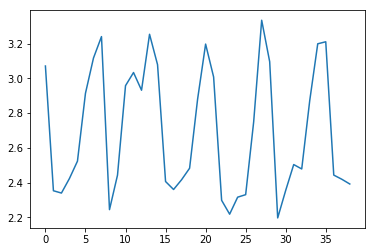

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.935168   
air_0164b9927d20bcc3_2017-04-23              1.516270   
air_0241aa3964b7f861_2017-04-23              2.300987   
air_0328696196e46f18_2017-04-23              2.002742   
air_034a3d5b40d5b1b1_2017-04-23              3.496950   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.925205  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.555201  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.984028  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.409345  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.014600

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')